## On the equivalence of spatial variability tests

In [1]:
import matplotlib.pyplot as plt

# --- Global Configuration ---
font_config = {
    'title': 18,
    'label': 14,
    'tick': 14,
    'text': 14,
    'legend': 14,
}

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.titlesize'] = font_config['title']
plt.rcParams['axes.labelsize'] = font_config['label']
plt.rcParams['xtick.labelsize'] = font_config['tick']
plt.rcParams['ytick.labelsize'] = font_config['tick']
plt.rcParams['legend.fontsize'] = font_config['legend']
plt.rcParams['pdf.fonttype'] = 42

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.special import kv, gamma
import torch
import itertools
from tqdm import tqdm
import time

from quadsv.utils import (
    get_rect_coords, get_visium_coords, convert_visium_to_physical,
    compute_torus_distance_matrix
)

### Theorem 1: Undetectable spatial variability

In [3]:
# --- 1. Data Generation ---
def generate_scenarios(coords, size, seed=42):
    """
    Generates Mean Shift (Smooth) and Variance Shift (Heteroskedastic) patterns.
    """
    np.random.seed(seed)
    n = coords.shape[0]
    
    # Distance from center
    center = np.mean(coords, axis=0)
    dists = np.linalg.norm(coords - center, axis=1)
    
    # Base white noise
    epsilon = np.random.normal(0, 1, n)
    
    # 1. Mean Shift: Smooth sinusoidal wave
    signal = np.sin(coords[:, 0]) + np.cos(coords[:, 1])
    z_mean = signal + epsilon * 0.5
    
    # 2. Variance Shift: Ring of high variance, Mean is 0
    local_std = 1.0 + 5.0 * np.exp(-0.5 * (dists - 3.0)**2)
    z_var = epsilon * local_std
    
    return z_mean, z_var

# --- 2. Kernel Definitions ---
def get_kernels(coords):
    kernels = {}
    dists = cdist(coords, coords)
    
    # (1) Moran's I (Adjacency)
    W = (dists < 1.1).astype(float)
    np.fill_diagonal(W, 0)
    kernels["Moran"] = W

    # (2) Linear Kernel
    coords_centered = coords - coords.mean(axis=0)
    coords_centered /= coords_centered.std(axis=0)
    K_lin = coords_centered @ coords_centered.T
    kernels["Linear"] = K_lin

    # (3) Gaussian RBF
    sigma = 2.0
    K_rbf = np.exp(-(dists**2) / (2 * sigma**2))
    kernels["Gaussian"] = K_rbf

    # (4) Matern Kernel
    nu = 1.5
    length_scale = 2.0
    dists_matern = dists.copy()
    dists_matern[dists_matern == 0] = 1e-10
    factor = (np.sqrt(2 * nu) * dists_matern) / length_scale
    K_matern = (2**(1 - nu) / gamma(nu)) * (factor**nu) * kv(nu, factor)
    np.fill_diagonal(K_matern, 1.0)
    kernels["Matérn"] = K_matern
    
    return kernels

# --- 3. Statistics Engine ---
def calculate_normalized_stats(z, K):
    n = len(z)
    
    # Center and Normalize
    z_centered = z - np.mean(z)
    std = np.linalg.norm(z_centered)
    if std == 0: std = 1
    x = z_centered / std
    
    # Centering Matrix
    J = np.ones((n, n)) / n
    I = np.eye(n)
    H = I - J
    K_centered = H @ K @ H
    
    # Measured Q
    measured_q = (x.T @ K_centered @ x) / (n**2)
    
    # Null Distribution Moments
    scale_factor = 1.0 / (n**3)
    null_mean = np.trace(K_centered) * scale_factor
    null_var = 2 * np.trace(K_centered @ K_centered) * (scale_factor**2)
    null_std = np.sqrt(null_var)
    
    return measured_q, null_mean, null_std

# Generate data
coords, grid_dim = get_rect_coords(50, 50)
coords = coords.astype(float) / 5 # scale to unit 0-10

x_mean, x_var = generate_scenarios(coords, grid_dim)

# Normalize for visualization
z_mean_vis = (x_mean - np.mean(x_mean)) / np.std(x_mean)
z_var_vis = (x_var - np.mean(x_var)) / np.std(x_var)

kernels = get_kernels(coords)
kernel_names = list(kernels.keys())

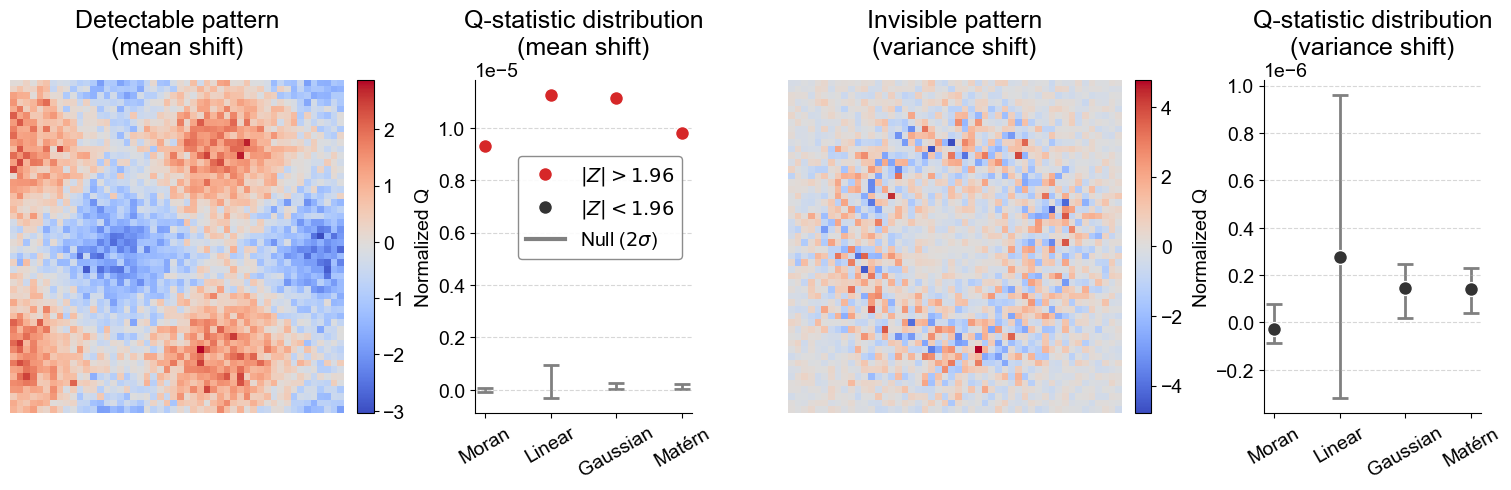

In [4]:
# --- Layout Configuration ---
fig = plt.figure(figsize=(15, 4.5), layout='constrained')
gs = gridspec.GridSpec(1, 5, figure=fig, width_ratios=[1, 0.65, 0.2, 1, 0.65])

# --- Helper to plot Q-Stats ---
def plot_q_stats(ax, data, title, add_legend=True):
    # We set the title later to ensure alignment
    ax._target_title = title 
    
    # Box Aspect: Inverse of width ratio (1/0.65) to match height of square heatmap
    ax.set_box_aspect(1 / 0.65)
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.5, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for i, name in enumerate(kernel_names):
        K = kernels[name]
        q, mu, sigma = calculate_normalized_stats(data, K)
        
        ax.errorbar(i, mu, yerr=2*sigma, fmt='none', ecolor='gray', 
                    elinewidth=2, capsize=6, capthick=2, zorder=1)
        
        z_score = (q - mu) / sigma
        color = '#333333'
        if z_score > 1.96: color = '#D62728'
        elif z_score < -1.96: color = '#1F77B4'
        
        ax.scatter(i, q, color=color, marker='o', s=100, zorder=10, edgecolors='white')

    if add_legend:
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#D62728', 
                   markersize=10, label=r'$|Z|>1.96$'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#333333', 
                   markersize=10, label=r'$|Z|<1.96$'),
            Line2D([0], [0], color='gray', lw=3, label=r'Null ($2\sigma$)')
        ]
        leg = ax.legend(
            handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 0.8),
            frameon=True, framealpha=0.9, edgecolor='gray'
        )
        # leg.get_frame().set_linewidth(0.0)

    ax.set_xticks(range(len(kernel_names)))
    ax.set_xticklabels(kernel_names, rotation=30)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.set_ylabel("Normalized Q")

# --- Helper to plot Heatmap ---
def plot_heatmap(ax, data, grid_dim, title):
    # We set the title later to ensure alignment
    ax._target_title = title
    
    im = ax.imshow(data.reshape(grid_dim), cmap='coolwarm', origin='lower')
    ax.axis('off')

    # add color bar
    cbar_kwargs = {'fraction': 0.05, 'pad': 0.04}
    plt.colorbar(im, ax=ax, location='right', **cbar_kwargs)
    return im

# --- Plotting ---
ax1 = plt.subplot(gs[0])
plot_heatmap(ax1, z_mean_vis, grid_dim, "Detectable pattern\n(mean shift)")

ax2 = plt.subplot(gs[1])
plot_q_stats(ax2, x_mean, "Q-statistic distribution\n(mean shift)")

ax3 = plt.subplot(gs[3])
plot_heatmap(ax3, z_var_vis, grid_dim, "Invisible pattern\n(variance shift)")

ax4 = plt.subplot(gs[4])
plot_q_stats(ax4, x_var, "Q-statistic distribution\n(variance shift)", add_legend=False)

# --- Force Title Alignment ---
# This forces the layout engine to calculate positions, then we grab the
# highest title position and apply it to everyone.
fig.canvas.draw() 

axes_list = [ax1, ax2, ax3, ax4]

# 1. Set titles initially to get their default bounding boxes
titles = []
for ax in axes_list:
    t = ax.set_title(ax._target_title, y = 0.9)
    titles.append(t)

# 2. Find the maximum Y position among all titles in figure coordinates
# We use the transform to get pixel coordinates, then convert back to figure relative
max_y = 0
renderer = fig.canvas.get_renderer()
for t in titles:
    bbox = t.get_window_extent(renderer)
    # Convert window coords (pixels) to figure coords (0-1)
    inv = fig.transFigure.inverted()
    bbox_fig = inv.transform(bbox)
    # bbox_fig is [[x0, y0], [x1, y1]], we want y1 (top)
    if bbox_fig[1, 1] > max_y:
        max_y = bbox_fig[1, 1]

# 3. Reset all titles to that specific Y position (in Figure coordinates)
# We use fig.text instead of ax.set_title to guarantee they stay at that exact Y height
# regardless of the axes below them.
for ax, t in zip(axes_list, titles):
    # Get the X position of the axis center
    bbox = ax.get_position()
    center_x = bbox.x0 + (bbox.width / 2)
    
    # Remove the original axis-bound title
    t.set_visible(False)
    
    # Place a new title at the unified Y height
    # y=max_y might be slightly too tight to the top edge, so we can adjust or use the calculated max
    fig.text(center_x, max_y, ax._target_title, ha='center', va='bottom', fontsize=plt.rcParams['axes.titlesize'])

plt.savefig('figures/sim_thrm1.pdf', bbox_inches='tight')
plt.show()

### Functional view

In [5]:
# --- 1. Data Generation ---
np.random.seed(42)
N = 100
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# 1a. Define Eigenfunctions (Fourier Basis)
def get_eigenfunction_val(nx, ny, X_grid, Y_grid):
    term_x = np.cos(2 * np.pi * nx * X_grid) if nx == 0 else np.sin(2 * np.pi * nx * X_grid)
    term_y = np.cos(2 * np.pi * ny * Y_grid) if ny == 0 else np.sin(2 * np.pi * ny * Y_grid)
    norm_factor = 1.0
    if nx > 0: norm_factor *= np.sqrt(2)
    if ny > 0: norm_factor *= np.sqrt(2)
    return term_x * term_y * norm_factor

# 1b. Generate Spectral Data
indices = []
for i in range(6):
    for j in range(6):
        indices.append((i, j))

# Kernel eigenvalues decay
lambdas = np.array([1.0 / (1 + (ix**2 + iy**2)**1.5) for (ix, iy) in indices])

# Function coefficients
f_coeffs = np.zeros(len(indices))
active_indices = [1, 2, 4, 7, 10, 14, 15, 20] 
for idx in active_indices:
    f_coeffs[idx] = np.random.randn() 

# Sort by Kernel Eigenvalues
sort_order = np.argsort(lambdas)[::-1]
sorted_lambda = lambdas[sort_order]
sorted_f_coeffs = f_coeffs[sort_order]
sorted_f_energy = sorted_f_coeffs**2
sorted_indices = [indices[i] for i in sort_order]

# 1c. Construct Function f
f_func = np.zeros_like(X)
for k, (nx, ny) in enumerate(sorted_indices):
    coeff = sorted_f_coeffs[k]
    if abs(coeff) > 1e-9:
        f_func += coeff * get_eigenfunction_val(nx, ny, X, Y)

# 1d. Generate Observations
num_samples = 100
sample_idx_x = np.random.randint(0, N, num_samples)
sample_idx_y = np.random.randint(0, N, num_samples)
sample_x = x[sample_idx_x]
sample_y = y[sample_idx_y]
sample_vals = f_func[sample_idx_y, sample_idx_x] + 0.2 * np.random.randn(num_samples)

# 1e. Mock Kernel
dist_sq = (X - 0.5)**2 + (Y - 0.5)**2
kernel_spatial = np.exp(-dist_sq * 15)

# 1f. Torus Mapping
def map_to_torus(u, v):
    r = 1; R = 2
    x_3d = (R + r * np.cos(2 * np.pi * v)) * np.cos(2 * np.pi * u)
    y_3d = (R + r * np.cos(2 * np.pi * v)) * np.sin(2 * np.pi * u)
    z_3d = r * np.sin(2 * np.pi * v)
    return x_3d, y_3d, z_3d

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


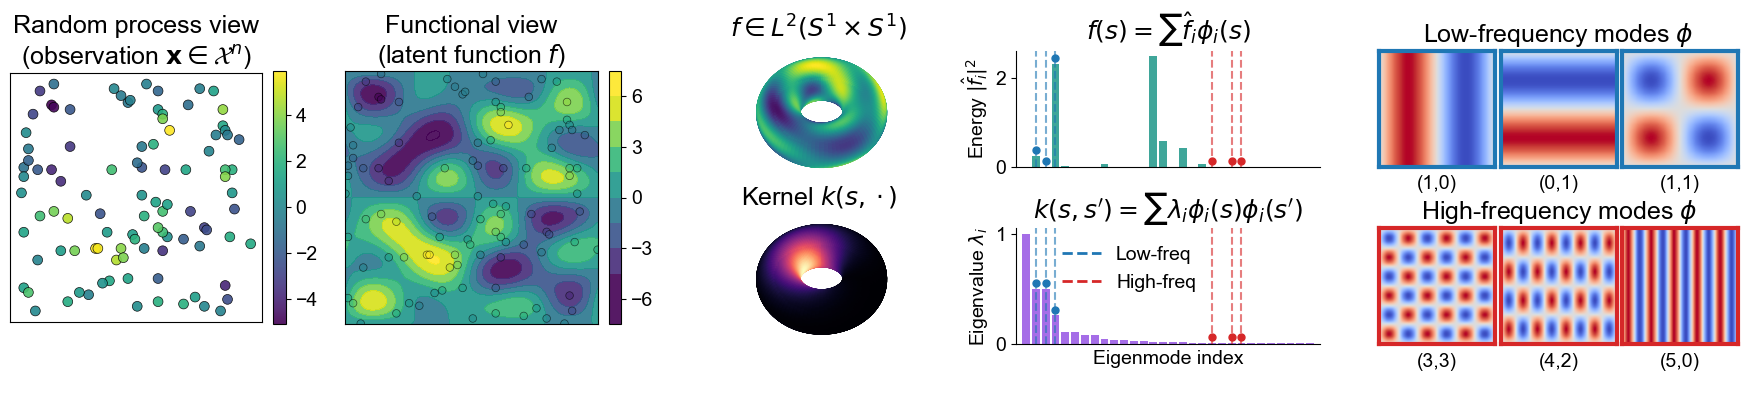

In [6]:
# --- 3. Visualization ---
fig = plt.figure(figsize=(18, 5))

# Layout
gs = gridspec.GridSpec(
    1, 5, width_ratios=[1, 1, 1, 1.1, 1.3],
    wspace=0.2, left=0.02, right=0.98, top=0.85, bottom=0.1
)

cbar_kwargs = {'fraction': 0.046, 'pad': 0.04}
cmap = cm.viridis
norm = plt.Normalize(vmin=np.min(sample_vals), vmax=np.max(sample_vals))

# === Column 1: Random Process ===
ax1 = fig.add_subplot(gs[0])
ax1.set_title(r"Random process view" + "\n" + r"(observation $\mathbf{x}\in\mathcal{X}^n$)")
sc1 = ax1.scatter(sample_x, sample_y, c=sample_vals, cmap=cmap, norm=norm,
            edgecolor='k', linewidth=0.5, s=50, alpha=0.9)
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_aspect('equal')
plt.colorbar(sc1, ax=ax1, **cbar_kwargs)

# === Column 2: Functional View ===
ax2 = fig.add_subplot(gs[1])
ax2.set_title(r"Functional view" + "\n" + r"(latent function $f$)")
ct2 = ax2.contourf(X, Y, f_func, levels=10, cmap=cmap, norm=norm, alpha=0.9)
ax2.scatter(sample_x, sample_y, c=sample_vals, cmap=cmap, norm=norm, 
            edgecolor='k', linewidth=0.5, s=30, alpha=0.6)
ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_aspect('equal')
plt.colorbar(ct2, ax=ax2, **cbar_kwargs)

# === Column 3: Torus Visualization (3D) ===
gs_col3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[2], hspace=-0.2)
X3, Y3, Z3 = map_to_torus(X, Y)

def style_3d_ax(ax, title):
    ax.axis('off') 
    ax.view_init(elev=50, azim=-60)
    ax.set_box_aspect((1, 1, 0.3)) 
    ax.dist = 8.5 
    ax.set_title(title, y=0.9, loc='center')

ax3_top = fig.add_subplot(gs_col3[0], projection='3d')
norm_f = (f_func - f_func.min()) / np.ptp(f_func)
ax3_top.plot_surface(X3, Y3, Z3, facecolors=cm.viridis(norm_f), 
                     rstride=1, cstride=1, shade=False, antialiased=True)
style_3d_ax(ax3_top, r"$f \in L^2(S^1 \times S^1)$")

ax3_bot = fig.add_subplot(gs_col3[1], projection='3d')
norm_k = (kernel_spatial - kernel_spatial.min()) / np.ptp(kernel_spatial)
ax3_bot.plot_surface(X3, Y3, Z3, facecolors=cm.magma(norm_k), 
                     rstride=1, cstride=1, shade=False, antialiased=True)
style_3d_ax(ax3_bot, r"Kernel $k(s, \cdot)$")

# === Column 5: Eigenfunctions ===
gs_col4 = gridspec.GridSpecFromSubplotSpec(
    2, 3, subplot_spec=gs[4], 
    height_ratios=[1, 1], hspace=-0.1, wspace=0.05
)

selected_modes_coords = []
ref_ax_top = None
ref_ax_bot = None

# Define colors
color_low = '#1f77b4'  # Blueish
color_high = '#d62728' # Reddish

low_freqs = [(1, 0), (0, 1), (1, 1)]
high_freqs = [(3, 3), (4, 2), (5, 0)]

def plot_modes(mode_list, row_idx, title_text, ref_var, border_color):
    for i, (nx, ny) in enumerate(mode_list):
        ax = fig.add_subplot(gs_col4[row_idx, i])
        if i == 0: ref_var = ax 
        
        Z_mode = get_eigenfunction_val(nx, ny, X, Y)
        ax.imshow(Z_mode, origin='lower', cmap='coolwarm', extent=[0,1,0,1])
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 1: ax.set_title(title_text, pad=5, y=1.02)
        ax.text(0.5, -0.15, f"({nx},{ny})", transform=ax.transAxes, 
                fontsize=font_config['text'], ha='center', va='center')
        selected_modes_coords.append({'coord': (nx, ny), 'type': 'low' if row_idx==0 else 'high'})
    return ref_var

ref_ax_top = plot_modes(low_freqs, 0, r"Low-frequency modes $\phi$", ref_ax_top, color_low)
ref_ax_bot = plot_modes(high_freqs, 1, r"High-frequency modes $\phi$", ref_ax_bot, color_high)

# === Column 4: Spectrum & Computation ===
# Map coordinates to indices
selected_indices_map = {}
for item in selected_modes_coords:
    coord = item['coord']
    try:
        idx = next(i for i, v in enumerate(sorted_indices) if v == coord)
        selected_indices_map[idx] = item['type']
    except StopIteration:
        pass

max_idx = max(selected_indices_map.keys()) if selected_indices_map else top_n
plot_limit = max(30, max_idx + 5)

gs_col5 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=gs[3], 
    height_ratios=[1, 1], hspace=0.3 
)

# Helper for plotting markers
def plot_markers(ax):
    for idx, mtype in selected_indices_map.items():
        col = color_low if mtype == 'low' else color_high
        ax.axvline(idx, color=col, linestyle='--', alpha=0.6, linewidth=1.5)
        # Get height for dot placement
        if ax == ax5_top:
            y_val = sorted_f_energy[idx]
        else:
            y_val = sorted_lambda[idx]
        ax.scatter(idx, y_val + (0.05 * ax.get_ylim()[1]), color=col, s=25, zorder=5)

# Top: Spectrum of f
ax5_top = fig.add_subplot(gs_col5[0])
ax5_top.bar(range(len(sorted_f_energy)), sorted_f_energy, color='#2a9d8f', alpha=0.9, width=0.8)
ax5_top.set_title(r"$f(s) = \sum \hat{f}_i \phi_i(s)$", y=1.02)
ax5_top.set_ylabel(r"Energy $|\hat{f}_i|^2$")
ax5_top.spines['top'].set_visible(False)
ax5_top.spines['right'].set_visible(False)
ax5_top.set_xlim(-1, plot_limit)
ax5_top.set_xticks([]) 
plot_markers(ax5_top)


# Bottom: Spectrum of k
ax5_bot = fig.add_subplot(gs_col5[1])
ax5_bot.bar(range(len(sorted_lambda)), sorted_lambda, color='#9b5de5', alpha=0.9, width=0.8)
ax5_bot.set_title(r"$k(s,s') = \sum \lambda_i \phi_i(s)\phi_i(s')$", y=1.02)
ax5_bot.set_ylabel(r"Eigenvalue $\lambda_i$")
ax5_bot.set_xlabel("Eigenmode index")
ax5_bot.spines['top'].set_visible(False)
ax5_bot.spines['right'].set_visible(False)
ax5_bot.set_xlim(-1, plot_limit)
ax5_bot.set_xticks([]) 
plot_markers(ax5_bot)

# Legend for Col 5
legend_elements = [
    Line2D([0], [0], color=color_low, lw=2, linestyle='--', label='Low-freq'),
    Line2D([0], [0], color=color_high, lw=2, linestyle='--', label='High-freq')
]
ax5_bot.legend(handles=legend_elements, loc='upper right', frameon=False, bbox_to_anchor = (0.65, 1))

# === ALIGNMENT FIX ===
pos_ref_top = ref_ax_top.get_position()
pos_ref_bot = ref_ax_bot.get_position()
pos5_top = ax5_top.get_position()
pos5_bot = ax5_bot.get_position()

ax5_top.set_position([pos5_top.x0, pos_ref_top.y0, pos5_top.width, pos_ref_top.height])
ax5_bot.set_position([pos5_bot.x0, pos_ref_bot.y0, pos5_bot.width, pos_ref_bot.height])

plt.savefig('figures/sim_functional.pdf', bbox_inches='tight')
plt.show()

### Theorem 2: Kernel spectrum

In [7]:
# --- 1. Data & Spectrum Generation ---
N = 100
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Define a toy spectrum
modes_list = [(0, 0)]
lambdas_list = [0]
for (nx, ny) in [
    (1, 0), (0, 1), (1, 1), (2, 0), (0, 2), (2, 1), (1, 2), (2, 2)
]:
    if (nx, ny) == (1,0): # positive
        _l = 1.0
    elif (nx, ny) == (0,2): # negative
        _l = -1.0
    elif (nx, ny) == (2,2): # blind spot
        _l = 0.0
    else:
        _l = np.exp(-(nx+ny))
    
    modes_list.append((nx, ny))
    lambdas_list.append(_l)

# Sort for visualization (put our key actors first for clarity, or by index)
# Let's keep them at fixed indices for the plot
plot_indices = np.arange(len(lambdas_list))

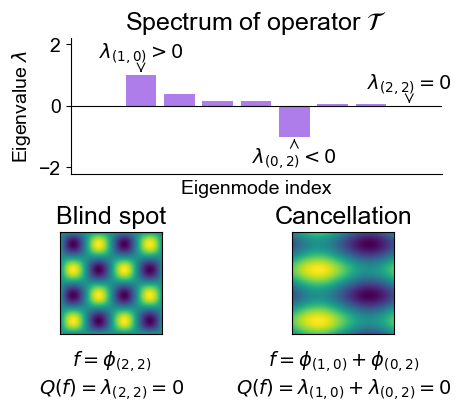

In [8]:
# --- Visualization ---
fig = plt.figure(figsize=(4.5, 4), layout = 'constrained')
gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.8, 1.2])

# === Top Panel: The Operator Spectrum ===
ax_spec = fig.add_subplot(gs[0])
bars = ax_spec.bar(plot_indices, lambdas_list, color='#9b5de5', alpha=0.8)
ax_spec.axhline(0, color='k', linewidth=0.8)

# Annotate the key modes
def annotate_bar(idx, text, y_offset):
    ax_spec.annotate(text, 
                     xy=(idx, lambdas_list[idx]), 
                     xytext=(idx, lambdas_list[idx] + y_offset),
                     ha='center', va='bottom' if y_offset > 0 else 'top',
                     fontsize=font_config['text'], fontweight='bold',
                     arrowprops=dict(arrowstyle='->', color='k', lw=0.8))

annotate_bar(1, r"$\lambda_{(1,0)} > 0$", 0.3)
annotate_bar(8, r"$\lambda_{(2,2)} = 0$", 0.3)
annotate_bar(5, r"$\lambda_{(0,2)} < 0$", -0.3)

ax_spec.set_title(r"Spectrum of operator $\mathcal{T}$")
ax_spec.set_ylabel(r"Eigenvalue $\lambda$")
ax_spec.set_xlabel("Eigenmode index")
ax_spec.set_xticks([])
ax_spec.set_ylim(-2.2, 2.2)
ax_spec.spines['top'].set_visible(False)
ax_spec.spines['right'].set_visible(False)


# === Bottom Panel: with two plots ===
gs_bottom = gs[1].subgridspec(1, 2, wspace=0.1)

# === Bottom Left: Blind Spot ===
ax_blind = fig.add_subplot(gs_bottom[0])

# f = phi_k (the blind mode)
Z_blind = get_eigenfunction_val(2,2, X, Y)

im_blind = ax_blind.imshow(Z_blind, origin='lower', cmap='viridis', extent=[0,1,0,1])
ax_blind.set_title("Blind spot", fontsize=font_config['title'])
ax_blind.set_xticks([]); ax_blind.set_yticks([])

# Add Math Text
text_blind = (
    r"$f = \phi_{(2,2)}$" + "\n"
    r"$Q(f) = \lambda_{(2,2)} = 0$"
)
ax_blind.text(0.5, -0.15, text_blind, transform=ax_blind.transAxes, 
              ha='center', va='top', fontsize=font_config['text'],
              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="white", alpha=0.9))


# === Bottom Right: Cancellation ===
ax_cancel = fig.add_subplot(gs_bottom[1])

# f = sqrt(|lam_neg|)*phi_pos + sqrt(lam_pos)*phi_neg
# Here |lam_neg| = 1, lam_pos = 1, so weights are 1 and 1.
Z_pos = get_eigenfunction_val(1, 0, X, Y)
Z_neg = get_eigenfunction_val(0, 2, X, Y)
Z_cancel = Z_pos + Z_neg

im_cancel = ax_cancel.imshow(Z_cancel, origin='lower', cmap='viridis', extent=[0,1,0,1])
ax_cancel.set_title("Cancellation", fontsize=font_config['title'])
ax_cancel.set_xticks([]); ax_cancel.set_yticks([])

# Add Math Text
text_cancel = (
    r"$f = \phi_{(1,0)} + \phi_{(0,2)}$" + "\n"
    r"$Q(f) = \lambda_{(1,0)} + \lambda_{(0,2)} = 0$"
)
ax_cancel.text(0.5, -0.15, text_cancel, transform=ax_cancel.transAxes, 
               ha='center', va='top', fontsize=font_config['text'],
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="white", alpha=0.9))

plt.savefig('figures/sim_thrm2.pdf', bbox_inches='tight')
plt.show()

### Analysis on Moran's I

#### Simulate data and compute spectra

In [9]:
# --- 1. Simulation Setup ---
N = 100
L = 1.0  # Domain size
dx = L / N
dy = L / N
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, y)

# Frequency Grid
kx = np.fft.fftfreq(N, d=L/N)
ky = np.fft.fftfreq(N, d=L/N)
KX, KY = np.meshgrid(kx, ky)
Omega = 2 * np.pi * np.sqrt(KX**2 + KY**2)

def get_torus_distance(x1, y1, x2, y2, box_size):
    dx = np.abs(x1 - x2)
    dy = np.abs(y1 - y2)
    dx = np.minimum(dx, box_size - dx)
    dy = np.minimum(dy, box_size - dy)
    return np.sqrt(dx**2 + dy**2)

# --- 2. Kernel & Spectrum Generation ---

# A. Moran's I (Adjacency)
r = 0.15
dist_center = get_torus_distance(X, Y, 0.5, 0.5, L)
K_moran = (dist_center < r).astype(float)
K_moran_shifted = np.fft.fftshift(K_moran) 
S_moran = np.fft.fft2(K_moran_shifted).real 

# B. Graph Laplacian (High-Pass)
K_lap = np.zeros((N, N))
cx, cy = N//2, N//2
K_lap[cx, cy] = 1.0
K_lap[cx+1, cy] = -1.0/4; K_lap[cx-1, cy] = -1.0/4
K_lap[cx, cy+1] = -1.0/4; K_lap[cx, cy-1] = -1.0/4
K_lap_shifted = np.fft.fftshift(K_lap)
S_lap = np.fft.fft2(K_lap_shifted).real

# C. CAR (Inverse Graph Laplacian, Low-Pass)
alpha = 0.01
S_car = 1.0 / (1.0 + alpha * Omega**2)

# --- 3. Logic: Generate ONE Signal (Moran Cancellation Case) ---

# A. Analyze Moran's Spectrum
S_flat = S_moran.flatten()
idx_pos = np.argsort(S_flat)[-2] 
idx_neg = np.argmin(S_flat)

lambda_1_moran = S_flat[idx_pos]
lambda_2_moran = S_flat[idx_neg]

# B. Calculate weights
w1 = np.sqrt(np.abs(lambda_2_moran))
w2 = np.sqrt(np.abs(lambda_1_moran))

# C. Construct Master Signal
y1_idx, x1_idx = np.unravel_index(idx_pos, S_moran.shape)
y2_idx, x2_idx = np.unravel_index(idx_neg, S_moran.shape)

kx1, ky1 = KX[y1_idx, x1_idx], KY[y1_idx, x1_idx]
kx2, ky2 = KX[y2_idx, x2_idx], KY[y2_idx, x2_idx]

phi_1 = np.cos(2 * np.pi * (kx1 * X + ky1 * Y))
phi_2 = np.cos(2 * np.pi * (kx2 * X + ky2 * Y))

# Centering phi_1 and phi_2 to get the eigenmodes of the centered operator
phi_1 -= phi_1.mean()
phi_2 -= phi_2.mean()

#### Counterexample for spatial variability

In [10]:
f_raw = w1 * phi_1 + w2 * phi_2

# D. Normalize to Unit Norm
integral_sq = np.sum(f_raw**2) * dx * dy
f_norm = np.sqrt(integral_sq)
f_master = f_raw / f_norm

F_master_hat = np.fft.fft2(f_master)

# E. Apply to ALL kernels and extract specific eigenvalues
def apply_kernel_and_get_meta(Spectrum):
    # Apply
    f_out = np.fft.ifft2(F_master_hat * Spectrum).real
    
    # Extract eigenvalues at the specific frequencies used in f_master
    lam_1 = Spectrum[y1_idx, x1_idx]
    lam_2 = Spectrum[y2_idx, x2_idx]
    
    meta = {
        'omega_1': Omega[y1_idx, x1_idx], 'lam_1': lam_1,
        'omega_2': Omega[y2_idx, x2_idx], 'lam_2': lam_2
    }
    return f_out, meta

out_moran, meta_moran = apply_kernel_and_get_meta(S_moran)
out_lap, meta_lap     = apply_kernel_and_get_meta(S_lap)
out_car, meta_car     = apply_kernel_and_get_meta(S_car)

# --- 4. Calculate Q Statistic ---
# Q = x.T @ H @ K @ H @ x
def calculate_q_stat(f_in, spectrum):
    # 1. Center the signal (Apply H)
    z = f_in - np.mean(f_in)
    
    # 2. Apply Kernel K (Convolution via FFT)
    z_hat = np.fft.fft2(z)
    Kz = np.fft.ifft2(z_hat * spectrum).real
    
    # 3. Compute Quadratic Form (Dot product)
    Q = np.sum(z * Kz)
    return Q

Q_moran = calculate_q_stat(f_master, S_moran)
Q_lap = calculate_q_stat(f_master, S_lap)
Q_car = calculate_q_stat(f_master, S_car)

In [11]:
Q_moran, Q_lap, Q_car

(np.float64(1.0186340659856796e-10),
 np.float64(222.721034265747),
 np.float64(1705.6594320015874))

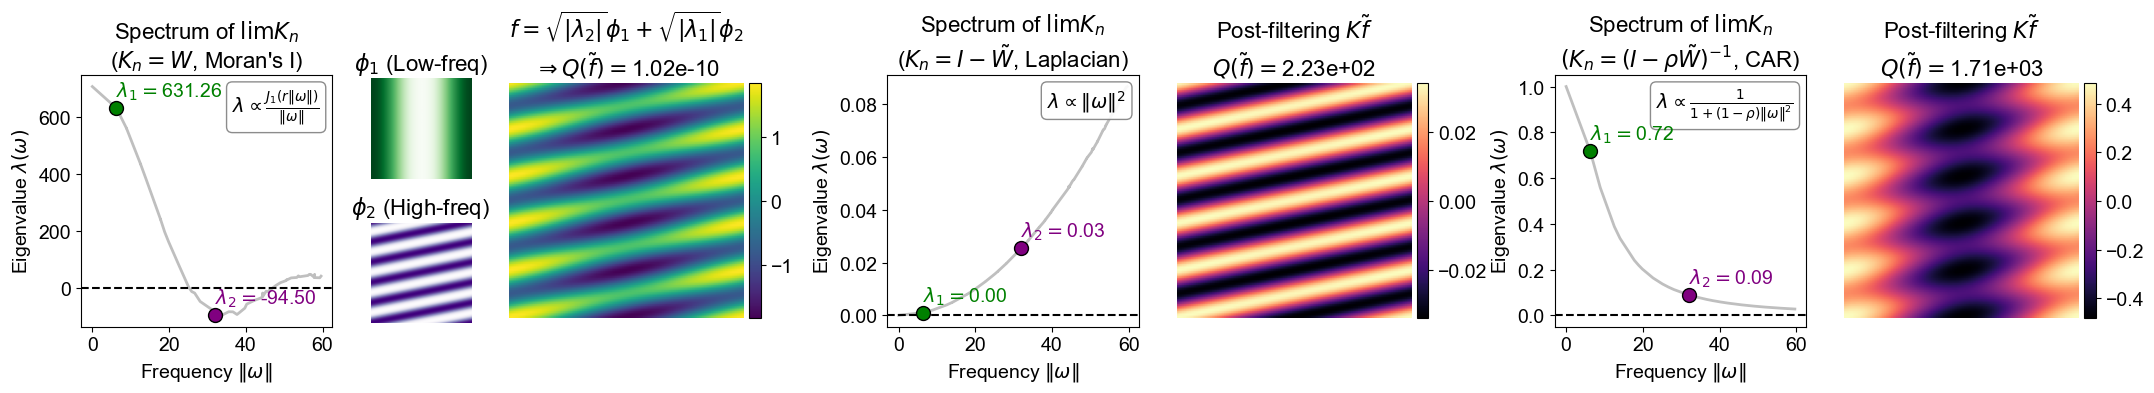

In [12]:
fig = plt.figure(figsize=(26, 5))

# GridSpec: 9 Columns
# We adjust width ratios. The stacked column (index 1) is narrower (0.55).
# Spacers (indices 3 and 6) are kept small.
gs = gridspec.GridSpec(1, 9, figure=fig, 
                       width_ratios=[1, 0.4, 1, 0.2, 1, 1, 0.2, 1, 1])

def add_colorbar(im, ax, label=""):
    """
    Uses make_axes_locatable to ensure colorbar is exactly the same height 
    as the plot, regardless of aspect ratio.
    """
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, 5% width, with 0.05 padding
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(label, fontsize=font_config['text'], rotation=270, labelpad=15)
    cbar.ax.tick_params(labelsize=font_config['text'])

    return cbar

def plot_spectrum(ax, spectrum, meta, title, eq_text):
    # Force the plot area to be square
    ax.set_box_aspect(1)
    
    # Flatten and sort logic (same as original)
    if 'Omega' in globals() and Omega.ndim > 1:
        flat_idx = np.argsort(Omega.flatten())
        o_flat = Omega.flatten()[flat_idx]
        s_flat = spectrum.flatten()[flat_idx]
    else:
        # Fallback for 1D dummy data
        o_flat = Omega
        s_flat = spectrum

    mask = o_flat < 60
    ax.plot(o_flat[mask], s_flat[mask], color='gray', alpha=0.5, lw=2)
    ax.axhline(0, color='k', linestyle='--', lw=1.5)
    
    ax.scatter([meta['omega_1']], [meta['lam_1']], color='green', s=100, zorder=5, edgecolors='k', label=r'$\phi_1$')
    ax.scatter([meta['omega_2']], [meta['lam_2']], color='purple', s=100, zorder=5, edgecolors='k', label=r'$\phi_2$')
    
    ax.set_title(title, fontsize=font_config['text'] + 2)
    ax.set_xlabel(r"Frequency $\|\omega\|$", fontsize=font_config['text'])
    ax.set_ylabel(r"Eigenvalue $\lambda (\omega)$", fontsize=font_config['text'])
    
    ax.text(0.95, 0.95, eq_text, transform=ax.transAxes, ha='right', va='top', 
            fontsize=font_config['text'], bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.9))

    offset = (np.max(s_flat[mask]) - np.min(s_flat[mask])) * 0.05
    ax.text(meta['omega_1'], meta['lam_1'] + offset, r"$\lambda_1=$" + f"{meta['lam_1']:.2f}", 
                 color='green', ha='left', fontsize=font_config['text'])
    ax.text(meta['omega_2'], meta['lam_2'] + offset, r"$\lambda_2=$" + f"{meta['lam_2']:.2f}",
                 color='purple', ha='left', fontsize=font_config['text'])

def plot_spatial(ax, data, title, cmap, show_cbar=True, aspect_ratio=1):
    # Force the plot area to be square (or specific aspect)
    if aspect_ratio is not None:
        ax.set_box_aspect(aspect_ratio)
        
    vm = np.max(np.abs(data))
    if vm < 1e-9: vm = 1.0
    
    # extent ensures the image fills the axes correctly
    im = ax.imshow(data, origin='lower', cmap=cmap, vmin=-vm, vmax=vm, 
                   extent=[0,1,0,1], aspect='equal')
    
    ax.set_title(title, fontsize=font_config['text'] + 2)
    ax.axis('off')
    
    if show_cbar:
        _ = add_colorbar(im, ax)

# --- Group 1: Moran's I (Cols 0, 1, 2) ---
ax1 = fig.add_subplot(gs[0, 0])
plot_spectrum(ax1, S_moran, meta_moran, 
              r"Spectrum of $\lim K_n$" + "\n"+ r"($K_n =W$, Moran's I)", 
              r"$\lambda \propto \frac{J_1(r\|\omega\|)}{\|\omega\|}$")

# Nested GridSpec for Components (Col 1)
# hspace=0.05 ensures they are tight but distinct. 
# The parent GridSpec (gs[0,1]) will stretch to match the height of neighbors (ax1 and ax2).
gs_comps = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0, 1], hspace=-0.4)

ax_phi1 = fig.add_subplot(gs_comps[0, 0])

plot_spatial(ax_phi1, phi_1, r"$\phi_1$ (Low-freq)", 'Greens', show_cbar=False, aspect_ratio=None)

ax_phi2 = fig.add_subplot(gs_comps[1, 0])
plot_spatial(ax_phi2, phi_2, r"$\phi_2$ (High-freq)", 'Purples', show_cbar=False, aspect_ratio=None)

ax2 = fig.add_subplot(gs[0, 2])
plot_spatial(ax2, f_master, 
             r"$f =\sqrt{|\lambda_2|} \phi_1 + \sqrt{|\lambda_1|}\phi_2$" + "\n" + r"$\Rightarrow Q(\tilde{f}) = $" + f"{Q_moran:.2e}", 
             'viridis')

# --- Group 2: Graph Laplacian (Cols 4, 5) ---
ax3 = fig.add_subplot(gs[0, 4])
plot_spectrum(ax3, S_lap, meta_lap, 
              r"Spectrum of $\lim K_n$" + "\n" + r"($K_n =I - \tilde{W}$, Laplacian)", 
              r"$\lambda \propto \|\omega\|^2$")

ax4 = fig.add_subplot(gs[0, 5])
plot_spatial(ax4, out_lap, 
             r"Post-filtering $K\tilde{f}$" + "\n" + r"$Q(\tilde{f}) = $" + f"{Q_lap:.2e}",
             'magma')

# --- Group 3: Inverse Laplacian (Cols 7, 8) ---
ax5 = fig.add_subplot(gs[0, 7])
plot_spectrum(ax5, S_car, meta_car, 
              r"Spectrum of $\lim K_n$" + "\n" + r"$(K_n =(I - \rho \tilde{W})^{-1}$, CAR)", 
              r"$\lambda \propto \frac{1}{1+(1-\rho)\|\omega\|^2}$")

ax6 = fig.add_subplot(gs[0, 8])
plot_spatial(ax6, out_car, 
             r"Post-filtering $K\tilde{f}$" + "\n" + r"$Q(\tilde{f}) = $" + f"{Q_car:.2e}",
             'magma')

plt.savefig('figures/spectra_moran.pdf', bbox_inches='tight')
plt.show()

## Implementation of Q-test

In [7]:
import quadsv
from quadsv.kernels import SpatialKernel
from quadsv.statistics import spatial_q_test
from quadsv.fft import FFTKernel, spatial_q_test_fft

from scipy.stats import nbinom

def generate_counts(coords_phys, mean_expr, dispersion_phi=0.1, pattern_strength=0.0):
    """
    Generates counts on a specific set of coordinates.
    
    Args:
        coords_phys: (N, 2) array of physical (x, y) coordinates.
        mean_expr: Target mean expression.
        dispersion_phi: Negative binomial dispersion.
        pattern_strength: Amplitude of the spatial pattern.

    Returns:
        counts: (N,) flat array of simulated expression counts measured at coords_phys
    """
    N = coords_phys.shape[0]
    
    # Normalize coordinates to [0, 1] for consistent pattern generation
    # regardless of physical unit scale (e.g. microns vs indices)
    c_min = coords_phys.min(axis=0)
    c_max = coords_phys.max(axis=0)
    # Avoid division by zero if flat
    denom = c_max - c_min
    denom[denom == 0] = 1.0
    coords_norm = (coords_phys - c_min) / denom
    
    mu_vec = np.full(N, mean_expr)
    
    # Apply spatial pattern if strength > 0
    if pattern_strength > 0:
        # Sinusoidal pattern based on normalized physical location
        pattern = np.sin(2 * np.pi * coords_norm[:, 0]) * np.cos(2 * np.pi * coords_norm[:, 1])
        
        # Scale mean by pattern
        mu_vec = mu_vec * (1 + pattern_strength * pattern)
        # Normalize to maintain the overall mean expression target
        mu_vec *= (mean_expr / mu_vec.mean())
        # Ensure no negative means
        mu_vec = np.maximum(mu_vec, 0.01)

    n_param = 1.0 / dispersion_phi
    p_param = 1.0 / (1.0 + mu_vec * dispersion_phi)
    counts = nbinom.rvs(n_param, p_param)

    return counts

### Null approximation choice

In [16]:
# --- Simulation ---
def run_accuracy_simulation():
    print("--- Running Accuracy Simulation ---")
    n_side = 32
    n_reps = 50
    means = [0.1, 0.5, 2.0]
    kernel_methods = ['gaussian', 'matern', 'graph_laplacian', 'car']
    mtx_defaults = {
        'gaussian': {'bandwidth': 2.0},
        'matern': {'bandwidth': 2.0, 'nu': 1.5},
        'moran': {'k_neighbors': 4},
        'graph_laplacian': {'k_neighbors': 4},
        'car': {'rho': 0.9, 'k_neighbors': 4, 'standardize': False},
    }

    results = []
    sample_maps = {'H0': {}, 'H1': {}} 
    
    # Generate coordinates once
    coords, _ = get_rect_coords(n_side, n_side)
    
    # Pre-build kernels (Optimization: Build once per method, reuse for reps)
    kernels = {}
    for method in kernel_methods:
        k_obj = SpatialKernel.from_coordinates(
            coords, method=method, **mtx_defaults[method]
        )
        kernels[method] = k_obj

    for mu in means:
        # Save representative maps
        X_h0_ex = generate_counts(coords, mu, pattern_strength=0.0)
        sample_maps['H0'][mu] = (X_h0_ex, coords)
        X_h1_ex = generate_counts(coords, mu, pattern_strength=1.0)
        sample_maps['H1'][mu] = (X_h1_ex, coords)

        for rep in tqdm(range(n_reps), desc=f'Mean={mu}', bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            X_h0 = generate_counts(coords, mu, pattern_strength=0.0)
            X_h1 = generate_counts(coords, mu, pattern_strength=1.0)
            
            for method, k_obj in kernels.items():
                # H0 Tests
                _, p_welch_0 = spatial_q_test(X_h0, k_obj, return_pval=True, null_params={'method': 'welch'})
                _, p_liu_0   = spatial_q_test(X_h0, k_obj, return_pval=True, null_params={'method': 'liu'})
                
                results.append({
                    'mean_expr': mu, 'kernel': method, 'scenario': 'H0',
                    'p_welch': p_welch_0, 'p_liu': p_liu_0
                })
                
                # H1 Tests
                _, p_welch_1 = spatial_q_test(X_h1, k_obj, return_pval=True, null_params={'method': 'welch'})
                _, p_liu_1   = spatial_q_test(X_h1, k_obj, return_pval=True, null_params={'method': 'liu'})
                
                results.append({
                    'mean_expr': mu, 'kernel': method, 'scenario': 'H1',
                    'p_welch': p_welch_1, 'p_liu': p_liu_1
                })

    return pd.DataFrame(results), sample_maps

# --- Execution ---
df_acc, sample_maps = run_accuracy_simulation()

--- Running Accuracy Simulation ---


Mean=2.0: 100%|██████████| 50/50 [01:58<00:00,  2.36s/it]                       


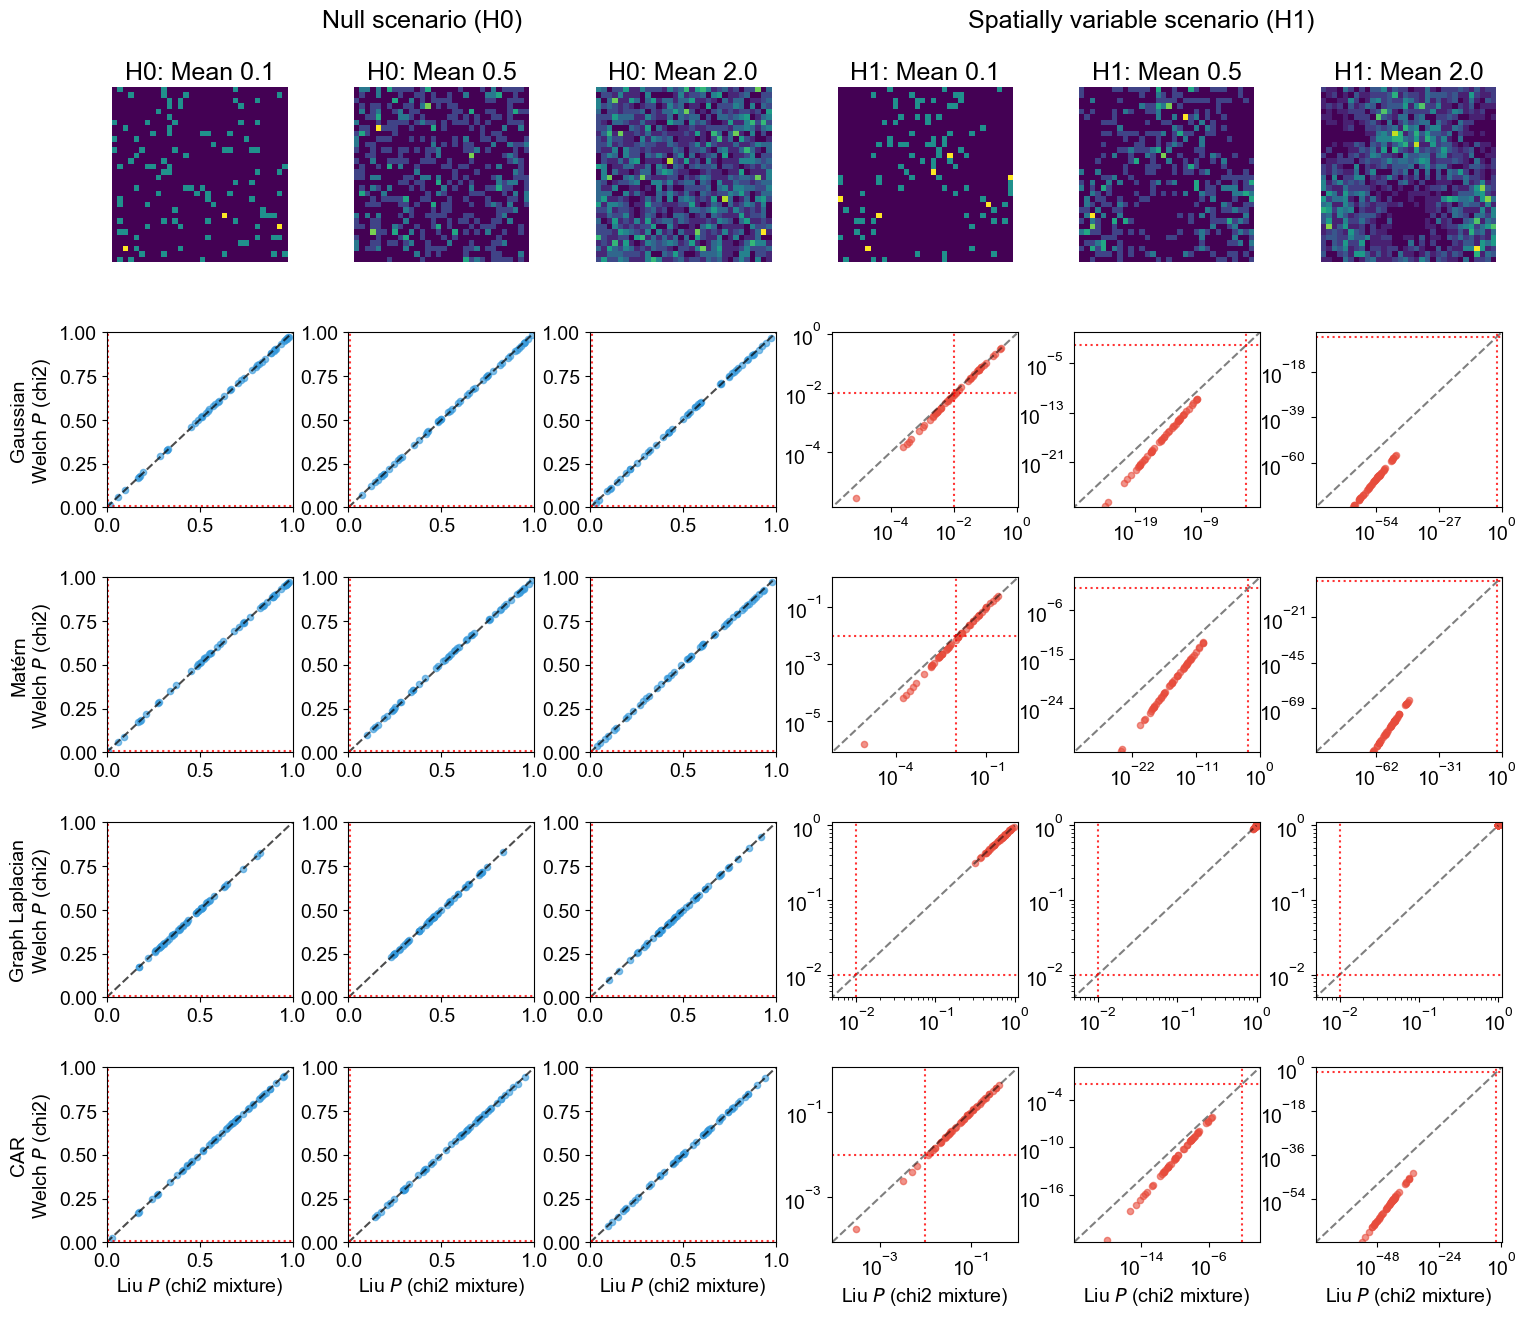

In [17]:
# Visualization
means = sorted(df_acc['mean_expr'].unique())
kernels = ['gaussian', 'matern', 'graph_laplacian', 'car']
names = ['Gaussian', 'Matérn', 'Graph Laplacian', 'CAR']

fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(5, 6, hspace=0.4, wspace=0.3)

# Row 1: Heatmaps
# Assuming sample_maps structure is consistent with previous context
n_side = int(np.sqrt(sample_maps['H0'][means[0]][0].shape[0]))
for i, mu in enumerate(means):
    # H0
    ax = fig.add_subplot(gs[0, i])
    counts, _ = sample_maps['H0'][mu]
    ax.imshow(counts.reshape(n_side, n_side), cmap='viridis', origin='lower')
    ax.set_title(f"H0: Mean {mu}")
    ax.axis('off')
    
    # H1
    ax = fig.add_subplot(gs[0, i+3])
    counts, _ = sample_maps['H1'][mu]
    ax.imshow(counts.reshape(n_side, n_side), cmap='viridis', origin='lower')
    ax.set_title(f"H1: Mean {mu}")
    ax.axis('off')

# Rows 2-5: Scatter Plots
for row_idx, kern in enumerate(kernels, start=1):
    for col_idx, mu in enumerate(means):
        
        # --- H0 (Linear Scale) ---
        ax_h0 = fig.add_subplot(gs[row_idx, col_idx])
        d_h0 = df_acc[(df_acc['mean_expr'] == mu) & (df_acc['kernel'] == kern) & (df_acc['scenario'] == 'H0')]
        
        ax_h0.scatter(d_h0['p_liu'], d_h0['p_welch'], alpha=0.6, s=20, color='#3498db')
        
        # Identity line
        ax_h0.plot([0, 1], [0, 1], 'k--', alpha=0.7)
        
        # Threshold lines (0.01)
        ax_h0.axvline(0.01, color='red', linestyle=':', linewidth=1.5, alpha=0.8)
        ax_h0.axhline(0.01, color='red', linestyle=':', linewidth=1.5, alpha=0.8)

        ax_h0.set_xlim(0, 1); ax_h0.set_ylim(0, 1)
        
        if col_idx == 0:
            # ax_h0.set_ylabel(f"{kern.title()}\nWelch P-value (chi2)")
            ax_h0.set_ylabel(f"{names[row_idx - 1]}\n" + r"Welch $P$ (chi2)")
        if row_idx == 4:
            ax_h0.set_xlabel(r"Liu $P$ (chi2 mixture)")

        # --- H1 (Log Scale) ---
        ax_h1 = fig.add_subplot(gs[row_idx, col_idx+3])
        d_h1 = df_acc[(df_acc['mean_expr'] == mu) & (df_acc['kernel'] == kern) & (df_acc['scenario'] == 'H1')]
        
        ax_h1.scatter(d_h1['p_liu'], d_h1['p_welch'], alpha=0.6, s=20, color='#e74c3c')
        
        if kern != 'laplacian':
            ax_h1.set_xscale('log'); ax_h1.set_yscale('log')
        
        # Identity line
        ax_h1.plot([1e-100, 1], [1e-100, 1], 'k--', alpha=0.5)

        # Threshold lines (0.01)
        ax_h1.axvline(0.01, color='red', linestyle=':', linewidth=1.5, alpha=0.8)
        ax_h1.axhline(0.01, color='red', linestyle=':', linewidth=1.5, alpha=0.8)
        
        # Dynamic limits for log plot
        vals = np.concatenate([d_h1['p_liu'], d_h1['p_welch']])
        vals = vals[vals > 0]
        if len(vals) > 0:
            low = max(vals.min() * 0.5, 1e-100)
            # Ensure the 0.01 line is visible even if points are very small
            low = min(low, 0.005) 
            ax_h1.set_xlim(low, 1.1); ax_h1.set_ylim(low, 1.1)
        
        if row_idx == 4:
            ax_h1.set_xlabel(r"Liu $P$ (chi2 mixture)")

fig.text(0.3, 0.92, "Null scenario (H0)", ha='center', fontsize=font_config['title'])
fig.text(0.7, 0.92, "Spatially variable scenario (H1)", ha='center', fontsize=font_config['title'])

plt.savefig('figures/sup_null_acc.pdf', bbox_inches='tight')
plt.show()

### Matrix operation runtime

In [18]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chi2
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import inv
from scipy.sparse.linalg import spsolve, eigs

def run_kernel_test_simulation():
    print("--- Running Component-wise Runtime Simulation (5 Scenarios) ---")
    
    n_sides = [10, 20, 30, 40, 50] # Grid sizes
    n_reps = 3
    kernels = ['gaussian', 'matern', 'graph_laplacian', 'car', 'car_implicit']
    
    # Parameters
    bw = 1.0       
    k_neighbors = 4 
    rho = 0.9      
    
    results = []

    for n_side in n_sides:
        N = n_side * n_side
        print(f"  Processing Grid Size: {n_side}x{n_side} (N={N})")
        
        for rep in range(n_reps):
            # 1. Generate Dummy Data & Coords
            coords = np.array([(r, c) for r in range(n_side) for c in range(n_side)])
            X = np.random.randn(N)
            z = (X - np.mean(X)) / np.std(X, ddof=1)

            for kern in kernels:
                # Variables to hold matrix representations
                K_dense = None
                M_sparse = None # For implicit solver (Precision matrix)
                
                # --- PHASE 1: Kernel Construction ---
                t0 = time.time()
                
                if kern in ['gaussian', 'matern']:
                    dists = squareform(pdist(coords, metric='euclidean'))
                    if kern == 'gaussian':
                        K_dense = np.exp(-dists**2 / (2 * bw**2))
                    elif kern == 'matern':
                        dists[dists == 0] = 1e-15
                        scale = np.sqrt(3) * dists / bw
                        K_dense = (1 + scale) * np.exp(-scale)
                        np.fill_diagonal(K_dense, 1.0)
                        
                elif kern in ['graph_laplacian', 'car', 'car_implicit']:
                    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree').fit(coords)
                    W = nbrs.kneighbors_graph(coords, mode='connectivity').astype(float)
                    
                    # Row normalize
                    row_sums = np.array(W.sum(axis=1)).flatten()
                    row_sums[row_sums == 0] = 1.0
                    inv_D = sp.diags(1.0 / row_sums)
                    W = inv_D @ W
                    
                    if kern == 'graph_laplacian':
                        I = sp.eye(N)
                        W_sym = 0.5 * (W + W.T)
                        K_dense = (I - W_sym).toarray()
                        
                    elif kern == 'car':
                        # Explicit Inversion (Dense)
                        I = sp.eye(N, format='csc')
                        M = I - rho * W
                        K_temp = inv(M.toarray())
                        K_dense = 0.5 * (K_temp + K_temp.T)
                        
                    elif kern == 'car_implicit':
                        # Implicit Construction (Sparse Precision Matrix)
                        I = sp.eye(N, format='csc')
                        M_sparse = I - rho * W

                t_construct = time.time() - t0

                # --- PHASE 2: Q Statistic Computation ---
                t0 = time.time()
                Q_stat = 0.0
                
                if kern == 'car_implicit':
                    # Solve M*y = z  => y = M^-1 * z = K * z
                    # Q = z.T @ y
                    y = spsolve(M_sparse, z)
                    Q_stat = z.T @ y
                else:
                    # Standard dense multiplication
                    Q_stat = z.T @ K_dense @ z
                    
                t_qstat = time.time() - t0

                # --- PHASE 3: Welch's Approximation (Moment Matching) ---
                t0 = time.time()
                mean_Q = 0.0
                var_Q = 0.0
                
                if kern == 'car_implicit':
                    # Hutchinson's Trace Estimator
                    # Estimate Trace(K) and Trace(K^2) using random probes
                    n_probes = 15 # Number of random vectors
                    
                    # Rademacher vectors (+1/-1)
                    rvs = np.random.choice([-1, 1], size=(N, n_probes))
                    u = spsolve(M_sparse, rvs) # (n, n_probes)
                    tr_K_est = np.trace(rvs.T @ u)
                    tr_K2_est = np.sum(u**2)

                    mean_Q = tr_K_est / n_probes
                    var_Q = 2 * (tr_K2_est / n_probes)
                else:
                    # Exact Trace for dense
                    tr_K = np.trace(K_dense)
                    tr_K2 = np.sum(K_dense**2)
                    mean_Q = tr_K
                    var_Q = 2 * tr_K2

                # Calculate p-value
                if var_Q > 0:
                    scale_g = var_Q / (2 * mean_Q)
                    df_h = (2 * mean_Q**2) / var_Q
                    _ = chi2.sf(Q_stat / scale_g, df=df_h)
                t_welch = time.time() - t0

                # --- PHASE 4: Liu's Approximation (Eigenvalues) ---
                t0 = time.time()
                eig_vals = []
                
                if kern == 'car_implicit':
                    eig_vals = np.linalg.eigvalsh(M_sparse.toarray()) ** (-1)
                else:
                    # Dense Eigen decomposition
                    eig_vals = np.linalg.eigvalsh(K_dense)
                
                c1 = np.sum(eig_vals)
                c2 = np.sum(eig_vals**2)
                t_liu = time.time() - t0

                results.append({
                    'kernel': kern,
                    'N_samples': N,
                    't_construct': t_construct,
                    't_qstat': t_qstat,
                    't_welch': t_welch,
                    't_liu': t_liu
                })

    return pd.DataFrame(results)

# Run simulation
df_results = run_kernel_test_simulation()

--- Running Component-wise Runtime Simulation (5 Scenarios) ---
  Processing Grid Size: 10x10 (N=100)
  Processing Grid Size: 20x20 (N=400)
  Processing Grid Size: 30x30 (N=900)
  Processing Grid Size: 40x40 (N=1600)
  Processing Grid Size: 50x50 (N=2500)


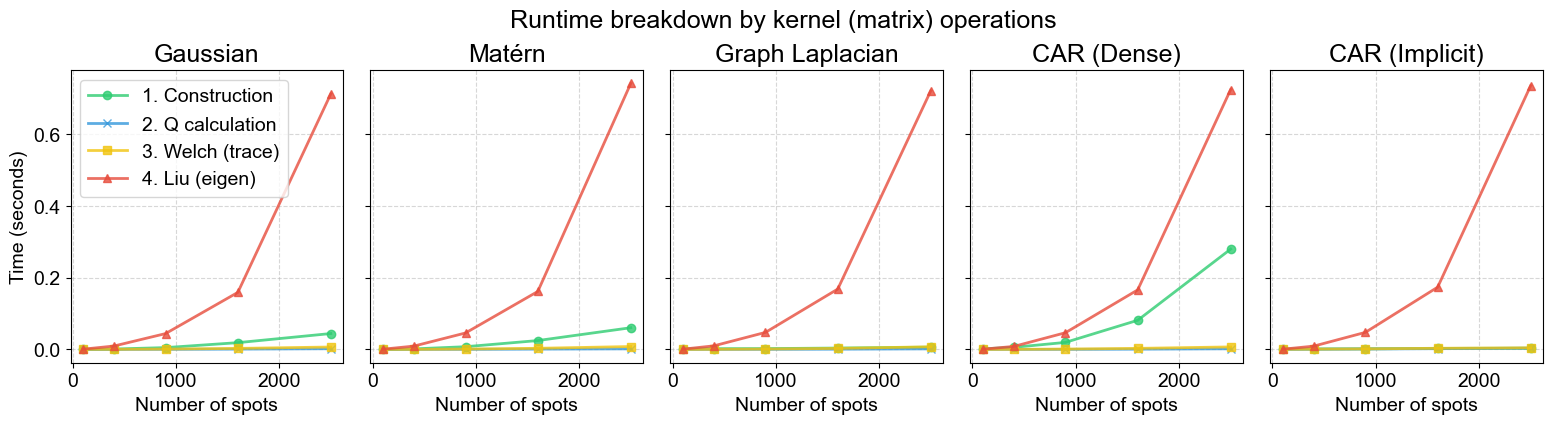

In [19]:
# --- Visualization ---
df = df_results.copy()
kernels = ['gaussian', 'matern', 'graph_laplacian', 'car', 'car_implicit']
names = ['Gaussian', 'Matérn', 'Graph Laplacian', 'CAR (Dense)', 'CAR (Implicit)']

# Changed to 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(19, 3.8), sharey=True)
plt.subplots_adjust(wspace=0.1)

styles = {
    't_construct': {'c': '#2ecc71', 'm': 'o', 'lbl': '1. Construction'},
    't_qstat':     {'c': '#3498db', 'm': 'x', 'lbl': '2. Q calculation'},
    't_welch':     {'c': '#f1c40f', 'm': 's', 'lbl': '3. Welch (trace)'},
    't_liu':       {'c': '#e74c3c', 'm': '^', 'lbl': '4. Liu (eigen)'}
}

for i, kern in enumerate(kernels):
    ax = axes[i]
    d = df[df['kernel'] == kern]
    d_mean = d.groupby('N_samples').mean(numeric_only=True).reset_index()
    
    x = d_mean['N_samples']
    
    for col, style in styles.items():
        ax.plot(x, d_mean[col], 
                marker=style['m'], 
                color=style['c'], 
                label=style['lbl'], 
                linewidth=2, 
                alpha=0.8)
        
    ax.set_title(f"{names[i]}")
    ax.set_xlabel("Number of spots")
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i == 0:
        ax.set_ylabel("Time (seconds)")
        ax.legend(loc='upper left')

plt.suptitle("Runtime breakdown by kernel (matrix) operations", fontsize = font_config['title'], y=1.04)

plt.savefig('figures/sup_matrix_time_breakdown.pdf', bbox_inches='tight')
plt.show()

### FFT spectrum accuracy

In [20]:
import numpy as np

def build_torus_knn_graph(phys_coords, grid_dims, k=6):
    """Compute KNN graph using physical coordinates."""
    phys_height, phys_width = grid_dims
    
    # 1. Compute Distance Matrix
    dist_mat = compute_torus_distance_matrix(phys_coords, (phys_height, phys_width))
    
    # 2. Build Graph (Standard KNN logic)
    np.fill_diagonal(dist_mat, np.inf)
    n = len(coords)
    W = np.zeros((n, n))
    for i in range(n):
        neighbors = np.argsort(dist_mat[i, :])[:k]
        W[i, neighbors] = 1.0
        
    # 3. Symmetrize
    W = 0.5 * (W + W.T)
    W[W > 0] = 1.0
    np.fill_diagonal(W, 0)

    return W

def get_theoretical_curve(k_type, n_points, bw, nu, rho, grid_dims, lattice_type):
    """
    Generates theoretical spectral decay.
    For Continuous Kernels (Gaussian, Matern): Uses continuous FT with density of states correction.
    For Graph Kernels (Moran, CAR): Uses analytical eigenvalues of the discrete lattice on a TORUS.
    """
    rows, cols = grid_dims
    N_total = rows * cols
    
    # --- Continuous Approximations ---
    if k_type in ['gaussian', 'matern']:
        # Map index i to wavenumber k via density of states in 2D: k ~ sqrt(i)
        L_geom = np.sqrt(N_total)
        idx = np.arange(n_points)
        
        # Avoid division by zero for the 0-th mode if necessary, though 0 is valid here
        omega = (2 * np.pi / L_geom) * np.sqrt(idx / np.pi)
        
        if k_type == 'gaussian':
            curve = np.exp(- (bw**2) * (omega**2) / 2.0)
        elif k_type == 'matern':
            curve = (1 + (bw**2) * (omega**2))**(-(nu + 1.0))
            
    # --- Discrete Lattice Theory (Torus) ---
    elif k_type in ['moran', 'car']:
        # 1. Generate Wave Vectors for Torus (Periodic BCs)
        # Indices range from 0 to N-1
        p = np.arange(0, rows)
        q = np.arange(0, cols)
        
        # Create Meshgrid of indices
        pv, qv = np.meshgrid(p, q, indexing='ij')
        
        # Convert to angular frequencies
        theta_y = 2 * np.pi * pv / rows
        theta_x = 2 * np.pi * qv / cols
        
        # 2. Calculate Eigenvalues of Adjacency Matrix
        if lattice_type in ['hex', 'hexagonal']:
            # Hexagonal (Triangular) Lattice: 6 neighbors
            # Neighbors: (1,0), (-1,0), (0,1), (0,-1), (1,-1), (-1,1)
            # Spectrum: 2cos(x) + 2cos(y) + 2cos(x-y)
            evals_adj = (2 * np.cos(theta_x) + 
                         2 * np.cos(theta_y) + 
                         2 * np.cos(theta_x - theta_y))
            degree = 6.0
            
        else: # Default to square/rect
            # Rectangular Lattice: 4 neighbors
            # Neighbors: (1,0), (-1,0), (0,1), (0,-1)
            # Spectrum: 2cos(x) + 2cos(y)
            evals_adj = 2 * np.cos(theta_x) + 2 * np.cos(theta_y)
            degree = 4.0

        evals_adj = evals_adj.flatten()
        
        # 3. Apply Spectral Transformation based on Model
        if k_type == 'moran':
            # Moran's I spectrum is simply the sorted eigenvalues of the adjacency matrix
            # (or weight matrix). We sort descending.
            curve = np.sort(evals_adj)[::-1]
            
        elif k_type == 'car':
            # CAR (Conditional Autoregressive) Model
            # Covariance Matrix Sigma = (I - rho * W)^-1
            # Eigenvalues: 1 / (1 - rho * lambda_norm)
            
            # Normalize eigenvalues by degree (Row-stochastic matrix approximation)
            evals_norm = evals_adj / degree
            
            # Calculate spectral response
            # Note: Ensure (1 - rho * evals_norm) is not zero. 
            # For a valid CAR on a grid, rho is typically < 1.
            spec = 1.0 / (1.0 - rho * evals_norm)
            
            # Sort descending (largest variance modes first)
            curve = np.sort(spec)[::-1]

        # Truncate to requested number of points
        if len(curve) > n_points:
            curve = curve[:n_points]

    else:
        curve = np.zeros(n_points)

    # --- Final Normalization ---
    # Normalize so the max absolute value is 1.0 (for plotting comparison)
    if np.max(np.abs(curve)) > 0:
        curve = curve / np.max(np.abs(curve))
        
    return curve

#### Rectangular grid

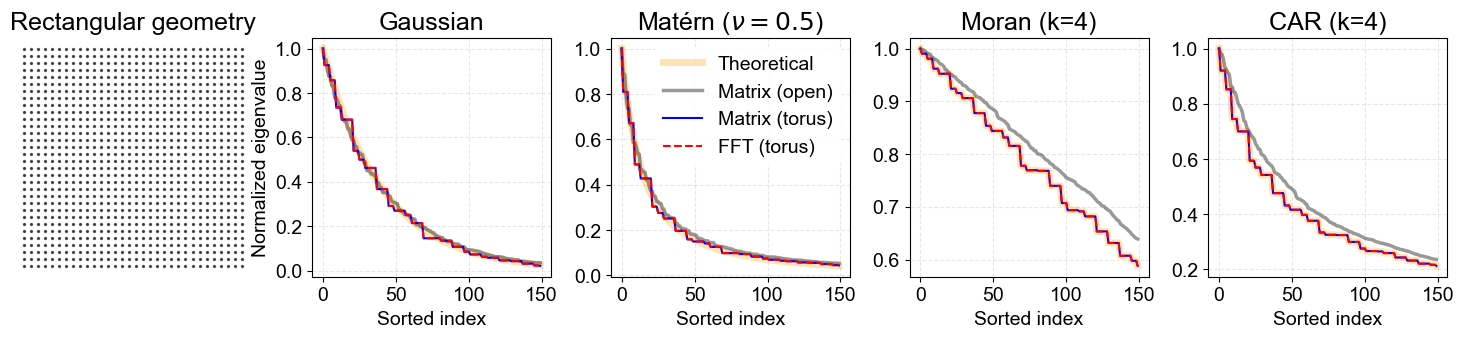

In [21]:
grid_size = 32
grid_types = ('Rectangular', 'square', get_rect_coords(grid_size, grid_size))
grid_name, topology, (coords, dims) = grid_types

kernel_types = ['gaussian', 'matern', 'moran', 'car']
kernel_names = ['Gaussian', r'Matérn ($\nu=0.5$)', 'Moran (k=4)', 'CAR (k=4)']

mtx_defaults = {
    'gaussian': {'bandwidth': 2.0},
    'matern': {'bandwidth': 2.0, 'nu': 0.5},
    'moran': {'k_neighbors': 4},
    'graph_laplacian': {'k_neighbors': 4},
    'car': {'rho': 0.9, 'k_neighbors': 4, 'standardize': False},
}
fft_defaults = {
    'gaussian': {'bandwidth': 2.0},
    'matern': {'nu': 0.5, 'bandwidth': 2.0},
    'moran': {'neighbor_degree': 1},
    'graph_laplacian': {'neighbor_degree': 1},
    'car': {'rho': 0.9, 'neighbor_degree': 1}
}

# Visualization setup (1 for geometry + 4 for kernels)
fig, axes = plt.subplots(1, 5, figsize=(18.5, 3.5))
plt.subplots_adjust(wspace=0.25)

# --- Plot Grid Geometry (Column 0) ---
ax_geo = axes[0]
ax_geo.scatter(coords[:, 0], coords[:, 1], s=2, c='black', alpha=0.6)
ax_geo.set_title(f"{grid_name} geometry")
ax_geo.set_box_aspect(1)
ax_geo.axis('off')
# ------------------------------------------

for col_idx, k_type in enumerate(kernel_types):
    # Shift spectral plots to the right by 1
    ax = axes[col_idx + 1]
    ax.set_box_aspect(1)
    
    # Common params
    bw = mtx_defaults['gaussian']['bandwidth']
    rho = mtx_defaults['car']['rho']
    nu = mtx_defaults['matern']['nu']
    k_neighbors = mtx_defaults['car']['k_neighbors']
    neighbor_degree = fft_defaults['car']['neighbor_degree']
    
    # 1. Matrix (Open)
    sk_open = SpatialKernel.from_coordinates(
        coords, method=k_type, 
        **mtx_defaults[k_type]
    )
    spec_open = np.sort(sk_open.eigenvalues())[::-1]
    
    # 2. Matrix (Torus)
    if k_type in ['gaussian', 'matern']:
        D_torus = compute_torus_distance_matrix(coords, dims)
        if k_type == 'gaussian':
            K_torus = np.exp(-D_torus**2 / (2 * bw**2))
        else: 
            D_torus[D_torus==0] = 1e-15
            fac = (np.sqrt(2 * nu) * D_torus) / bw
            K_torus = (2**(1 - nu) / gamma(nu)) * (fac**nu) * kv(nu, fac)
            np.fill_diagonal(K_torus, 1.0)
        sk_torus = SpatialKernel.from_matrix(K_torus, method=k_type)
    else: 
        W_torus = build_torus_knn_graph(coords, dims, k=k_neighbors)
        row_sums = W_torus.sum(axis=1)
        row_sums[row_sums==0] = 1
        D_inv_sqrt = np.diag(1.0 / np.sqrt(row_sums))
        W_norm = D_inv_sqrt @ W_torus @ D_inv_sqrt
        if k_type == 'moran':
            sk_torus = SpatialKernel.from_matrix(W_norm, method='moran')
        else: 
            M = np.eye(len(coords)) - rho * W_norm
            sk_torus = SpatialKernel.from_matrix(M, is_inverse=True, method='car')

    spec_torus = np.sort(sk_torus.eigenvalues())[::-1]

    # 3. FFT (Periodic)
    fft_per = FFTKernel(
        shape=dims, 
        spacing=(1.0, 1.0),
        topology=topology, 
        method=k_type,
        **fft_defaults[k_type]
    )
    spec_fft_per = np.sort(fft_per.eigenvalues(return_full=True))[::-1]

    # 4. Theoretical Curve
    limit = 150
    theo_curve = get_theoretical_curve(k_type, limit, bw, nu, rho, dims, lattice_type=topology)

    # Plotting
    def normalize(s): return s / (np.max(np.abs(s)) + 1e-9)
    
    # Plot Theoretical first (background)
    ax.plot(theo_curve, color='orange', lw=5, alpha=0.3, label='Theoretical')

    ax.plot(normalize(spec_open)[:limit], 'k-', lw=2.5, alpha=0.4, label='Matrix (open)')
    ax.plot(normalize(spec_torus)[:limit], 'b-', lw=1.5, label='Matrix (torus)')
    ax.plot(normalize(spec_fft_per)[:limit], 'r--', lw=1.5, label='FFT (torus)')
    
    ax.set_title(f"{kernel_names[col_idx]}")

    # Set grid stype
    ax.grid(True, linestyle='--', alpha=0.3)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    if col_idx == 0: ax.set_ylabel("Normalized eigenvalue")
    ax.set_xlabel("Sorted index")

# Legend Placement
# Target the Rectangular | Gaussian plot (Row 0, Col 1)
target_ax = axes[2]
handles, labels = target_ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Add legend specifically to this axis in the upper right
target_ax.legend(by_label.values(), by_label.keys(), loc='upper right', 
                 edgecolor='white', framealpha=0.9,
                 fontsize=font_config['legend'])

plt.savefig('figures/fft_rect_spectrum.pdf', bbox_inches='tight')
plt.show()

#### Hexagonal grid

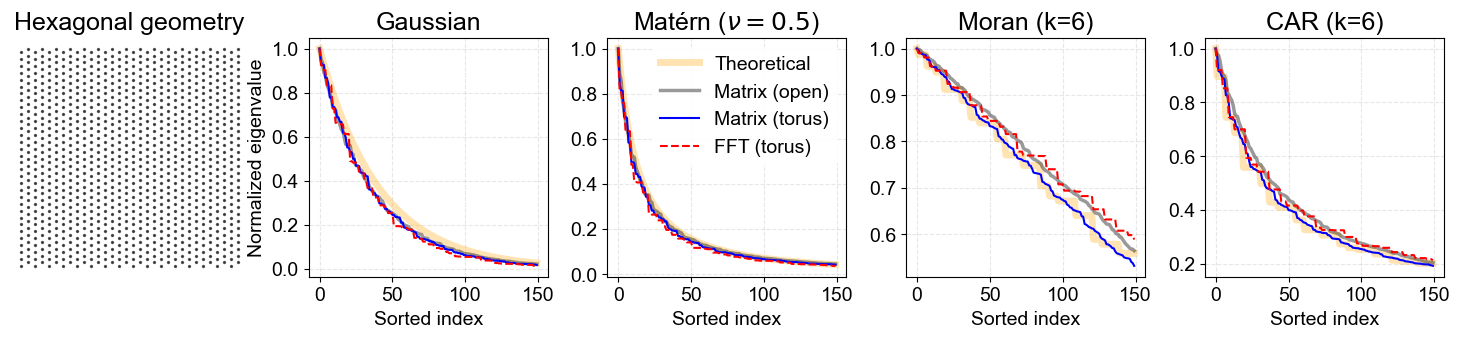

In [22]:
grid_size = 32
grid_types = ('Hexagonal', 'hex', get_visium_coords(grid_size, grid_size))
grid_name, topology, (coords, dims) = grid_types

coords = convert_visium_to_physical(coords)

kernel_types = ['gaussian', 'matern', 'moran', 'car']
kernel_names = ['Gaussian', r'Matérn ($\nu=0.5$)', 'Moran (k=6)', 'CAR (k=6)']

mtx_defaults = {
    'gaussian': {'bandwidth': 2.0},
    'matern': {'bandwidth': 2.0, 'nu': 0.5},
    'moran': {'k_neighbors': 6},
    'graph_laplacian': {'k_neighbors': 6},
    'car': {'rho': 0.9, 'k_neighbors': 6, 'standardize': False},
}
fft_defaults = {
    'gaussian': {'bandwidth': 2.0},
    'matern': {'nu': 0.5, 'bandwidth': 2.0},
    'moran': {'neighbor_degree': 1},
    'graph_laplacian': {'neighbor_degree': 1},
    'car': {'rho': 0.9, 'neighbor_degree': 1}
}

# Visualization setup (1 for geometry + 4 for kernels)
fig, axes = plt.subplots(1, 5, figsize=(18.5, 3.5))
plt.subplots_adjust(wspace=0.25)

# --- Plot Grid Geometry (Column 0) ---
ax_geo = axes[0]
ax_geo.scatter(coords[:, 0], coords[:, 1], s=2, c='black', alpha=0.6)
ax_geo.set_title(f"{grid_name} geometry")
ax_geo.axis('off')
ax_geo.set_box_aspect(1)
# ------------------------------------------

for col_idx, k_type in enumerate(kernel_types):
    # Shift spectral plots to the right by 1
    ax = axes[col_idx + 1]
    ax.set_box_aspect(1)

    # Common params
    bw = mtx_defaults['gaussian']['bandwidth']
    rho = mtx_defaults['car']['rho']
    nu = mtx_defaults['matern']['nu']
    k_neighbors = mtx_defaults['car']['k_neighbors']
    neighbor_degree = fft_defaults['car']['neighbor_degree']
    
    # 1. Matrix (Open)
    sk_open = SpatialKernel.from_coordinates(
        coords, method=k_type, 
        **mtx_defaults[k_type]
    )
    spec_open = np.sort(sk_open.eigenvalues())[::-1]
    
    # 2. Matrix (Torus)
    if k_type in ['gaussian', 'matern']:
        D_torus = compute_torus_distance_matrix(coords, dims)
        if k_type == 'gaussian':
            K_torus = np.exp(-D_torus**2 / (2 * bw**2))
        else: 
            D_torus[D_torus==0] = 1e-15
            fac = (np.sqrt(2 * nu) * D_torus) / bw
            K_torus = (2**(1 - nu) / gamma(nu)) * (fac**nu) * kv(nu, fac)
            np.fill_diagonal(K_torus, 1.0)
        sk_torus = SpatialKernel.from_matrix(K_torus, method=k_type)
    else: 
        W_torus = build_torus_knn_graph(coords, dims, k=k_neighbors)
        row_sums = W_torus.sum(axis=1)
        row_sums[row_sums==0] = 1
        D_inv_sqrt = np.diag(1.0 / np.sqrt(row_sums))
        W_norm = D_inv_sqrt @ W_torus @ D_inv_sqrt
        if k_type == 'moran':
            sk_torus = SpatialKernel.from_matrix(W_norm, method='moran')
        else: 
            M = np.eye(len(coords)) - rho * W_norm
            sk_torus = SpatialKernel.from_matrix(M, is_inverse=True, method='car')

    spec_torus = np.sort(sk_torus.eigenvalues())[::-1]

    # 3. FFT (Periodic)
    fft_per = FFTKernel(
        shape=dims, 
        spacing=(np.sqrt(3)/2, 1.0),
        topology=topology,
        method=k_type,
        **fft_defaults[k_type]
    )
    spec_fft_per = np.sort(fft_per.eigenvalues(return_full=True))[::-1]

    # 5. Theoretical Curve
    limit = 150
    theo_curve = get_theoretical_curve(k_type, limit, bw, nu, rho, dims, lattice_type=topology)

    # Plotting
    def normalize(s): return s / (np.max(np.abs(s)) + 1e-9)
    
    # Plot Theoretical first (background)
    ax.plot(theo_curve, color='orange', lw=5, alpha=0.3, label='Theoretical')

    ax.plot(normalize(spec_open)[:limit], 'k-', lw=2.5, alpha=0.4, label='Matrix (open)')
    ax.plot(normalize(spec_torus)[:limit], 'b-', lw=1.5, label='Matrix (torus)')
    ax.plot(normalize(spec_fft_per)[:limit], 'r--', lw=1.5, label='FFT (torus)')
    
    ax.set_title(f"{kernel_names[col_idx]}")

    # Set grid stype
    ax.grid(True, linestyle='--', alpha=0.3)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    if col_idx == 0: ax.set_ylabel("Normalized eigenvalue")
    ax.set_xlabel("Sorted index")

# Legend Placement
# Target the Rectangular | Gaussian plot (Row 0, Col 1)
target_ax = axes[2]
handles, labels = target_ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Add legend specifically to this axis in the upper right
target_ax.legend(by_label.values(), by_label.keys(), loc='upper right', 
                 edgecolor='white', framealpha=0.9,
                 fontsize=font_config['legend'])

plt.savefig('figures/fft_hex_spectrum.pdf', bbox_inches='tight')
plt.show()

### FFT Q and p-value accuracy

#### Visualize gene ranking

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_gene_gradient(coords, counts_list, strengths, n_panels=5):
    """
    Visualizes a subset of genes ranked by their ground truth pattern strength.
    
    Args:
        coords: (N, 2) array of physical coordinates.
        counts_list: List of (N,) count arrays (one per gene).
        strengths: List of ground truth pattern strengths corresponding to counts_list.
        n_panels: Number of subplots to generate (selecting genes evenly across the list).
    """
    n_genes = len(counts_list)
    
    # Select indices evenly spaced across the ranked list
    # e.g., if 100 genes, select indices [0, 25, 50, 75, 99]
    selected_indices = np.linspace(0, n_genes - 1, n_panels, dtype=int)
    
    fig, axes = plt.subplots(1, n_panels, figsize=(2.5 * n_panels, 3), constrained_layout=True)
    
    # Calculate marker size based on plot density
    # Heuristic: Size ~ (Figure Width / Num Points)
    marker_size = 12000 / coords.shape[0] 

    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        ax.set_box_aspect(1)
        gene_counts = counts_list[idx]
        strength = strengths[idx]
        
        # Plot
        # Using a scatter plot to simulate the hex spots
        sc = ax.scatter(
            coords[:, 0], 
            coords[:, 1], 
            c=gene_counts, 
            s=marker_size, 
            cmap='viridis', 
            edgecolors='none'
        )
        
        # Styling
        ax.set_aspect('equal')
        ax.set_title(f"Gene rank: {idx+1}/{n_genes}\nPattern strength: {strength:.2f}", fontsize=12)
        ax.axis('off')
        
        # Add a small colorbar for each to show expression scale
        # (Scales might differ between genes)
        cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

    plt.suptitle("Ground truth gene pattern (from noise to structure)", fontsize=14, y=1.05)
    plt.show()

Generating 100 genes (mean = 2.0) on a 32x32 rectangular grid...


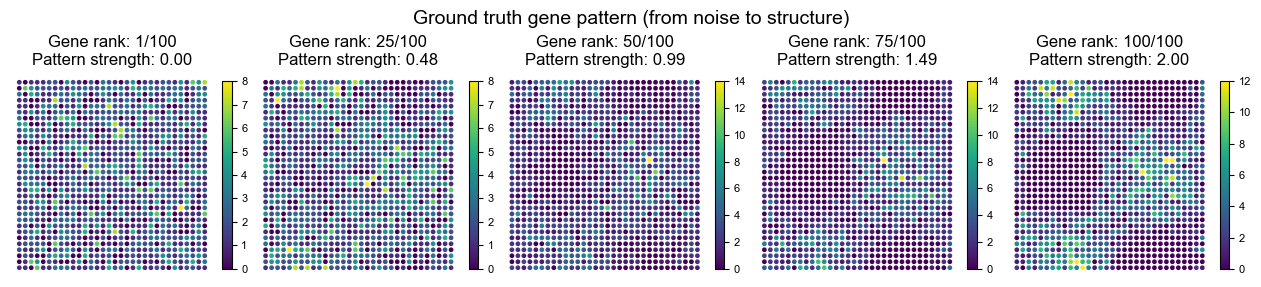

In [24]:
n_side = 32
n_genes = 100
mean_expr = 2.0
true_strengths = np.linspace(0.0, 2.0, n_genes)

np.random.seed(42)

# 1. Setup Grid
coords_phys, _ = get_rect_coords(n_side, n_side)

# 2. Generate Batch (Simulating the experiment loop)
print(f"Generating {n_genes} genes (mean = {mean_expr}) on a {n_side}x{n_side} rectangular grid...")
batch_counts = []
for strength in true_strengths:
    # Generate counts
    counts = generate_counts(coords_phys, mean_expr, pattern_strength=strength)
    batch_counts.append(counts)

# 3. Visualize
visualize_gene_gradient(coords_phys, batch_counts, true_strengths, n_panels=5)

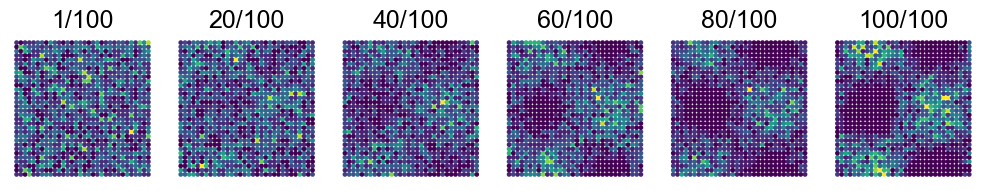

In [25]:
selected_indices = np.linspace(0, n_genes - 1, 6, dtype=int)

fig, axes = plt.subplots(1, 6, figsize=(10, 2), layout='tight')
# plt.subplots_adjust(wspace=0.05)
    
# Calculate marker size based on plot density
marker_size = 12000 / coords_phys.shape[0] 

for i, idx in enumerate(selected_indices):
    ax = axes[i]
    gene_counts = batch_counts[idx]
    ax.scatter(
        coords_phys[:, 0], 
        coords_phys[:, 1], 
        c=gene_counts, 
        s=marker_size, 
        cmap='viridis', 
        edgecolors='none'
    )
    ax.set_aspect('equal')
    ax.set_title(f"{idx+1}/{n_genes}", fontsize=font_config['title'])
    ax.axis('off')

plt.savefig('figures/sim_gene_order.pdf', bbox_inches='tight')
plt.show()

#### Rectangular grid

In [5]:
from scipy.stats import nbinom, spearmanr

# Simulation configurations
n_side = 32             # Grid size
n_reps = 50             # Number of times to repeat the whole batch experiment
n_genes_per_batch = 100  # Number of genes in one ranking comparison
means = [0.1, 0.5, 2.0] # Low, Medium, High expression

np.random.seed(42)

# Kernels to test
kernel_methods = ['gaussian', 'matern', 'moran', 'car']

# Kernel Hyperparameters
topology = 'square'
spacing = (1.0, 1.0)

mtx_defaults = {
    'gaussian': {'bandwidth': 2.0},
    'matern': {'bandwidth': 2.0, 'nu': 1.5},
    'moran': {'k_neighbors': 4},
    'graph_laplacian': {'k_neighbors': 4},
    'car': {'rho': 0.9, 'k_neighbors': 4, 'standardize': False},
}
fft_defaults = {
    'gaussian': {'bandwidth': 2.0},
    'matern': {'nu': 1.5, 'bandwidth': 2.0},
    'moran': {'neighbor_degree': 1},
    'graph_laplacian': {'neighbor_degree': 1},
    'car': {'rho': 0.9, 'neighbor_degree': 1}
}

results = []

# --- Pre-calculation ---
# Generate coords once for kernel initialization
coords_grid_units, grid_dim = get_rect_coords(n_side, n_side)

# Pre-build kernels to save computation time
kernels = {}
print("Initializing Kernels...")
for method in kernel_methods:
    # Matrix Kernel
    k_matrix = SpatialKernel.from_coordinates(
        coords_grid_units, method=method, 
        **mtx_defaults[method]
    )
    # FFT Kernel
    k_fft = FFTKernel(
        shape=(n_side, n_side), 
        spacing=spacing,
        topology=topology,
        method=method,
        **fft_defaults[method]
    )
    kernels[method] = (k_matrix, k_fft)

# --- Main Simulation Loop ---

# We define the "Ground Truth" pattern strengths for the batch
# From 0.0 (No pattern) to 2.0 (Strong pattern)
true_strengths = np.linspace(0.0, 2.0, n_genes_per_batch)

total_iterations = len(means) * n_reps
pbar = tqdm(total=total_iterations, desc="Simulating Batches")

for mu in means:
    for r in range(n_reps):
        
        # 1. Generate Data Batch
        # We generate a list of counts, one for each pattern strength
        batch_counts = []
        for strength in true_strengths:
            count_flat = generate_counts(coords_grid_units, mu, pattern_strength=strength)
            batch_counts.append(count_flat)
        
        # 2. Test every method on this batch
        for method, (k_matrix, k_fft) in kernels.items():
            
            p_vals_matrix = []
            p_vals_fft = []
            q_vals_matrix = []
            q_vals_fft = []
            
            for count_flat in batch_counts:
                # Matrix Test
                null_params = {'method': 'liu' if method != 'moran' else 'clt'}
                q_mat, p_mat = spatial_q_test(
                    count_flat, k_matrix, null_params=null_params, return_pval=True
                )
                q_vals_matrix.append(q_mat)
                p_vals_matrix.append(p_mat)
                
                # FFT Test
                q_fft, p_fft = spatial_q_test_fft(count_flat.reshape(grid_dim), k_fft, return_pval=True)
                q_vals_fft.append(q_fft)
                p_vals_fft.append(p_fft)
            
            # 3. Compute Ranking Agreement (Spearman Correlation)
            # using Q-statistic directly
            rho_mat_q = spearmanr(true_strengths, np.array(q_vals_matrix)).statistic
            rho_fft_q = spearmanr(true_strengths, np.array(q_vals_fft)).statistic

            # using pvalues
            neg_log_p_mat = -np.log10(np.array(p_vals_matrix) + 1e-300)
            neg_log_p_fft = -np.log10(np.array(p_vals_fft) + 1e-300)
            rho_mat_pval = spearmanr(true_strengths, neg_log_p_mat).statistic
            rho_fft_pval = spearmanr(true_strengths, neg_log_p_fft).statistic
            
            # Store Matrix Result
            results.append({
                'Mean': mu,
                'Method': method,
                'Approach': 'Matrix (open)',
                'Ranking_Agreement_Pval': rho_mat_pval,
                'Ranking_Agreement_Q': rho_mat_q
            })
            
            # Store FFT Result
            results.append({
                'Mean': mu,
                'Method': method,
                'Approach': 'FFT (torus)',
                'Ranking_Agreement_Pval': rho_fft_pval,
                'Ranking_Agreement_Q': rho_fft_q
            })
        
        pbar.update(1)
        
pbar.close()

df_rankings = pd.DataFrame(results)

# 1. Data Preparation
df_sub = df_rankings[df_rankings['Mean'].isin([0.1, 0.5])].copy()

# Melt to long format
df_long = df_sub.melt(
    id_vars=['Mean', 'Method', 'Approach'],
    value_vars=['Ranking_Agreement_Q', 'Ranking_Agreement_Pval'],
    var_name='Metric_Type',
    value_name='Spearman_Rho'
)

metric_map = {'Ranking_Agreement_Q': r'$Q$', 'Ranking_Agreement_Pval': r'$P$'}
df_long['Metric_Type'] = df_long['Metric_Type'].map(metric_map)

# Create Composite Hue
df_long['Condition'] = df_long['Approach'] + " (" + df_long['Metric_Type'] + ")"

# Beautify X-axis Labels (Method names)
method_names = {
    'gaussian': 'Gaussian',
    'matern': 'Matérn',
    'moran': 'Moran',
    'car': 'CAR'
}
df_long['Method'] = df_long['Method'].map(method_names)

Initializing Kernels...


Simulating Batches: 100%|█████████████████████| 150/150 [00:38<00:00,  3.90it/s]


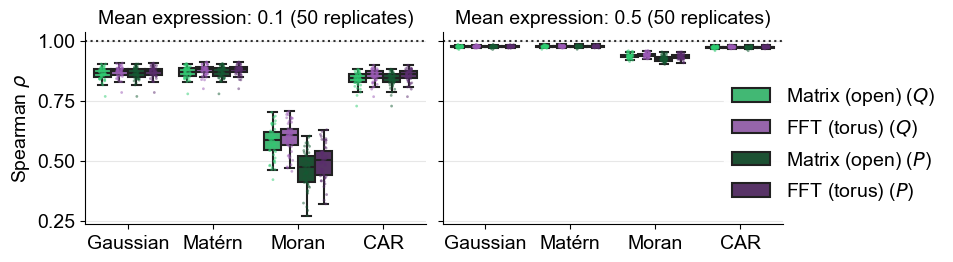

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define Palette
palette_4 = {
    r"Matrix (open) ($Q$)": "#2ecc71",   # Light Green
    r"Matrix (open) ($P$)":  "#145a32",   # Dark Green
    r"FFT (torus) ($Q$)": "#9b59b6",  # Light Purple
    r"FFT (torus) ($P$)":  "#5b2c6f"   # Dark Purple
}

# 2. Plotting Setup
# Using subplots allows exact figure size control
fig, axes = plt.subplots(1, 2, figsize=(9, 2.5), sharey=True)
plt.subplots_adjust(wspace=0.05)

means = [0.1, 0.5]

for i, mean in enumerate(means):
    ax = axes[i]
    # ax.set_box_aspect(1)
    data_subset = df_long[df_long['Mean'] == mean]
    
    # Boxplot
    sns.boxplot(
        data=data_subset, x='Method', y='Spearman_Rho', hue='Condition',
        ax=ax, palette=palette_4, showfliers=False, linewidth=1.5, width=0.8
    )
    
    # Stripplot
    sns.stripplot(
        data=data_subset, x='Method', y='Spearman_Rho', hue='Condition',
        ax=ax, palette=palette_4, alpha=0.5, size=2, jitter=0.15,
        dodge=True, legend=False
    )
    
    # Titles and Grid
    ax.set_title(f'Mean expression: {mean} ({n_reps} replicates)', fontsize=font_config['text'])
    ax.grid(axis='y', linestyle='-', alpha=0.3)
    ax.axhline(1.0, ls=':', color='black', linewidth=1.5, alpha=0.8)
    
    # Axis Styling (Black)
    ax.set_xlabel("")
    ax.tick_params(axis='x', colors='black', labelsize=font_config['tick'])
    ax.tick_params(axis='y', colors='black', labelsize=font_config['tick'])
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('black')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Remove default legend from individual plots
    if ax.get_legend():
        ax.get_legend().remove()

# 3. Y-Axis Label (only on left plot)
axes[0].set_ylabel(r"Spearman $\rho$", color='black', fontsize=font_config['label'])
axes[1].set_ylabel("")

# 4. Custom Legend inside Right Plot
# Since correlations are high in the right plot, the bottom area is empty.
handles, labels = axes[1].get_legend_handles_labels()
# We take the first 4 handles (the boxes) to avoid duplicates from stripplot
axes[1].legend(
    handles[:4], labels[:4],
    loc='lower right',    # Place inside bottom right
    bbox_to_anchor=(1.5, 0.02),
    fontsize=font_config['legend'],           # Small font to fit
    frameon=True,         # Add a box behind it so grid lines don't interfere
    framealpha=0.9,
    edgecolor='white'
)

# plt.suptitle('Gene order benchmark - Rect (100 genes, 50 replicates)', fontsize=font_config['title'], y=1.05)

plt.savefig('figures/fft_rect_gene_order.pdf', bbox_inches='tight')
plt.show()

#### Hexagonal grid

In [29]:
from scipy.stats import nbinom, spearmanr

# Simulation configurations
n_side = 32             # Grid size
n_reps = 50             # Number of times to repeat the whole batch experiment
n_genes_per_batch = 100  # Number of genes in one ranking comparison
means = [0.1, 0.5, 2.0] # Low, Medium, High expression

np.random.seed(42)

# Kernels to test
kernel_methods = ['gaussian', 'matern', 'moran', 'car']

# Kernel Hyperparameters
topology = 'hex'
spacing = (np.sqrt(3)/2, 1.0)

mtx_defaults = {
    'gaussian': {'bandwidth': 3.5},
    'matern': {'bandwidth': 3.5, 'nu': 1.5},
    'moran': {'k_neighbors': 6},
    'graph_laplacian': {'k_neighbors': 6},
    'car': {'rho': 0.9, 'k_neighbors': 6, 'standardize': False},
}
fft_defaults = {
    'gaussian': {'bandwidth': 3.5},
    'matern': {'nu': 1.5, 'bandwidth': 3.5},
    'moran': {'neighbor_degree': 1},
    'graph_laplacian': {'neighbor_degree': 1},
    'car': {'rho': 0.9, 'neighbor_degree': 1}
}


results = []

# --- Pre-calculation ---
# Generate coords once for kernel initialization
coords_grid_units, grid_dim = get_visium_coords(n_side, n_side)
coords_phys = convert_visium_to_physical(coords_grid_units)

# Pre-build kernels to save computation time
kernels = {}
print("Initializing Kernels...")
for method in kernel_methods:
    # Matrix Kernel
    k_matrix = SpatialKernel.from_coordinates(
        coords_phys, method=method, **mtx_defaults[method]
    )
    # FFT Kernel
    k_fft = FFTKernel(
        shape=(n_side, n_side), 
        spacing=spacing,
        topology=topology,
        method=method,
        **fft_defaults[method]
    )
    kernels[method] = (k_matrix, k_fft)

# --- Main Simulation Loop ---

# We define the "Ground Truth" pattern strengths for the batch
# From 0.0 (No pattern) to 2.0 (Strong pattern)
true_strengths = np.linspace(0.0, 2.0, n_genes_per_batch)

total_iterations = len(means) * n_reps
pbar = tqdm(total=total_iterations, desc="Simulating Batches")

for mu in means:
    for r in range(n_reps):
        
        # 1. Generate Data Batch
        # We generate a list of counts, one for each pattern strength
        batch_counts = []
        for strength in true_strengths:
            count_flat = generate_counts(coords_phys, mu, pattern_strength=strength)
            batch_counts.append(count_flat)
        
        # 2. Test every method on this batch
        for method, (k_matrix, k_fft) in kernels.items():
            
            p_vals_matrix = []
            p_vals_fft = []
            q_vals_matrix = []
            q_vals_fft = []
            
            for count_flat in batch_counts:
                # Matrix Test
                null_params = {'method': 'liu' if method != 'moran' else 'clt'}
                q_mat, p_mat = spatial_q_test(
                    count_flat, k_matrix, null_params=null_params, return_pval=True
                )
                q_vals_matrix.append(q_mat)
                p_vals_matrix.append(p_mat)
                
                # FFT Test
                q_fft, p_fft = spatial_q_test_fft(count_flat.reshape(grid_dim), k_fft, return_pval=True)
                q_vals_fft.append(q_fft)
                p_vals_fft.append(p_fft)
            
            # 3. Compute Ranking Agreement (Spearman Correlation)
            # using Q-statistic directly
            rho_mat_q = spearmanr(true_strengths, np.array(q_vals_matrix)).statistic
            rho_fft_q = spearmanr(true_strengths, np.array(q_vals_fft)).statistic

            # using pvalues
            neg_log_p_mat = -np.log10(np.array(p_vals_matrix) + 1e-300)
            neg_log_p_fft = -np.log10(np.array(p_vals_fft) + 1e-300)
            rho_mat_pval = spearmanr(true_strengths, neg_log_p_mat).statistic
            rho_fft_pval = spearmanr(true_strengths, neg_log_p_fft).statistic
            
            # Store Matrix Result
            results.append({
                'Mean': mu,
                'Method': method,
                'Approach': 'Matrix (open)',
                'Ranking_Agreement_Pval': rho_mat_pval,
                'Ranking_Agreement_Q': rho_mat_q
            })
            
            # Store FFT Result
            results.append({
                'Mean': mu,
                'Method': method,
                'Approach': 'FFT (periodic)',
                'Ranking_Agreement_Pval': rho_fft_pval,
                'Ranking_Agreement_Q': rho_fft_q
            })
        
        pbar.update(1)
        
pbar.close()

df_rankings = pd.DataFrame(results)

# 1. Data Preparation
df_sub = df_rankings[df_rankings['Mean'].isin([0.1, 0.5])].copy()

# Melt to long format
df_long = df_sub.melt(
    id_vars=['Mean', 'Method', 'Approach'],
    value_vars=['Ranking_Agreement_Q', 'Ranking_Agreement_Pval'],
    var_name='Metric_Type',
    value_name='Spearman_Rho'
)

metric_map = {'Ranking_Agreement_Q': r'$Q$', 'Ranking_Agreement_Pval': r'$P$'}
df_long['Metric_Type'] = df_long['Metric_Type'].map(metric_map)

# Create Composite Hue
df_long['Condition'] = df_long['Approach'] + " (" + df_long['Metric_Type'] + ")"

# Beautify X-axis Labels (Method names)
method_names = {
    'gaussian': 'Gaussian',
    'matern': 'Matérn',
    'moran': 'Moran',
    'car': 'CAR'
}
df_long['Method'] = df_long['Method'].map(method_names)

Initializing Kernels...


Simulating Batches: 100%|█████████████████████| 150/150 [00:25<00:00,  5.94it/s]


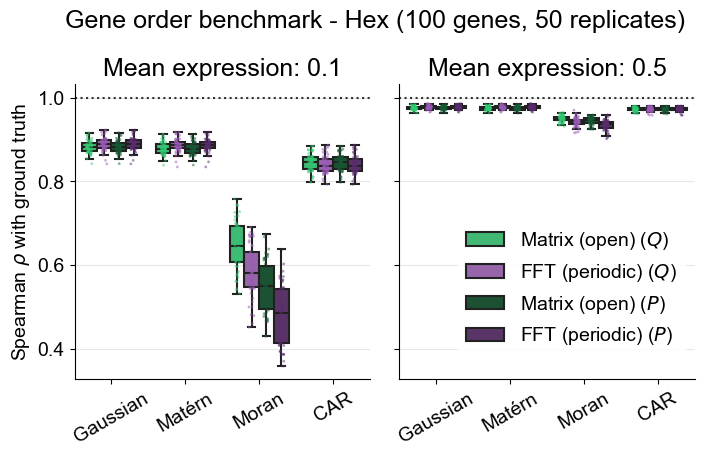

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define Palette
palette_4 = {
    r"Matrix (open) ($Q$)": "#2ecc71",   # Light Green
    r"Matrix (open) ($P$)":  "#145a32",   # Dark Green
    r"FFT (periodic) ($Q$)": "#9b59b6",  # Light Purple
    r"FFT (periodic) ($P$)":  "#5b2c6f"   # Dark Purple
}

# 2. Plotting Setup
# Using subplots allows exact figure size control
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plt.subplots_adjust(wspace=0.1)

means = [0.1, 0.5]

for i, mean in enumerate(means):
    ax = axes[i]
    ax.set_box_aspect(1)
    data_subset = df_long[df_long['Mean'] == mean]
    
    # Boxplot
    sns.boxplot(
        data=data_subset, x='Method', y='Spearman_Rho', hue='Condition',
        ax=ax, palette=palette_4, showfliers=False, linewidth=1.5, width=0.8
    )
    
    # Stripplot
    sns.stripplot(
        data=data_subset, x='Method', y='Spearman_Rho', hue='Condition',
        ax=ax, palette=palette_4, alpha=0.5, size=2, jitter=0.15,
        dodge=True, legend=False
    )
    
    # Titles and Grid
    ax.set_title(f'Mean expression: {mean}', fontsize=font_config['title'])
    ax.grid(axis='y', linestyle='-', alpha=0.3)
    ax.axhline(1.0, ls=':', color='black', linewidth=1.5, alpha=0.8)
    
    # Axis Styling (Black)
    ax.set_xlabel("")
    ax.tick_params(axis='x', colors='black', labelsize=font_config['tick'], rotation = 30)
    ax.tick_params(axis='y', colors='black', labelsize=font_config['tick'])
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('black')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Remove default legend from individual plots
    if ax.get_legend():
        ax.get_legend().remove()

# 3. Y-Axis Label (only on left plot)
axes[0].set_ylabel(r"Spearman $\rho$ with ground truth", color='black', fontsize=font_config['label'])
axes[1].set_ylabel("")

# 4. Custom Legend inside Right Plot
# Since correlations are high in the right plot, the bottom area is empty.
handles, labels = axes[1].get_legend_handles_labels()
# We take the first 4 handles (the boxes) to avoid duplicates from stripplot
axes[1].legend(
    handles[:4], labels[:4],
    loc='lower right',    # Place inside bottom right
    bbox_to_anchor=(1, 0.05),
    fontsize=font_config['legend'],           # Small font to fit
    frameon=True,         # Add a box behind it so grid lines don't interfere
    framealpha=0.9,
    edgecolor='white'
)

plt.suptitle('Gene order benchmark - Hex (100 genes, 50 replicates)', fontsize=font_config['title'], y=1.05)

plt.savefig('figures/fft_hex_gene_order.pdf', bbox_inches='tight')
plt.show()

### FFT runtime and memory

#### Run experiments

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
from scipy.stats import nbinom
from tqdm import tqdm

# --- Configuration ---
np.random.seed(42)

# Grid sizes: From 32x32 (1k) to ~2000x2000 (4M)
side_lengths = [32, 48, 64, 72, 80, 96, 128, 256, 350, 512, 1024, 2048] 

# Matrix Method Safety Cutoff
# 12,000^2 * 8 bytes is ~1.1 GB. 
# 15,000^2 * 8 bytes is ~1.8 GB.
# We cut off early to prevent system freeze during replicates.
MATRIX_N_LIMIT = 12500

# threshold for Inv Graph Laplacian to start using sparse representation
SPARSE_THRESHOLD = 5000
IGL_N_LIMIT = 300000

N_REPLICATES = 5
KERNELS_TO_TEST = ['gaussian', 'matern', 'moran', 'car']
kernel_names = ['Gaussian', 'Matérn', 'Moran', 'CAR']

# --- Helper Functions ---
def generate_random_counts(n_spots, mean=0.5):
    n_param = 1.0 / 0.1 
    p_param = 1.0 / (1.0 + mean * 0.1)
    return nbinom.rvs(n_param, p_param, size=n_spots)

# --- Main Simulation ---

results = []

# Total iterations for progress bar
total_ops = len(side_lengths) * N_REPLICATES * len(KERNELS_TO_TEST)
pbar = tqdm(total=total_ops, desc="Benchmarking")

for side in side_lengths:
    n_spots = side * side
    grid_dim = (side, side)
    
    # Generate geometry once per size
    coords, _ = get_rect_coords(side, side)
    
    for rep in range(N_REPLICATES):
        # New random data per replicate
        counts = generate_random_counts(n_spots)
        
        for method, name in zip(KERNELS_TO_TEST, kernel_names):
            
            # --- 1. Matrix Approach (Open, Welch) ---
            limit = IGL_N_LIMIT if method in ['moran', 'car'] else MATRIX_N_LIMIT
            if n_spots <= limit:
                try:
                    tracemalloc.start()
                    t0 = time.perf_counter()
                    
                    # Build Dense Kernel
                    # Note: For inv_laplacian, this implies inverting the Laplacian matrix
                    k_matrix = SpatialKernel.from_coordinates(
                        coords, method=method
                    )
                    
                    # Run Test
                    spatial_q_test(
                        counts, k_matrix, 
                        null_params={'method': 'clt' if method == 'moran' else 'welch'}, 
                        return_pval=True
                    )
                    
                    t1 = time.perf_counter()
                    _, peak = tracemalloc.get_traced_memory()
                    tracemalloc.stop()
                    
                    results.append({
                        'N_Spots': n_spots,
                        'Kernel': name,
                        'Approach': 'Matrix (trace)',
                        'Time_s': t1 - t0,
                        'Memory_MB': peak / (1024**2)
                    })
                except Exception as e:
                    tracemalloc.stop()
                    # If it fails (e.g. singular matrix), we skip recording
                    pass
            
            # --- 2. FFT Approach (Periodic, Liu) ---
            try:
                tracemalloc.start()
                t0 = time.perf_counter()
                
                # Build FFT Kernel
                k_fft = FFTKernel(
                    shape=grid_dim, 
                    spacing=(1.0, 1.0),
                    topology='square',
                    method=method,
                    fft_solver='fft2',
                )
                
                # Run Test
                spatial_q_test_fft(
                    counts.reshape(grid_dim), k_fft, 
                    return_pval=True
                )
                
                t1 = time.perf_counter()
                _, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                
                results.append({
                    'N_Spots': n_spots,
                    'Kernel': name,
                    'Approach': 'FFT (Liu)',
                    'Time_s': t1 - t0,
                    'Memory_MB': peak / (1024**2)
                })
            except Exception as e:
                tracemalloc.stop()
                print(f"FFT Error: {e}")

            pbar.update(1)

pbar.close()

df_runtime = pd.DataFrame(results)
df_runtime['Method_Type'] = df_runtime['Approach'].apply(lambda x: 'Matrix' if 'Matrix' in x else 'FFT')

Benchmarking: 100%|███████████████████████████| 240/240 [02:07<00:00,  1.88it/s]


#### Save and reload results

In [33]:
# Save and reload results
df_runtime.to_csv('results/fft_runtime_memory.csv', index=False)

# # reload results
# df_runtime = pd.read_csv('results/fft_runtime_memory.csv')

#### Visualization

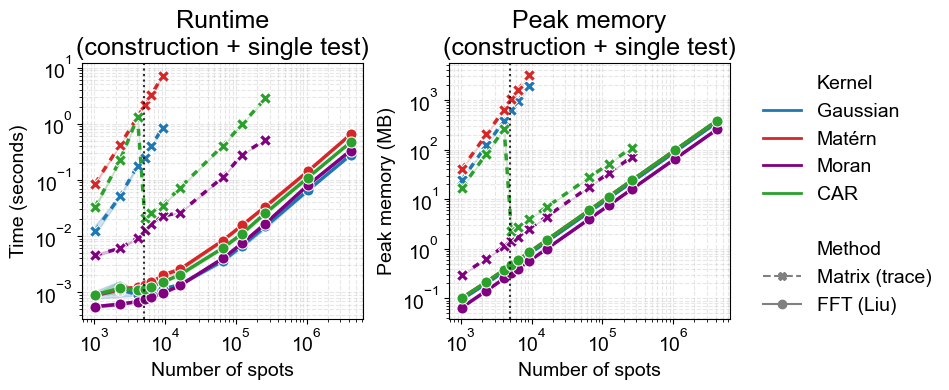

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# --- Plotting Configuration ---
# Keeping the requested figure size
fig, axes = plt.subplots(1, 2, figsize=(7.5, 4))

# threshold for Inv Graph Laplacian to start using sparse representation
SPARSE_THRESHOLD = 5000

# Define color palette for Kernels
kernel_palette = {
    'Gaussian': '#1f77b4',       # Blue
    'Matérn': '#d62728',         # Red
    'Moran': 'purple',
    'CAR': '#2ca02c'   # Green
}

# Define style mapping for Methods
method_styles = {
    'FFT': (1, 0),        # Solid
    'Matrix': (2, 2)      # Dashed
}
method_markers = {
    'FFT': 'o',
    'Matrix': 'X'
}

# --- Panel 1: Runtime ---
ax_time = axes[0]
# ax_time.set_box_aspect(1)
sns.lineplot(
    data=df_runtime, 
    x='N_Spots', 
    y='Time_s', 
    hue='Kernel', 
    style='Method_Type',
    palette=kernel_palette,
    dashes=method_styles,
    markers=method_markers,
    markersize=8,
    linewidth=2.5,
    ax=ax_time
)

ax_time.set_xscale('log')
ax_time.set_yscale('log')
ax_time.set_title('Runtime\n(construction + single test)')
ax_time.set_xlabel('Number of spots')
ax_time.set_ylabel('Time (seconds)')
ax_time.grid(True, which="both", ls="--", alpha=0.3)
ax_time.axvline(SPARSE_THRESHOLD, ls=':', color='black', linewidth=1.5, alpha=0.8)
for spine in ax_time.spines.values():
    spine.set_edgecolor('black')

# --- Panel 2: Memory ---
ax_mem = axes[1]
# ax_mem.set_box_aspect(1)
sns.lineplot(
    data=df_runtime, 
    x='N_Spots', 
    y='Memory_MB', 
    hue='Kernel', 
    style='Method_Type',
    palette=kernel_palette,
    dashes=method_styles,
    markers=method_markers,
    markersize=8,
    linewidth=2.5,
    ax=ax_mem
)

ax_mem.set_xscale('log')
ax_mem.set_yscale('log')
ax_mem.set_title('Peak memory\n(construction + single test)')
ax_mem.set_xlabel('Number of spots')
ax_mem.set_ylabel('Peak memory (MB)')
ax_mem.grid(True, which="both", ls="--", alpha=0.3)
ax_mem.axvline(SPARSE_THRESHOLD, ls=':', color='black', linewidth=1.5, alpha=0.8)
for spine in ax_mem.spines.values():
    spine.set_edgecolor('black')

# --- Legend Handling ---
ax_time.get_legend().remove()
ax_mem.get_legend().remove()

legend_elements = [
    # Header for Kernels
    Line2D([0], [0], color='w', label='Kernel'),
    Line2D([0], [0], color=kernel_palette['Gaussian'], lw=2, label='Gaussian'),
    Line2D([0], [0], color=kernel_palette['Matérn'], lw=2, label='Matérn'),
    Line2D([0], [0], color=kernel_palette['Moran'], lw=2, label='Moran'),
    Line2D([0], [0], color=kernel_palette['CAR'], lw=2, label='CAR'),
    
    # Spacer
    Line2D([0], [0], color='w', label=''),
    
    # Header for Methods
    Line2D([0], [0], color='w', label='Method'),
    Line2D([0], [0], color='gray', linestyle='--', marker='X', label='Matrix (trace)'),
    Line2D([0], [0], color='gray', linestyle='-', marker='o', label='FFT (Liu)'),
]

# Adjusted legend position: bbox_to_anchor moves it to the right, ncol=1 makes it a column
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)

plt.tight_layout()
plt.savefig('figures/fft_runtime_memory.pdf', bbox_inches='tight')
plt.show()

## Application on Visium HD mouse small intestine data

Here we follow the [tutorial from SpatialData](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/technology_visium_hd.html). Data source: 
* [Visium HD Spatial Gene Expression Library, Mouse Small Intestine (FFPE) from 10x].(https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine)
* The preprocessed zarr file, from SpatialData, [can be downloaded here](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_hd_3.0.0_io.zip).

### Load data using SpatialData

In [8]:
import spatialdata as sd
import spatialdata_plot
from spatialdata import rasterize_bins

import quadsv
from quadsv.kernels import SpatialKernel
from quadsv.statistics import spatial_q_test
from quadsv.fft import FFTKernel, spatial_q_test_fft
from quadsv.detector_fft import PatternDetectorFFT

sdata = sd.read_zarr('data/visium_hd_mouse_intestine.zarr/')
sdata

/Users/jysumac/miniforge3/envs/cassiopeia/lib/python3.14/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/jysumac/miniforge3/envs/cassiopeia/lib/python3.14/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_47314/1544237398.py:11: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new loc

SpatialData object, with associated Zarr store: /Users/jysumac/Projects/EquivSVT/data/visium_hd_mouse_intestine.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': DataArray[cyx] (3, 3000, 3198)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (91033, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (5479660, 19059)
      ├── 'square_008um': AnnData (351817, 19059)
      └── 'square_

In [9]:
for bin_size in ["016", "008"]:
    # rasterize_bins() requires a compresed sparse column (csc) matrix
    sdata.tables[f"square_{bin_size}um"].X = sdata.tables[f"square_{bin_size}um"].X.tocsc()
    rasterized = rasterize_bins(
        sdata,
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size}um",
        f"square_{bin_size}um",
        "array_col",
        "array_row",
    )
    sdata[f"rasterized_{bin_size}um"] = rasterized

INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_hires' since it doesn't have       
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_lowres' since it doesn't have      
         relevant elements.                                                                                        


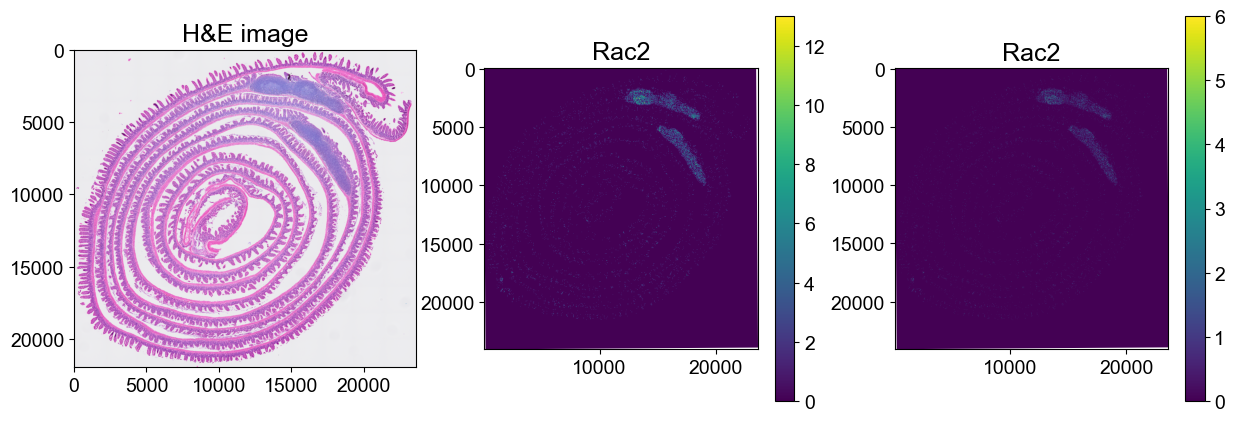

In [10]:
axes = plt.subplots(1, 3, figsize=(15, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(
    ax=axes[0], title="H&E image"
)
# gene_name = 'Reg3b'
gene_name = 'Rac2'
sdata.pl.render_images("rasterized_016um", channel=gene_name, scale="full").pl.show(
    coordinate_systems="Visium_HD_Mouse_Small_Intestine", ax=axes[1], title=gene_name
)
sdata.pl.render_images("rasterized_008um", channel=gene_name, scale="full").pl.show(
    coordinate_systems="Visium_HD_Mouse_Small_Intestine", ax=axes[2], title=gene_name
)

INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_hires' since it doesn't have       
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_lowres' since it doesn't have      
         relevant elements.                                                                                        


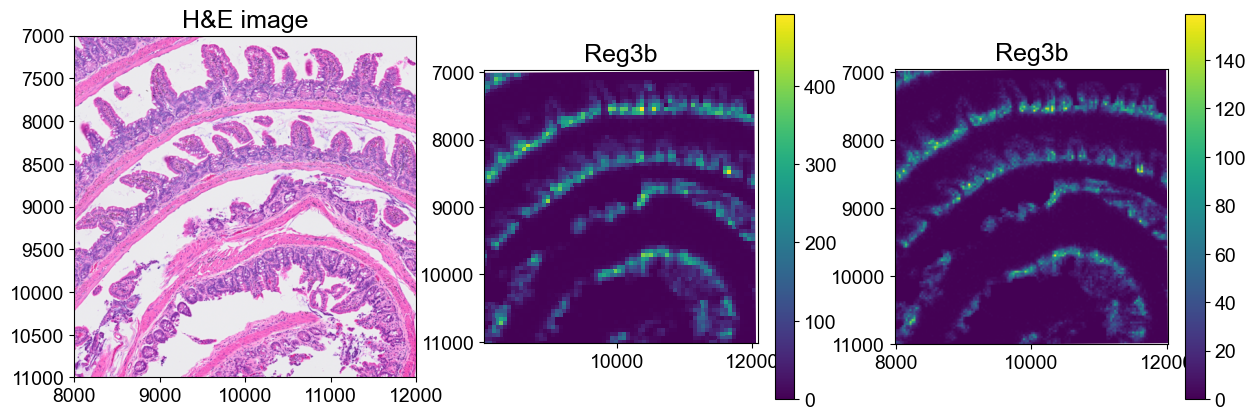

In [11]:
sdata_small = sdata.query.bounding_box(
    min_coordinate=[8000, 7000],
    max_coordinate=[12000, 11000],
    axes=("x", "y"),
    target_coordinate_system="Visium_HD_Mouse_Small_Intestine",
)

axes = plt.subplots(1, 3, figsize=(15, 5))[1].flatten()
sdata_small.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(
    ax=axes[0], title="H&E image"
)
gene_name = 'Reg3b'
sdata_small.pl.render_images("rasterized_016um", channel=gene_name, scale="full").pl.show(
    coordinate_systems="Visium_HD_Mouse_Small_Intestine", ax=axes[1], title=gene_name
)
sdata_small.pl.render_images("rasterized_008um", channel=gene_name, scale="full").pl.show(
    coordinate_systems="Visium_HD_Mouse_Small_Intestine", ax=axes[2], title=gene_name
)

### FFT spatial variability test

#### Compare kernels and resolutions

In [7]:
kernel_methods = ['gaussian', 'matern', 'moran', 'car']
resolutions = ['016um', '008um']
results = {}

for res in resolutions:
    # Construct dynamic bin and table names based on the prompt's pattern
    # Note: Adjust the f-string format if your actual object keys differ slightly
    bin_key = f'Visium_HD_Mouse_Small_Intestine_square_{res}'
    table_key = f'square_{res}'
    
    for kernel in kernel_methods:
        print(f"Processing: Resolution={res}, Kernel={kernel}")
        
        # Initialize detector with specific kernel
        pt = PatternDetectorFFT(
            sdata=sdata,
            min_count=10,
            kernel_method=kernel,
            fft_solver='rfft2'
        )
        
        # Compute Q-statistics
        try:
            df_res = pt.compute_qstat(
                bins=bin_key,
                table_name=table_key, 
                col_key='array_col', 
                row_key='array_row',
                features=None, 
                n_jobs=4,
                workers=2,
                return_pval=True, 
                chunk_size=256
            )
            # Store only necessary columns to save memory
            results[(kernel, res)] = df_res
        except Exception as e:
            print(f"Failed for {kernel} at {res}: {e}")

Processing: Resolution=016um, Kernel=gaussian
Rasterizing square_016um into rasterized_square_016um...
Building FFTKernel (gaussian) for grid shape (412, 400)...
Processing 18626 features in 73 batches using 4 cores...


Q (gaussian): 100%|██████████████████████████████| 73/73 [00:59<00:00,  1.22it/s


Processing: Resolution=016um, Kernel=matern
Rasterizing square_016um into rasterized_square_016um...
Building FFTKernel (matern) for grid shape (412, 400)...
Processing 18626 features in 73 batches using 4 cores...


Q (matern): 100%|██████████████████████████████| 73/73 [01:05<00:00,  1.12it/s] 


Processing: Resolution=016um, Kernel=moran
Rasterizing square_016um into rasterized_square_016um...
Building FFTKernel (moran) for grid shape (412, 400)...
Processing 18626 features in 73 batches using 4 cores...


Q (moran): 100%|██████████████████████████████| 73/73 [00:48<00:00,  1.50it/s]  


Processing: Resolution=016um, Kernel=car
Rasterizing square_016um into rasterized_square_016um...
Building FFTKernel (car) for grid shape (412, 400)...
Processing 18626 features in 73 batches using 4 cores...


Q (car): 100%|██████████████████████████████| 73/73 [01:04<00:00,  1.14it/s]    


Processing: Resolution=008um, Kernel=gaussian
Rasterizing square_008um into rasterized_square_008um...
Building FFTKernel (gaussian) for grid shape (822, 799)...
Processing 18619 features in 73 batches using 4 cores...


Q (gaussian): 100%|██████████████████████████████| 73/73 [05:26<00:00,  4.47s/it


Processing: Resolution=008um, Kernel=matern
Rasterizing square_008um into rasterized_square_008um...
Building FFTKernel (matern) for grid shape (822, 799)...
Processing 18619 features in 73 batches using 4 cores...


Q (matern): 100%|██████████████████████████████| 73/73 [05:39<00:00,  4.65s/it] 


Processing: Resolution=008um, Kernel=moran
Rasterizing square_008um into rasterized_square_008um...
Building FFTKernel (moran) for grid shape (822, 799)...
Processing 18619 features in 73 batches using 4 cores...


Q (moran): 100%|██████████████████████████████| 73/73 [04:01<00:00,  3.30s/it]  


Processing: Resolution=008um, Kernel=car
Rasterizing square_008um into rasterized_square_008um...
Building FFTKernel (car) for grid shape (822, 799)...
Processing 18619 features in 73 batches using 4 cores...


Q (car): 100%|██████████████████████████████| 73/73 [05:59<00:00,  4.93s/it]    


#### Save and reload test results

In [12]:
import os
import pandas as pd

def save_results(results_dict, directory):
    """
    Saves a dictionary of {(kernel, res): DataFrame} to CSV files.
    """
    # Create the directory if it doesn't exist
    # Note: 'ensure_directory' from the provided pkg_resources text 
    # could theoretically be used here, but os.makedirs is standard.
    os.makedirs(directory, exist_ok=True)
    
    print(f"Saving results to '{directory}/'...")
    
    for (kernel, res), df in results_dict.items():
        # Construct a filename that encodes the key information
        filename = f"qstat_{kernel}_{res}.csv"
        filepath = os.path.join(directory, filename)
        
        # Save to CSV (index=True is usually important for statistical results)
        df.to_csv(filepath, index=True)
        print(f"  Saved: {filename}")

def load_results(directory, kernels, res_list):
    """
    Reloads CSV files back into a dictionary with structure {(kernel, res): DataFrame}.
    """
    loaded_dict = {}
    print(f"\nReloading results from '{directory}/'...")
    
    for res in res_list:
        for kernel in kernels:
            filename = f"qstat_{kernel}_{res}.csv"
            filepath = os.path.join(directory, filename)
            
            if os.path.exists(filepath):
                # Read the CSV back in. 
                # index_col=0 assumes the first column was the index (e.g., gene names or bins)
                df = pd.read_csv(filepath, index_col=0)
                loaded_dict[(kernel, res)] = df
                print(f"  Loaded: {filename}")
            else:
                print(f"  Warning: File not found for {kernel} at {res}")
                
    return loaded_dict

In [9]:
# save test results
output_dir = 'results/visium_hd_intestine/'
save_results(results, output_dir)

Saving results to 'results/visium_hd_intestine//'...
  Saved: qstat_gaussian_016um.csv
  Saved: qstat_matern_016um.csv
  Saved: qstat_moran_016um.csv
  Saved: qstat_car_016um.csv
  Saved: qstat_gaussian_008um.csv
  Saved: qstat_matern_008um.csv
  Saved: qstat_moran_008um.csv
  Saved: qstat_car_008um.csv


In [13]:
# load precomputed results
output_dir = 'results/visium_hd_intestine/'
kernel_methods = ['gaussian', 'matern', 'moran', 'car']
resolutions = ['016um', '008um']

results = load_results(output_dir, kernel_methods, resolutions)


Reloading results from 'results/visium_hd_intestine//'...
  Loaded: qstat_gaussian_016um.csv
  Loaded: qstat_matern_016um.csv
  Loaded: qstat_moran_016um.csv
  Loaded: qstat_car_016um.csv
  Loaded: qstat_gaussian_008um.csv
  Loaded: qstat_matern_008um.csv
  Loaded: qstat_moran_008um.csv
  Loaded: qstat_car_008um.csv


### Visualization

#### Test results

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from adjustText import adjust_text
from mpl_toolkits.axes_grid1 import make_axes_locatable

kernels = ['gaussian', 'matern', 'moran', 'car']
names = ['Gaussian', 'Matérn', 'Moran', 'CAR']
res_keys = ['016um', '008um']
res_legend = ['16um (412, 400)', '8um (822, 799)']
res_axis = ['16um', '8um']

# --- Helper Function ---
def get_spearman(df1, df2, n=2000):
    """Calculate Spearman correlation on the union of top n genes."""
    top1 = df1.nlargest(n, 'Z_score').index
    top2 = df2.nlargest(n, 'Z_score').index
    common = top1.union(top2).intersection(df1.index).intersection(df2.index)
    if len(common) < 2: return np.nan
    return spearmanr(df1.loc[common, 'Z_score'], df2.loc[common, 'Z_score'])[0]

# --- Data Preparation ---
# 1. Bar Plot Data
bar_data = []
for r_key, r_lbl in zip(res_keys, res_legend):
    for k, name in zip(kernels, names):
        if (k, r_key) in results:
            df = results[(k, r_key)]
            count = (df['P_adj'] < 0.01).sum()
            bar_data.append({'Kernel': name, 'Count': count, 'Resolution': r_lbl})
df_bar = pd.DataFrame(bar_data)

# 2. Heatmap Data
n_k = len(kernels)
corr_mat = np.zeros((n_k, n_k))
for i in range(n_k):
    for j in range(n_k):
        if i == j: corr_mat[i, j] = np.nan
        elif i > j: # Lower: 16um
            corr_mat[i, j] = get_spearman(results[(kernels[i], res_keys[0])], results[(kernels[j], res_keys[0])])
        else:       # Upper: 8um
            corr_mat[i, j] = get_spearman(results[(kernels[i], res_keys[1])], results[(kernels[j], res_keys[1])])

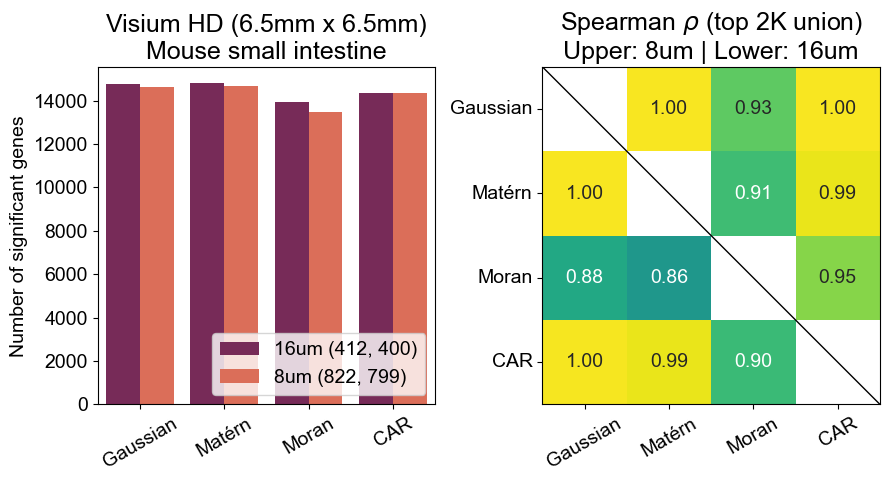

In [12]:
# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))
plt.subplots_adjust(wspace=0.35)

# Panel A: Bar Plot
sns.barplot(data=df_bar, x='Kernel', y='Count', hue='Resolution', ax=axes[0], palette='rocket')
axes[0].set_title('Visium HD (6.5mm x 6.5mm)\nMouse small intestine', fontsize=font_config['title'])
axes[0].set_ylabel('Number of significant genes')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend(loc='lower right')
axes[0].set_box_aspect(1)

# Panel B: Heatmap
# Use make_axes_locatable to append colorbar without shrinking the heatmap axis
# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes("right", size="5%", pad=0.1)

sns.heatmap(
    corr_mat, annot=True, fmt=".2f", cmap='viridis',
    xticklabels=names, yticklabels=names, vmin=0.7, vmax=1.0, 
    ax=axes[1], annot_kws={"size": font_config['text']},
    # cbar_ax=cax, cbar_kws={'label': r'Spearman $\rho$ (top 2K union)'},
    cbar = False
)
axes[1].plot([0, n_k], [0, n_k], 'k-', lw=1)
axes[1].set_title(r"Spearman $\rho$ (top 2K union)" + "\n" + \
                  f'Upper: {res_axis[1]} | Lower: {res_axis[0]}', fontsize=font_config['title'])
axes[1].tick_params(axis='x', rotation=30)
axes[1].tick_params(axis='y', rotation=0)
axes[1].set_box_aspect(1)
for _, spine in axes[1].spines.items():
    spine.set_visible(True)

plt.tight_layout()
plt.savefig('figures/visium_hd_four_kernels.pdf', bbox_inches='tight')
plt.show()

#### Moran vs CAR

In [15]:
df_merge = pd.merge(
    results[('moran', '016um')],
    results[('car', '016um')],
    how='inner', left_index=True, right_index=True,
    suffixes=['_Moran', '_CAR']
)
df_merge['I_Moran'] = df_merge['Q_Moran'] / (412 * 400)
df_merge['I_CAR'] = df_merge['Q_CAR'] / (412 * 400)
df_merge['mean_expr'] = sdata.tables['square_016um'][:, df_merge.index].X.mean(axis=0).T

df_merge.head()

Q_Moran  P_value_Moran  Z_score_Moran  P_adj_Moran  \
Feature                                                             
Ighd     131205.593656            0.0     457.076344          0.0   
Cd74     128828.393564            0.0     448.794975          0.0   
Reg3b    128156.353834            0.0     446.453814          0.0   
Krt19    127408.410125            0.0     443.848228          0.0   
Krt8     127251.095606            0.0     443.300197          0.0   

                Q_CAR  P_value_CAR  Z_score_CAR  P_adj_CAR   I_Moran  \
Feature                                                                
Ighd     1.223120e+06          0.0   864.902765        0.0  0.796150   
Cd74     1.117154e+06          0.0   771.748334        0.0  0.781726   
Reg3b    9.282338e+05          0.0   605.669721        0.0  0.777648   
Krt19    9.091969e+05          0.0   588.934512        0.0  0.773109   
Krt8     9.522878e+05          0.0   626.815438        0.0  0.772155   

            I_CAR  mean_expr  
Feature                       
Ighd     7.421847   0.189249  
Cd74     6.778847   5.937210  
Reg3b    5.632487  28.962477  
Krt19    5.516972   5.790703  
Krt8     5.778445   9.044941

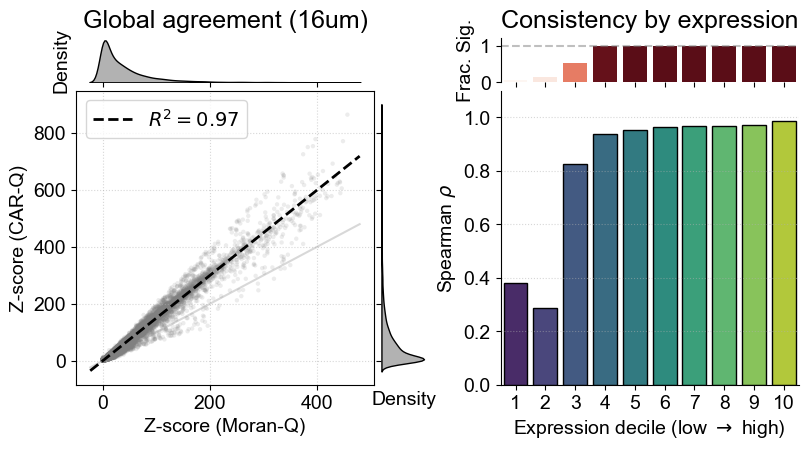

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# 1. Prepare Data
# A. Group Data for Right Panel (10 bins by mean expression)
df_merge['decile'] = pd.qcut(df_merge['mean_expr'], 10, labels=False) + 1

# B. Calculate Stats per group
# Correlation (Spearman)
corrs = df_merge.groupby('decile').apply(
    lambda x: x['Z_score_Moran'].corr(x['Z_score_CAR'], method='spearman'),
    include_groups=False
)

# Proportion of Significant Genes (P_adj_CAR < 0.01)
prop_sig = df_merge.groupby('decile').apply(
    lambda x: (x['P_adj_CAR'] < 0.01).mean(),
    include_groups=False
)

# --- Figure Layout ---
fig = plt.figure(figsize=(10, 4.5)) 

# Layout: 2 Rows, 5 Cols
# Col 0-1: Plot 1 (Scatter + Side Density)
# Col 2: Spacer
# Col 3-4: Plot 2 (Bar Plot + Top Proportions)
gs = GridSpec(2, 5, figure=fig, 
              width_ratios=[10, 1.5, 2.0, 10, 1.5], 
              height_ratios=[1.5, 10],
              wspace=0.05, hspace=0.05)

# =========================================================
# PANEL 1: ALL GENES (Global Scatter with x=y)
# =========================================================

ax_scat_1 = fig.add_subplot(gs[1, 0])
ax_top_1 = fig.add_subplot(gs[0, 0], sharex=ax_scat_1)
ax_side_1 = fig.add_subplot(gs[1, 1], sharey=ax_scat_1)

# Scatter
ax_scat_1.scatter(
    df_merge['Z_score_Moran'], df_merge['Z_score_CAR'], 
    c='gray', s=10, alpha=0.15, edgecolors='none', rasterized=True
)

# Regression
slope, intercept, r_value, p_value, std_err = linregress(
    df_merge['Z_score_Moran'], df_merge['Z_score_CAR']
)
x_range_1 = np.array(ax_scat_1.get_xlim())
ax_scat_1.plot(x_range_1, x_range_1, color='gray', linestyle='-', alpha=0.3, lw=1.5, zorder=0)
ax_scat_1.plot(x_range_1, slope*x_range_1 + intercept, 'k--', lw=2, zorder=4)

legend_elements_1 = [Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$R^2 = {:.2f}$'.format(r_value**2))]
ax_scat_1.legend(handles=legend_elements_1, loc='upper left', frameon=True, fontsize=font_config['text'])

# # Identity Line (x=y)
# all_vals = np.concatenate([df_merge['Z_score_Moran'], df_merge['Z_score_CAR']])
# min_val, max_val = np.min(all_vals), np.max(all_vals)
# # Add buffer
# min_val -= 50
# max_val += 0.05 * np.abs(max_val)

# ax_scat_1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, zorder=10)
# ax_scat_1.set_xlim(min_val, max_val)
# ax_scat_1.set_ylim(min_val, max_val)

# Marginal Densities
sns.kdeplot(data=df_merge, x='Z_score_Moran', ax=ax_top_1, 
            color='k', fill=True, alpha=0.3, linewidth=1)
sns.kdeplot(data=df_merge, y='Z_score_CAR', ax=ax_side_1, 
            color='k', fill=True, alpha=0.3, linewidth=1)

# Labels & Title
ax_top_1.set_title("Global agreement (16um)", fontsize=font_config['title'], y=1.05)
ax_scat_1.set_xlabel("Z-score (Moran-Q)", fontsize=font_config['label'])
ax_scat_1.set_ylabel("Z-score (CAR-Q)", fontsize=font_config['label'])
# ax_scat_1.legend(loc='upper left', fontsize=font_config['text'], frameon=True)

# Cleanup Panel 1 Marginals
ax_scat_1.grid(True, linestyle=':', alpha=0.5)
plt.setp(ax_top_1.get_xticklabels(), visible=False)
plt.setp(ax_side_1.get_yticklabels(), visible=False)
ax_top_1.set_yticks([])
ax_side_1.set_xticks([])
ax_top_1.set_xlabel("")
ax_side_1.set_ylabel("")
sns.despine(ax=ax_top_1, left=True, bottom=True)
sns.despine(ax=ax_side_1, left=True, bottom=True)

# =========================================================
# PANEL 2: SPEARMAN CORRELATION + PROPORTION SIGNIFICANT
# =========================================================

ax_bar = fig.add_subplot(gs[1, 3])
ax_prop = fig.add_subplot(gs[0, 3], sharex=ax_bar) # Top panel for proportions

# Create a color gradient
palette = sns.color_palette("viridis", n_colors=10)

# --- Top Panel: Proportion Significant ---
sns.barplot(x=prop_sig.index, y=prop_sig.values, ax=ax_prop, hue=prop_sig.values, 
            palette='Reds', legend=False, alpha=1, edgecolor='none')
ax_prop.axhline(1.0, linestyle='--', color='gray', alpha=0.5)
ax_prop.set_ylabel("Frac. Sig.", fontsize=font_config['text'])
ax_prop.set_title("Consistency by expression", fontsize=font_config['title'], y=1.05)

# Add percentage labels
# Add headroom to y-axis so text fits
ax_prop.set_ylim(0, 1.2)

# Cleanup Top Panel
plt.setp(ax_prop.get_xticklabels(), visible=False)
ax_prop.set_xlabel("")
sns.despine(ax=ax_prop, bottom=True)

# --- Main Panel: Correlations ---
sns.barplot(x=corrs.index, y=corrs.values, hue=corrs.index, palette=palette, legend=False,
            ax=ax_bar, edgecolor='k', linewidth=1)

# Styling
ax_bar.set_ylim(0, 1.1)
ax_bar.set_xlabel(r"Expression decile (low $\rightarrow$ high)", fontsize=font_config['label'])
ax_bar.set_ylabel(r"Spearman $\rho$", fontsize=font_config['label'])
ax_bar.grid(axis='y', linestyle=':', alpha=0.5)

sns.despine(ax=ax_bar)

plt.savefig('figures/visium_hd_car_vs_moran.pdf', bbox_inches='tight')

plt.show()

#### 16um vs 8um

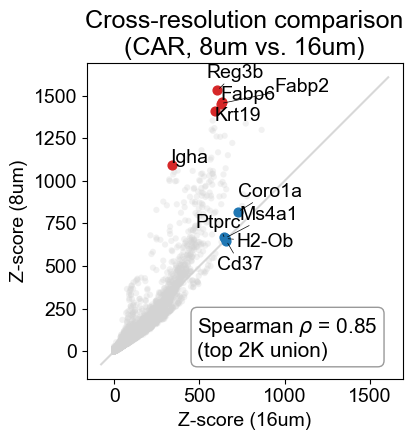

In [18]:
from adjustText import adjust_text

rho = get_spearman(results[('car', '016um')], results[('car', '008um')], n=2000)

merged = pd.merge(
    results[('car', '016um')], 
    results[('car', '008um')], 
    how='inner', left_index=True, right_index=True, 
    suffixes=('_16', '_08')
)


# A. Identify Outliers (High discrepancy relative to distribution)
z1 = (merged['Z_score_16'] - merged['Z_score_16'].mean()) / merged['Z_score_16'].std()
z2 = (merged['Z_score_08'] - merged['Z_score_08'].mean()) / merged['Z_score_08'].std()
merged['std_diff'] = abs(z1 - z2)
outliers = merged.nlargest(5, 'std_diff')

# B. Identify Controls (High signal AND low discrepancy)
# We calculate the raw difference and the sum of signals
merged['raw_diff'] = abs(merged['Z_score_16'] - merged['Z_score_08'])
merged['signal_sum'] = merged['Z_score_16'] + merged['Z_score_08']

# Strategy: Take the top 100 genes by signal strength, then pick the 5 with the smallest difference
candidates = merged.nlargest(100, 'signal_sum')
controls = candidates.nsmallest(5, 'raw_diff')

fig, ax = plt.subplots(figsize=(4.5, 4.5))

# Scatter plot
ax.scatter(merged['Z_score_16'], merged['Z_score_08'], alpha=0.3, c='lightgrey', s=20, edgecolor='none')
ax.scatter(outliers['Z_score_16'], outliers['Z_score_08'], c='#d62728', s=40, label='Outliers')
ax.scatter(controls['Z_score_16'], controls['Z_score_08'], c='#1f77b4', s=40, label='Controls')

# Diagonal line
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, color='gray', linestyle='-', alpha=0.3, lw=1.5, zorder=0)

# Labels
texts = [ax.text(row['Z_score_16'], row['Z_score_08'], idx, fontsize=font_config['text']) 
         for idx, row in outliers.iterrows()] + \
        [ax.text(row['Z_score_16'], row['Z_score_08'], idx, fontsize=font_config['text']) 
         for idx, row in controls.iterrows()]
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

ax.set_title('Cross-resolution comparison\n(CAR, 8um vs. 16um)', fontsize=font_config['title'])
ax.set_xlabel('Z-score (16um)')
ax.set_ylabel('Z-score (8um)')
ax.set_box_aspect(1)

# Stats Annotation
ax.text(0.35, 0.20, rf"Spearman $\rho$ = {rho:.2f}" + "\n(top 2K union)", 
             transform=ax.transAxes, fontsize=font_config['text'] + 1, va='top',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('figures/visium_hd_16_vs_8um.pdf', bbox_inches='tight')
plt.show()

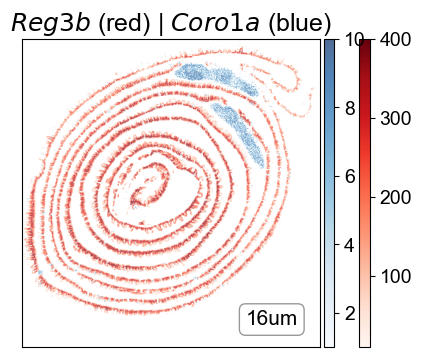

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colors import LogNorm

def get_robust_cmap(cmap_name):
    n_colors = 256
    original_cmap = plt.get_cmap(cmap_name)
    colors = original_cmap(np.linspace(0, 1, n_colors))
    
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(f"{cmap_name}_alpha", colors)
    custom_cmap.set_over(color=colors[-1,:])
    custom_cmap.set_under(color='white', alpha=0.0)
    return custom_cmap

# --- 2. Setup Variables, Norms, and Colormaps ---
gene_1 = 'Reg3b'
gene_2 = 'Coro1a'

cmap_reds = get_robust_cmap('Reds')
cmap_blues = get_robust_cmap('Blues')

# Define norms externally so we can use them for both the plot and the manual colorbar
norm_g1 = LogNorm(vmin=10, vmax=400, clip=False)
norm_g2 = LogNorm(vmin=1, vmax=10, clip=False)

# --- 3. Create Figure ---
fig, ax = plt.subplots(figsize=(5.5, 4)) # Slightly wider figure to accommodate bars

# --- 4. Build Plot (Disable built-in colorbars) ---
(
    # Render Gene 1 (Red)
    sdata.pl.render_shapes(
        "Visium_HD_Mouse_Small_Intestine_square_016um", 
        color=gene_1, 
        fill_alpha=1,
        cmap=cmap_reds,
        na_color=None,
        norm=norm_g1, 
        outline_alpha=0,
        method="matplotlib",
        colorbar=False
    )
    
    # Render Gene 2 (Blue)
    .pl.render_shapes(
        "Visium_HD_Mouse_Small_Intestine_square_016um", 
        color=gene_2, 
        cmap=cmap_blues,
        fill_alpha=0.7,
        na_color=None,
        norm=norm_g2,
        outline_color=None,
        outline_alpha=0,
        method="matplotlib",
        colorbar=False
    )
    
    .pl.show(
        ax=ax,
        coordinate_systems="Visium_HD_Mouse_Small_Intestine",
    )
)

# --- 6. Final Formatting ---
ax.set_title(rf"${gene_1}$ (red) | ${gene_2}$ (blue)")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.text(0.75, 0.12, "16um", 
        transform=ax.transAxes, fontsize=font_config['text'] + 1, va='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.savefig('figures/visium_hd_example_genes.pdf', bbox_inches='tight')
plt.show()

#### FFT of selected genes

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# --- Configuration ---
KEY_LOW_RES = 'rasterized_016um'
KEY_HIGH_RES = 'rasterized_008um' 
PX_SIZE_LOW = 16.0 
PX_SIZE_HIGH = 8.0 

# Define groups explicitly
groups = {
    'Outliers': {'genes': outliers.index.tolist(), 'color': '#d62728'}, # Red
    'Controls': {'genes': controls.index.tolist(), 'color': '#1f77b4'}  # Blue
}

def get_normalized_radial_profile(image_2d, pixel_size):
    """
    Computes the NORMALIZED azimuthally averaged power spectrum.
    """
    img = np.nan_to_num(image_2d, nan=0.0)
    img = img - np.mean(img) # Remove DC component
    # standardized by variace
    img = img / (np.std(img) + 1e-10)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)**2 
    
    h, w = magnitude_spectrum.shape
    cy, cx = h // 2, w // 2
    y, x = np.ogrid[-cy:h-cy, -cx:w-cx]
    r = np.sqrt(x**2 + y**2)
    
    r_int = r.astype(int)
    tbin = np.bincount(r_int.ravel(), magnitude_spectrum.ravel())
    nr = np.bincount(r_int.ravel())
    
    radial_profile = np.zeros_like(tbin, dtype=float)
    mask = nr > 0
    radial_profile[mask] = tbin[mask] / nr[mask]
    
    # Normalize by Total Power (Area under curve = 1)
    total_power = np.sum(radial_profile)
    if total_power > 0:
        radial_profile = radial_profile / total_power
    
    freqs = np.linspace(0, 1.0 / (2.0 * pixel_size), len(radial_profile))
    
    # Filter out the 0-frequency component for log-log plotting
    return freqs[1:], radial_profile[1:]

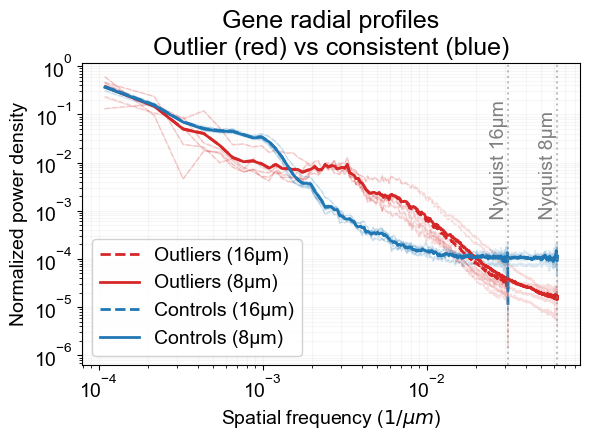

In [20]:
# --- Plotting ---
fig, ax = plt.subplots(figsize=(6, 4.5))

# Storage for calculating averages later
curves_data = {
    'Outliers': {16: [], 8: []},
    'Controls': {16: [], 8: []}
}

# 1. Plot Individual Lines (Thin, Transparent)
for group_name, props in groups.items():
    color = props['color']
    genes = props['genes']
    
    for gene in genes:
        # --- 16um ---
        try:
            img_lo = sdata[KEY_LOW_RES].sel(c=gene).values
            freq_lo, pow_lo = get_normalized_radial_profile(img_lo, PX_SIZE_LOW)
            
            # Store for averaging
            curves_data[group_name][16].append((freq_lo, pow_lo))
            
            # Plot faint individual line
            ax.loglog(freq_lo, pow_lo, color=color, alpha=0.15, lw=1, linestyle='--')
        except KeyError:
            pass

        # --- 8um ---
        try:
            img_hi = sdata[KEY_HIGH_RES].sel(c=gene).values
            freq_hi, pow_hi = get_normalized_radial_profile(img_hi, PX_SIZE_HIGH)
            
            # Store for averaging
            curves_data[group_name][8].append((freq_hi, pow_hi))
            
            # Plot faint individual line
            ax.loglog(freq_hi, pow_hi, color=color, alpha=0.15, lw=1, linestyle='-')
        except KeyError:
            pass

# 2. Calculate and Plot Averages + Highlights
for group_name, props in groups.items():
    color = props['color']
    
    # --- Average 16um ---
    # We need to interpolate to a common grid to average them
    list_16 = curves_data[group_name][16]
    if list_16:
        # Use the frequency axis of the first gene as the reference
        ref_freq_16 = list_16[0][0] 
        interp_powers_16 = []
        for f, p in list_16:
            # Interpolate onto reference grid
            func = interpolate.interp1d(f, p, bounds_error=False, fill_value=np.nan)
            interp_powers_16.append(func(ref_freq_16))
        
        mean_pow_16 = np.nanmean(np.array(interp_powers_16), axis=0)
        ax.loglog(ref_freq_16, mean_pow_16, color=color, alpha=1.0, lw=2, linestyle='--', label=f'{group_name} (16µm)')

    # --- Average 8um ---
    list_8 = curves_data[group_name][8]
    if list_8:
        ref_freq_8 = list_8[0][0]
        interp_powers_8 = []
        for f, p in list_8:
            func = interpolate.interp1d(f, p, bounds_error=False, fill_value=np.nan)
            interp_powers_8.append(func(ref_freq_8))
            
        mean_pow_8 = np.nanmean(np.array(interp_powers_8), axis=0)
        ax.loglog(ref_freq_8, mean_pow_8, color=color, alpha=1.0, lw=2, linestyle='-', label=f'{group_name} (8µm)')

# --- Formatting ---
ax.set_xlabel(r'Spatial frequency ($1/\mu m$)')
ax.set_ylabel('Normalized power density')
ax.set_title('Gene radial profiles\nOutlier (red) vs consistent (blue)')

# Vertical Nyquist Lines
ax.axvline(1/(2*PX_SIZE_LOW), color='gray', linestyle=':', alpha=0.5)
ax.text(1/(2*PX_SIZE_LOW), 5e-4, ' Nyquist 16µm', rotation=90, va='bottom', ha='right',
        color='gray', fontsize=font_config['text'])

ax.axvline(1/(2*PX_SIZE_HIGH), color='gray', linestyle=':', alpha=0.5)
ax.text(1/(2*PX_SIZE_HIGH), 5e-4, ' Nyquist 8µm', rotation=90, va='bottom', ha='right',
        color='gray', fontsize=font_config['text'])

# Legend inside, lower left
ax.legend(loc='lower left', fontsize=font_config['legend'], framealpha=0.9)

ax.grid(True, which="both", ls="-", alpha=0.1)
plt.tight_layout()

plt.savefig('figures/visium_hd_power_density.pdf', bbox_inches='tight')
plt.show()

### Bivariate Moran's R

#### Bivariate tests on top 2K genes

In [21]:
res_key = '008um'
bin_key = f'Visium_HD_Mouse_Small_Intestine_square_{res_key}'
table_key = f'square_{res_key}'

# Select top 1000 variable genes
top2k = results[('car', res_key)].sort_values(
    'Q', ascending=False
).head(n=2000).index.to_list()

# Compute R-statistics
pt = PatternDetectorFFT(sdata=sdata, kernel_method='moran')
df_r_moran = pt.compute_rstat(
    bins=bin_key,
    table_name=table_key, 
    col_key='array_col', 
    row_key='array_row',
    features_x=top2k,
    features_y=None,
    workers=-1, 
    return_pval=True, 
    chunk_size=256
)

pt = PatternDetectorFFT(sdata=sdata, kernel_method='car', rho=0.9)
df_r_car = pt.compute_rstat(
    bins=bin_key,
    table_name=table_key, 
    col_key='array_col', 
    row_key='array_row',
    features_x=top2k,
    features_y=None,
    workers=-1, 
    return_pval=True, 
    chunk_size=256
)

Rasterizing square_008um into rasterized_square_008um...
Building FFTKernel (moran) for grid shape (822, 799)...
Computing R-stats: 2000 x 2000 matrix.
Processing in 8 chunks of size ~256...


Processing X chunks: 100%|████████████████████████| 8/8 [04:02<00:00, 30.32s/it]


Rasterizing square_008um into rasterized_square_008um...
Building FFTKernel (car) for grid shape (822, 799)...
Computing R-stats: 2000 x 2000 matrix.
Processing in 8 chunks of size ~256...


Processing X chunks: 100%|████████████████████████| 8/8 [03:51<00:00, 28.97s/it]


In [22]:
# Combine test results
from scipy.stats import linregress

def get_pair_data(df, metric, suffix):
    """Flattens matrix to unique pairs for regression."""
    d = df.copy()
    # Create sorted tuple index to handle undirected pairs uniquely
    d['Pair_ID'] = d.apply(lambda row: tuple(sorted([str(row['Feature_1']), str(row['Feature_2'])])), axis=1)
    d = d.drop_duplicates(subset=['Pair_ID'])
    d['Is_self'] = d.apply(lambda row: str(row['Feature_1']) == str(row['Feature_2']), axis=1)
    return d.set_index('Pair_ID')[[metric, 'Is_self']].rename(columns={metric: f"{metric}_{suffix}"})

# Matrix alignment
metric = 'Z_score'
mat_moran = df_r_moran.pivot(index='Feature_1', columns='Feature_2', values=metric)
mat_car = df_r_car.pivot(index='Feature_1', columns='Feature_2', values=metric)

# Fill NA by symmetry
mat_moran = mat_moran.combine_first(mat_moran.T).fillna(0)
mat_car = mat_car.combine_first(mat_car.T).fillna(0)

# Intersection
mat_moran = mat_moran.loc[top2k, top2k]
mat_car = mat_car.loc[top2k, top2k]

# Flatten and Join
# We reconstruct the DFs from the aligned matrices to ensure perfect sync
df_m_aligned = mat_moran.stack().reset_index()
df_m_aligned.columns = ['Feature_1', 'Feature_2', metric]

df_i_aligned = mat_car.stack().reset_index()
df_i_aligned.columns = ['Feature_1', 'Feature_2', metric]

d1 = get_pair_data(df_m_aligned, metric, 'Moran')
d2 = get_pair_data(df_i_aligned, metric, 'CAR').drop(columns=['Is_self'])
merged = d1.join(d2, how='inner')

# 5. Regression & Residuals
slope, intercept, r_value, p_value, std_err = linregress(
    merged[f'{metric}_Moran'], merged[f'{metric}_CAR']
)
merged['Predicted'] = slope * merged[f'{metric}_Moran'] + intercept
merged['Residual'] = merged[f'{metric}_CAR'] - merged['Predicted']
resid_std = merged['Residual'].std()

# Calculate standardized residual (Deviation)
merged['Deviation_Z'] = merged['Residual'] / resid_std

#### Save and reload results

In [23]:
# Save and reload results
merged.to_csv('results/visium_hd_intestine/bivariate_top2k_8um.csv', index=True)

# # reload results
# merged = pd.read_csv('results/visium_hd_intestine/bivariate_top2k_8um.csv', index_col=0)

In [24]:
def clean_parse_pair(s):
    if isinstance(s, tuple):
        return s

    # 1. Remove starting '(' and ending ')'
    s = s.strip('()')
    
    # 2. Split by comma
    parts = s.split(',')
    
    # 3. Clean each part: remove whitespace, single quotes, and double quotes
    # The strip function removes characters from both ends
    cleaned_parts = [p.strip(" '\"") for p in parts]
    
    return tuple(cleaned_parts)

# Apply the function
merged['Gene_Pair'] = merged.index.to_series().apply(clean_parse_pair)

In [25]:
merged.head()

Z_score_Moran  Is_self  Z_score_CAR    Predicted   Residual  \
Pair_ID                                                                       
(Reg3b, Reg3b)    1394.192255     True  2758.575519  2846.545166 -87.969647   
(Fabp6, Reg3b)    1031.727955    False  2087.468770  2110.091438 -22.622668   
(Fabp2, Reg3b)     183.532262    False   396.089608   386.730323   9.359285   
(Reg3b, Reg3g)    1260.752713    False  2535.404277  2575.423160 -40.018883   
(Krt8, Reg3b)      971.111266    False  2039.720091  1986.930656  52.789435   

                Deviation_Z       Gene_Pair  
Pair_ID                                      
(Reg3b, Reg3b)    -3.623466  (Reg3b, Reg3b)  
(Fabp6, Reg3b)    -0.931827  (Fabp6, Reg3b)  
(Fabp2, Reg3b)     0.385509  (Fabp2, Reg3b)  
(Reg3b, Reg3g)    -1.648376  (Reg3b, Reg3g)  
(Krt8, Reg3b)      2.174395   (Krt8, Reg3b)

#### Scatterplot and an example

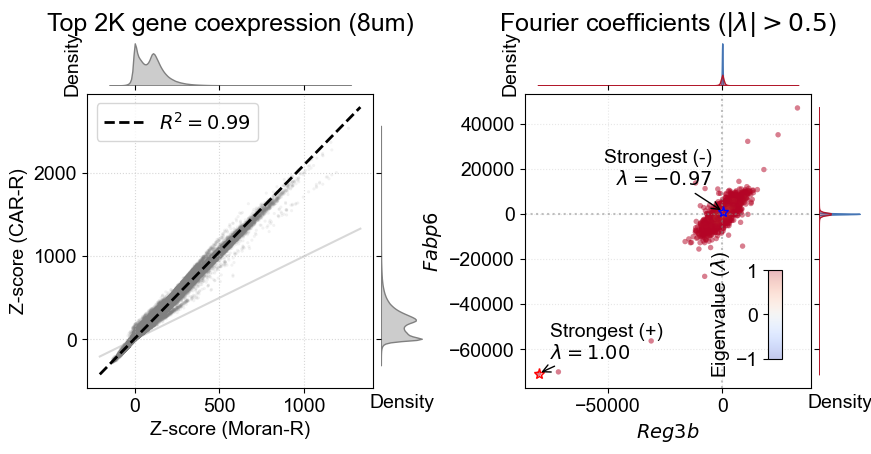

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy.stats import linregress
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- FFT Processing for Right Panel ---
gene_a = 'Reg3b'
gene_b = 'Fabp6'

img_a = sdata['rasterized_008um'].sel(c=gene_a).values
img_b = sdata['rasterized_008um'].sel(c=gene_b).values

# Normalize
a_clean = np.nan_to_num(img_a)
a_clean = (a_clean - np.mean(a_clean)) / np.std(a_clean)
b_clean = np.nan_to_num(img_b)
b_clean = (b_clean - np.mean(b_clean)) / np.std(b_clean)

# Compute Moran kernel spectrum
k_moran = FFTKernel(a_clean.shape, method='moran')
lambdas = k_moran._compute_eigenvalues().real.reshape(a_clean.shape)

# Compute Coefficients
coeffs_a = np.fft.fft2(a_clean)
coeffs_b = np.fft.fft2(b_clean)

# Flatten and Filter
flat_lambdas = lambdas.flatten()
flat_a = coeffs_a.flatten().real
flat_b = coeffs_b.flatten().real

mask_combined = np.abs(flat_lambdas) > 0.5
filt_a = flat_a[mask_combined]
filt_b = flat_b[mask_combined]
filt_lam = flat_lambdas[mask_combined]

# --- Figure Setup ---
fig = plt.figure(figsize=(10, 4.5)) 

# Layout: 2 Rows, 5 Cols
# Cols: [Left Main, Left Side, Spacer, Right Main, Right Side]
gs = GridSpec(2, 5, figure=fig, 
              width_ratios=[10, 1.5, 3, 10, 1.5], 
              height_ratios=[1.5, 10],
              wspace=0.05, hspace=0.05)

metric = 'Z_score'
global_color = 'gray'

# =========================================================
# PANEL 1: GLOBAL AGREEMENT (Left)
# =========================================================

ax_scat_1 = fig.add_subplot(gs[1, 0])
ax_top_1 = fig.add_subplot(gs[0, 0], sharex=ax_scat_1)
ax_side_1 = fig.add_subplot(gs[1, 1], sharey=ax_scat_1)

# Scatter (non-self)
_df = merged.loc[merged['Gene_Pair'].apply(lambda x: x[0]!=x[1])]
ax_scat_1.scatter(_df[f'{metric}_Moran'], _df[f'{metric}_CAR'], 
                  c=global_color, s=5, alpha=0.1, 
                  edgecolors='none', rasterized=True)

# Regression
slope, intercept, r_value, p_value, std_err = linregress(
    _df[f'{metric}_Moran'], _df[f'{metric}_CAR']
)
x_range_1 = np.array(ax_scat_1.get_xlim())
ax_scat_1.plot(x_range_1, x_range_1, color='gray', linestyle='-', alpha=0.3, lw=1.5, zorder=0)
ax_scat_1.plot(x_range_1, slope*x_range_1 + intercept, 'k--', lw=2, zorder=4)

# Marginal Densities
sns.kdeplot(data=_df, x=f'{metric}_Moran', ax=ax_top_1, 
            color=global_color, fill=True, alpha=0.4, warn_singular=False)
sns.kdeplot(data=_df, y=f'{metric}_CAR', ax=ax_side_1, 
            color=global_color, fill=True, alpha=0.4, warn_singular=False)

ax_top_1.set_title("Top 2K gene coexpression (8um)", fontsize=font_config['title'], y=1.05)
ax_scat_1.set_xlabel("Z-score (Moran-R)", fontsize=font_config['label'])
ax_scat_1.set_ylabel("Z-score (CAR-R)", fontsize=font_config['label'])
ax_scat_1.grid(True, linestyle=':', alpha=0.5)

legend_elements_1 = [Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$R^2 = {:.2f}$'.format(r_value**2))]
ax_scat_1.legend(handles=legend_elements_1, loc='upper left', frameon=True, fontsize=font_config['text'])

# =========================================================
# PANEL 2: FOURIER COEFFICIENTS (Right)
# =========================================================

ax_scat_2 = fig.add_subplot(gs[1, 3])
ax_top_2 = fig.add_subplot(gs[0, 3], sharex=ax_scat_2)
ax_side_2 = fig.add_subplot(gs[1, 4], sharey=ax_scat_2)

# Scatter
sc = ax_scat_2.scatter(
    filt_a, filt_b, c=filt_lam, cmap='coolwarm', 
    s=15, alpha=0.3, edgecolors='none', vmin=-1, vmax=1,
    rasterized=True
)

# Annotate Strongest Frequencies
magnitude = np.abs(filt_a * filt_b)
product_sign = np.sign(filt_lam)

# Positive Correlation Annotation
pos_mask = product_sign > 0
if np.any(pos_mask):
    idx_pos = np.argmax(magnitude * pos_mask)
    pt_pos = (filt_a[idx_pos], filt_b[idx_pos])
    ax_scat_2.plot(pt_pos[0], pt_pos[1], marker='*', markerfacecolor='none',
            markeredgecolor = 'red', markersize = 8)
    # Improved placement: closer to point
    ax_scat_2.annotate("Strongest (+)\n" + rf"$\lambda={filt_lam[idx_pos]:.2f}$", 
                xy=pt_pos, xytext=(pt_pos[0] + 5000, pt_pos[1] + 5000),
                arrowprops=dict(arrowstyle="->", color='black', lw=1),
                fontsize=font_config['text'], ha='left', va='bottom')

# Negative Correlation Annotation
neg_mask = product_sign < 0
if np.any(neg_mask):
    idx_neg = np.argmax(magnitude * neg_mask)
    pt_neg = (filt_a[idx_neg], filt_b[idx_neg])
    ax_scat_2.plot(pt_neg[0], pt_neg[1], marker='*', markerfacecolor='none',
            markeredgecolor = 'blue', markersize = 8)
    # Improved placement: closer to point
    ax_scat_2.annotate("Strongest (-)\n" + rf"$\lambda={filt_lam[idx_neg]:.2f}$", 
                xy=pt_neg, xytext=(pt_neg[0] - 5000, pt_neg[1] + 10000),
                arrowprops=dict(arrowstyle="->", color='black', lw=1),
                fontsize=font_config['text'], ha='right', va='bottom')

# Marginal Densities (Grouped by Pos/Neg Eigenvalues)
df_fft = pd.DataFrame({'a': filt_a, 'b': filt_b, 'lam': filt_lam})
df_fft['Sign'] = np.where(df_fft['lam'] > 0, 'Pos', 'Neg')
colors_fft = {'Pos': '#b2182b', 'Neg': '#4575b4'} 

sns.kdeplot(data=df_fft, x='a', hue='Sign', palette=colors_fft, ax=ax_top_2,
            fill=True, alpha=0.3, legend=False, common_norm=False, warn_singular=False)
sns.kdeplot(data=df_fft, y='b', hue='Sign', palette=colors_fft, ax=ax_side_2,
            fill=True, alpha=0.3, legend=False, common_norm=False, warn_singular=False)

# Styling Panel 2
ax_top_2.set_title(r"Fourier coefficients ($|\lambda| > 0.5$)", fontsize=font_config['title'], y=1.05)
ax_scat_2.set_xlabel(rf"${gene_a}$", fontsize=font_config['label'])
ax_scat_2.set_ylabel(rf"${gene_b}$", fontsize=font_config['label'])

ax_scat_2.axhline(0, color='gray', linestyle=':', alpha=0.5, zorder=1)
ax_scat_2.axvline(0, color='gray', linestyle=':', alpha=0.5, zorder=1)
ax_scat_2.grid(True, linestyle=':', alpha=0.3) # Added grid for consistency

# Force scientific notation to avoid corner clutter
# ax_scat_2.ticklabel_format(style='sci', scilimits=(0, 0), axis='both')

# --- INSET COLORBAR ---
# Create an inset axes in the lower right corner of the scatter plot
axins = inset_axes(ax_scat_2,
                   width="5%",  # width = 5% of parent_bbox width
                   height="30%",  # height : 30%
                   loc='lower right',
                   borderpad=1.5) # Padding from the border

cbar = plt.colorbar(sc, cax=axins, orientation='vertical')
cbar.set_label(r"Eigenvalue ($\lambda$)", labelpad=3, fontsize=font_config['text'])
cbar.set_ticks([1, 0, -1])
cbar.ax.tick_params(labelsize=font_config['text'])
# Move ticks to left side of colorbar so they don't hit the plot frame
axins.yaxis.set_ticks_position('left')
axins.yaxis.set_label_position('left') 

# =========================================================
# CLEANUP
# =========================================================

for ax_t, ax_s in [(ax_top_1, ax_side_1), (ax_top_2, ax_side_2)]:
    plt.setp(ax_t.get_xticklabels(), visible=False)
    plt.setp(ax_s.get_yticklabels(), visible=False)
    ax_t.set_xlabel("")
    ax_s.set_ylabel("")
    ax_t.set_yticks([])
    ax_s.set_xticks([])
    # Remove spines for cleaner marginals
    sns.despine(ax=ax_t, left=True, bottom=True)
    sns.despine(ax=ax_s, left=True, bottom=True)

plt.savefig('figures/visium_hd_bivariate.pdf')
plt.show()

## Application on lineage tracing lung adenocarcinoma data

In this section, we analyze the single-cell lineage tracing lung adenocarcinoma data from [Yang et al., Cell 2022](https://www.cell.com/cell/fulltext/S0092-8674(22)00462-7). 

- Pre-processed single-cell RNA-seq data and inferred phylogenetic trees are available via [Zenodo](https://zenodo.org/records/5847462#.YrFDKuzMI6A). 
- To run the analysis, please make sure the `cassiopeia` package is installed. See [Cassiopeia Documentation](https://cassiopeia-lineage.readthedocs.io/en/latest/)

### Load anndata and per-tumor trees

In [ ]:
import scanpy as sc
import pickle
import pandas as pd
import numpy as np
from scipy import sparse
import cassiopeia as cas

adata = sc.read_h5ad('data/adata_processed.nt-002.h5ad')
adata

AnnData object with n_obs × n_vars = 58022 × 27998
    obs: 'TS_Present', 'RNA_Present', 'MULTI', 'TS_UMI', 'NUM_INTBC', 'Lane', 'Tumor', 'SubTumor', 'ES_clone', 'genotype', 'Aging_time', 'Mouse', 'Aging_Month', 'Batch_Library', 'Batch_Harvest', 'Aging_Time', 'MetFamily', 'lentiBC', 'is_normal', 'PercentUncut', 'leiden', 'n_counts', 'leiden_sub', 'Cluster-Name'
    uns: 'Cluster-Name_colors', 'Lane_colors', 'leiden', 'leiden_colors', 'neighbors'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
# Load prebuilt tree for all tumors and filter out small tumors
tumor_list = []
tree_dict = {}
min_sample_size = 300

for t in adata.obs['Tumor'].unique():
    try:
        with open(f"data/trees_ori_trim/{t}_tree.newick", "r") as f:
            newick_tree = f.read().strip()
        
        with open(f"data/trees_ori_trim/{t}_priors.pkl", "rb") as f:
            priors = pickle.load(f)

        # The priors dict structure is {character_index: {state: probability}}
        # We need to ensure 'state' is an integer, not a string.
        new_priors = {}
        for char_idx, state_probs in priors.items():
            new_priors[char_idx] = {int(state): prob for state, prob in state_probs.items()}

    except:
        continue

    # load cell barcodes with editing history
    character_matrix = pd.read_csv(
        f"data/trees_ori_trim/{t}_character_matrix.txt", sep="\t"
    )
    character_matrix.set_index("cellBC", inplace=True)
    character_matrix.replace("-", -1, inplace=True)
    character_matrix = character_matrix.astype(int)

    # make sure all cells are available
    assert np.all(character_matrix.index.isin(adata.obs_names))

    # skip small tumors
    if character_matrix.shape[0] < min_sample_size:
        continue
    
    # initialize tree with the corrected priors
    tree = cas.data.CassiopeiaTree(
        character_matrix=character_matrix, 
        priors=new_priors,  # Use the new integer-keyed priors
        tree=newick_tree
    )

    # record the tumor
    tumor_list.append(t)
    tree_dict[t] = tree

In [ ]:
pd.DataFrame(
    [{'name':k, 'size': tree.n_cell} for k, tree in tree_dict.items()]
).sort_values('size', ascending = False)

name   size
0   3724_NT_T1  14842
5   3434_NT_T1   2402
6   3434_NT_T3   2292
10  3513_NT_T2   2118
1   3430_NT_T1   1693
9   3513_NT_T3   1457
14  3730_NT_T1   1223
7   3434_NT_T2   1165
3   3435_NT_T1   1109
8   3513_NT_T1    969
16  3726_NT_T2    854
15  3726_NT_T1    772
17  3730_NT_T2    657
12  3513_NT_T4    604
2   3430_NT_T2    511
11  3513_NT_T5    347
13  3433_NT_T2    329
4   3435_NT_T3    319

### Compute graph weight matrix

#### Define tree neighborhood

In [ ]:
import numpy as np
import pandas as pd

def compute_sibling_matrix(tree):
    """
    Returns a binary matrix where M_ij = 1 if leaf_i and leaf_j share a parent.
    """
    leaves = list(tree.leaves)
    n = len(leaves)
    leaf_to_idx = {leaf: i for i, leaf in enumerate(leaves)}
    
    # Initialize sparse-like logic or dense array
    matrix = np.zeros((n, n), dtype=int)
    
    # Iterate over parents of leaves
    # We only care about internal nodes that are directly connected to leaves
    parents_of_leaves = set(tree.parent(l) for l in leaves)
    
    for parent in parents_of_leaves:
        # Get all children of this parent that are leaves
        siblings = [c for c in tree.children(parent) if tree.is_leaf(c)]
        
        if len(siblings) > 1:
            # Get indices
            indices = [leaf_to_idx[s] for s in siblings]
            
            # Create a meshgrid of indices to update all pairs at once
            # This sets M[i,j] = 1 for all i,j in this sibling group
            idx_grid = np.ix_(indices, indices)
            matrix[idx_grid] = 1
            
    # Remove self-connections (diagonal)
    np.fill_diagonal(matrix, 0)
    
    return pd.DataFrame(matrix, index=leaves, columns=leaves)


def compute_ancestral_matrix(tree, weights=[1, 0.5, 0.25]):
    """
    Returns a similarity matrix based on shared ancestry for a CassiopeiaTree.
    
    M_ij is set to given weights based on the depth of the shared ancestor.
    - weights[0] if i and j share a parent (siblings).
    - weights[1] if i and j share a grandparent (cousins).
    - etc.
    
    Args:
    -----------
    tree : cassiopeia.data.CassiopeiaTree
        The hierarchical tree structure.
    weights : list of floats
        Weights to assign for each degree of ancestry. 
        weights[0] = immediate parent, weights[1] = grandparent, etc.
    """
    leaves = list(tree.leaves)
    n = len(leaves)
    leaf_to_idx = {leaf: i for i, leaf in enumerate(leaves)}
    
    # Initialize dense array
    matrix = np.zeros((n, n), dtype=float)
    
    # We process each depth level defined by the weights
    for depth, weight in enumerate(weights):
        
        # Dictionary to group leaves by their ancestor at the current depth
        # Key: Ancestor ID, Value: List of leaf indices descending from this ancestor
        ancestor_groups = {}
        
        for leaf in leaves:
            # Traverse up 'depth + 1' times to find the relevant ancestor
            # depth 0 = parent (1 step up)
            # depth 1 = grandparent (2 steps up)
            current_node_id = leaf
            steps_up = depth + 1
            ancestor_id = None
            
            # Walk up the tree
            for _ in range(steps_up):
                # The root has no parent, so we cannot go higher.
                if current_node_id == tree.root:
                    ancestor_id = None
                    break 

                # Now get the parent id
                try:
                    parent_id = tree.parent(current_node_id)
                except (IndexError, KeyError, ValueError):
                    # Handles cases where tree topology might be broken or node is detached
                    ancestor_id = None
                    break
                
                current_node_id = parent_id
                ancestor_id = current_node_id
            
            if ancestor_id is not None:
                if ancestor_id not in ancestor_groups:
                    ancestor_groups[ancestor_id] = []
                ancestor_groups[ancestor_id].append(leaf_to_idx[leaf])
        
        # Apply weights for this depth level
        for anc_id, leaf_indices in ancestor_groups.items():
            if len(leaf_indices) > 1:
                idx_grid = np.ix_(leaf_indices, leaf_indices)
                
                # We only add the weight if the connection hasn't been established 
                # by a stronger (closer) relationship yet.
                current_values = matrix[idx_grid]
                
                # Create a mask where no relationship has been recorded yet
                mask = (current_values == 0)
                
                # Apply weight only to zero entries
                matrix[idx_grid] = np.where(mask, weight, current_values)

    # Remove self-connections (diagonal)
    np.fill_diagonal(matrix, 0)
    
    return pd.DataFrame(matrix, index=leaves, columns=leaves)

#### Visualization graph weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA

def visualize_adjacency_and_pca(A, labels=None, n_components_spectral=16):
    """
    Visualizes an adjacency matrix via Heatmap and PCA of its Spectral Embedding.
    
    Parameters:
    - A: n-by-n numpy adjacency matrix (zero diagonal).
    - labels: n-by-1 vector for coloring the nodes. If None, uses node index.
    - n_components_spectral: How many eigenvectors to keep before running PCA.
    """
    n = A.shape[0]
    
    # Handle labels default
    if labels is None:
        labels = np.arange(n)
        label_title = "Node Index"
        cmap_scatter = "viridis"
    else:
        # Flatten in case input is (n, 1) like typical AnnData.X
        labels = np.array(labels).flatten()
        label_title = "Provided Labels"
        
        # Choose discrete cmap if labels look categorical, else continuous
        if np.issubdtype(labels.dtype, np.integer) or labels.dtype.kind in ('U', 'S'):
            cmap_scatter = "tab10"
        else:
            cmap_scatter = "viridis" # Good for gene expression

    # --- 1. Compute Spectral Embedding (High Dimensional) ---
    
    # Degree Matrix
    degrees = np.sum(A, axis=1)
    degrees_safe = degrees.copy()
    degrees_safe[degrees_safe == 0] = 1 # Avoid div by zero
    
    # Normalized Symmetric Laplacian: L_sym = I - D^(-1/2) * A * D^(-1/2)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees_safe))
    I = np.eye(n)
    L_sym = I - (D_inv_sqrt @ A @ D_inv_sqrt)
    
    # Eigen decomposition
    evals, evecs = np.linalg.eigh(L_sym)
    
    # Sort (Low -> High)
    idx = np.argsort(evals)
    evecs = evecs[:, idx]
    
    # Select components. 
    # We skip index 0 (constant vector for eigenvalue 0).
    # We take the next 'n_components_spectral' vectors.
    limit = min(n, n_components_spectral + 1)
    spectral_data = evecs[:, 1:limit]
    
    # --- 2. Apply PCA ---
    
    # Project the spectral embeddings (e.g., 16 dims) down to 2 dims using PCA
    pca = PCA(n_components=2)
    embedding_2d = pca.fit_transform(spectral_data)
    
    # --- 3. Visualization ---
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
    
    # Plot 1: Heatmap (Adjacency)
    # Using 'Greys' ensures it looks distinct from the colored scatter plot
    sns.heatmap(A, ax=axes[0], cmap="Greys", square=True, cbar=False, xticklabels=False, yticklabels=False)
    axes[0].set_title(f"Adjacency Matrix ({n}x{n})")
    axes[0].set_xlabel("Node Index")
    axes[0].set_ylabel("Node Index")
    
    # Plot 2: PCA of Spectral Embedding
    scatter = axes[1].scatter(
        embedding_2d[:, 0], 
        embedding_2d[:, 1], 
        c=labels, 
        cmap=cmap_scatter, 
        s=20, 
        alpha=1, 
        edgecolor='none' # Removed white edge for cleaner look with many points
    )
    
    axes[1].set_title(f"PCA Projection of Spectral Embedding\n(Top {n_components_spectral} Eigenvectors)")
    axes[1].set_xlabel("PC 1")
    axes[1].set_ylabel("PC 2")
    axes[1].grid(True, linestyle='--', alpha=0.3)
    
    # Add colorbar (only if numeric)
    if np.issubdtype(labels.dtype, np.number):
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label(label_title)

    plt.tight_layout()
    plt.show()

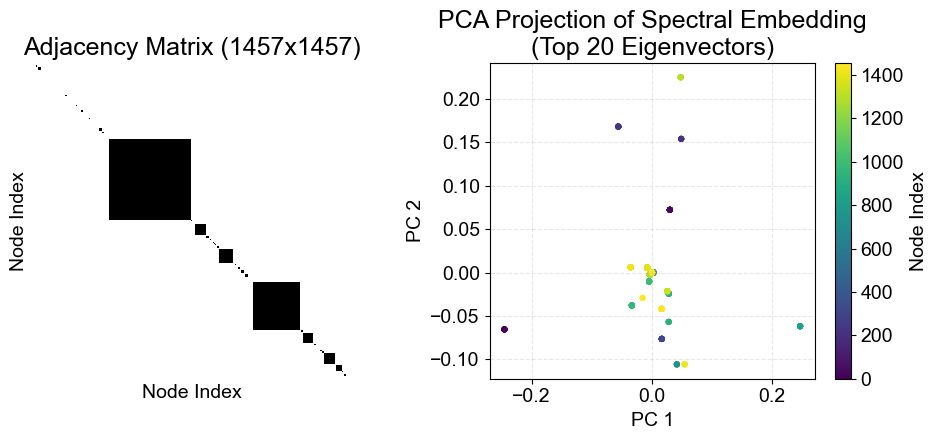

In [ ]:
# Pick one tumor and visualize the weight matrix
W1 = compute_sibling_matrix(tree_dict['3513_NT_T3'])
visualize_adjacency_and_pca(W1, n_components_spectral=20)

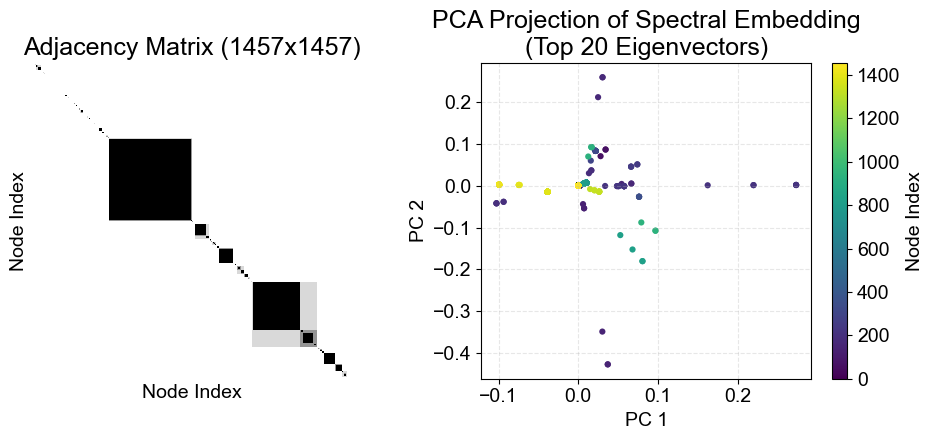

In [ ]:
# Pick one tumor and visualize the weight matrix
W2 = compute_ancestral_matrix(tree_dict['3513_NT_T3'], weights=[1.0, 0.5, 0.25])
visualize_adjacency_and_pca(W2, n_components_spectral=20)

### Cluster heritability

#### Run analysis across tumors

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
from quadsv.detector import PatternDetector

# Storage for results
all_cluster_results = []
clu_tumor_metrics_list = []

print(f"Running cluster heritability analysis for {len(tumor_list)} tumors...")

# --- 1. Processing Loop ---
for tumor in tumor_list:
    try:
        # --- A. Data Preparation ---
        tree = tree_dict[tumor]
        adata_tree = adata[list(tree.leaves), :].copy()
        adata_tree.obsp['W'] = compute_ancestral_matrix(tree, weights=[1.0, 0.5, 0.25])

        # --- B. Run PatternDetector (Moran's I) ---
        model_m = PatternDetector(adata_tree, min_cells=10)
        model_m.build_kernel_from_obsp(key='W', is_distance=False, method='moran')
        res_clu_moran = model_m.compute_qstat(source='obs', features=['Cluster-Name'])

        # --- C. Run PatternDetector (CAR) ---
        model_i = PatternDetector(adata_tree, min_cells=10)
        model_i.build_kernel_from_obsp(key='W', is_distance=False, method='car', rho=0.9, standardize=False)
        res_clu_car = model_i.compute_qstat(source='obs', features=['Cluster-Name'])

        # --- D. Merge Results ---
        df_clu = pd.merge(
            res_clu_moran, res_clu_car, left_index=True, right_index=True,
            suffixes=['_moran', '_car']
        )
        
        # Clean up columns
        df_clu['Tumor'] = tumor
        df_clu['Cluster'] = df_clu.index.str.replace('Cluster-Name_', '')
        
        # Calculate Moran's I (normalized Q)
        df_clu['I_moran'] = df_clu['Q_moran'] / adata_tree.shape[0] 

        # Call significance
        fdr_cutoff = 0.05
        df_clu['Sig_moran'] = df_clu['P_adj_moran'] < fdr_cutoff
        df_clu['Sig_car'] = df_clu['P_adj_car'] < fdr_cutoff
        
        # Store the raw table
        all_cluster_results.append(df_clu)

        # --- E. Compute Metrics Spearman Correlation of Scores
        spearman_corr = np.nan
        if len(df_clu) > 2:
            # We compare I_moran vs Q_car (Rank correlation is scale invariant)
            rho, pval = spearmanr(df_clu['I_moran'], df_clu['Q_car'])
            spearman_corr = rho

        clu_tumor_metrics_list.append({
            'Tumor': tumor,
            'N_Clusters': len(df_clu),
            'N_Cells': model_i.n,
            'Correlation_Spearman': spearman_corr
        })
        
        print(f"  {tumor}: N={len(df_clu)}, Rho={spearman_corr:.2f}")

    except Exception as e:
        print(f"Failed to process {tumor}: {e}")

# Combine all results
df_clu_metrics = pd.DataFrame(clu_tumor_metrics_list)
df_clu_all = pd.concat(all_cluster_results)

Running cluster heritability analysis for 18 tumors...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=14842)...
Removing 46 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:04<00:00,  7.51it/s]  


Building car kernel from obsp['W'] (is_distance=False, n_samples=14842)...
Removing 46 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (car):   0%|                              | 0/32 [00:00<?, ?it/s]             /Users/jysumac/miniforge3/envs/cassiopeia/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Q (car): 100%|██████████████████████████████| 32/32 [05:21<00:00, 10.04s/it]    


  3724_NT_T1: N=5, Rho=0.90
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1693)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 2 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 431.58it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=1693)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 2 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 461.93it/s]   


  3430_NT_T1: N=2, Rho=nan
Building moran kernel from obsp['W'] (is_distance=False, n_samples=511)...
Removing 43 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4441.35it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=511)...
Removing 43 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 501.85it/s]   


  3430_NT_T2: N=3, Rho=1.00
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1109)...
Removing 453 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1342.34it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=1109)...
Removing 453 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1844.82it/s]  


  3435_NT_T1: N=5, Rho=0.90
Building moran kernel from obsp['W'] (is_distance=False, n_samples=319)...
Removing 129 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4998.43it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=319)...
Removing 129 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4086.90it/s]  

  3435_NT_T3: N=3, Rho=1.00


Building moran kernel from obsp['W'] (is_distance=False, n_samples=2402)...
Removing 13 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 1 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 884.44it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=2402)...
Removing 13 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 1 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 640.54it/s]   


  3434_NT_T1: N=1, Rho=nan
Building moran kernel from obsp['W'] (is_distance=False, n_samples=2292)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1485.42it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=2292)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 565.12it/s]   


  3434_NT_T3: N=5, Rho=0.90
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1165)...
Removing 202 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 7 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 3881.14it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=1165)...
Removing 202 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 7 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 558.31it/s]   


  3434_NT_T2: N=7, Rho=1.00
Building moran kernel from obsp['W'] (is_distance=False, n_samples=969)...
Removing 1 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 121.37it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=969)...
Removing 1 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1549.41it/s]  


  3513_NT_T1: N=3, Rho=1.00
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1457)...
Removing 130 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1175.61it/s]

Building car kernel from obsp['W'] (is_distance=False, n_samples=1457)...
Removing 130 isolated samples with zero degree from adjacency matrix...


Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 776.33it/s]   


  3513_NT_T3: N=6, Rho=0.94
Building moran kernel from obsp['W'] (is_distance=False, n_samples=2118)...
Removing 219 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1110.87it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=2118)...
Removing 219 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 559.48it/s]   


  3513_NT_T2: N=6, Rho=0.83
Building moran kernel from obsp['W'] (is_distance=False, n_samples=347)...
Removing 57 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4898.99it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=347)...
Removing 57 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 3466.99it/s]  


  3513_NT_T5: N=5, Rho=0.70
Building moran kernel from obsp['W'] (is_distance=False, n_samples=604)...
Removing 73 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 5612.05it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=604)...
Removing 73 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1006.48it/s]  


  3513_NT_T4: N=5, Rho=0.70
Building moran kernel from obsp['W'] (is_distance=False, n_samples=329)...
Removing 30 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4100.38it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=329)...
Removing 30 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 3490.07it/s]  

  3433_NT_T2: N=6, Rho=1.00


Building moran kernel from obsp['W'] (is_distance=False, n_samples=1223)...
Removing 284 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4660.50it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=1223)...
Removing 284 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 5 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 895.25it/s]   


  3730_NT_T1: N=5, Rho=1.00
Building moran kernel from obsp['W'] (is_distance=False, n_samples=772)...
Removing 124 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 7 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4787.68it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=772)...
Removing 124 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 7 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1154.40it/s]  


  3726_NT_T1: N=7, Rho=0.68
Building moran kernel from obsp['W'] (is_distance=False, n_samples=854)...
Removing 350 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4778.30it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=854)...
Removing 350 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 3 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 2460.77it/s]  

  3726_NT_T2: N=3, Rho=0.50


Building moran kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 4710.88it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Categorical features detected in .obs[keys]; performing one-hot encoding...
Testing 6 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1031.26it/s]  


  3730_NT_T2: N=6, Rho=0.60


#### Save and reload results

In [ ]:
# Save and reload results
df_clu_metrics.to_csv('results/lung_cluster_summary.csv', index=False)
df_clu_all.to_csv('results/lung_cluster_scores_per_tumor.csv')

# # reload results
# df_clu_metrics = pd.read_csv('results/lung_cluster_summary.csv')
# df_clu_all = pd.read_csv('results/lung_cluster_scores_per_tumor.csv', index_col=0)

#### Visualization

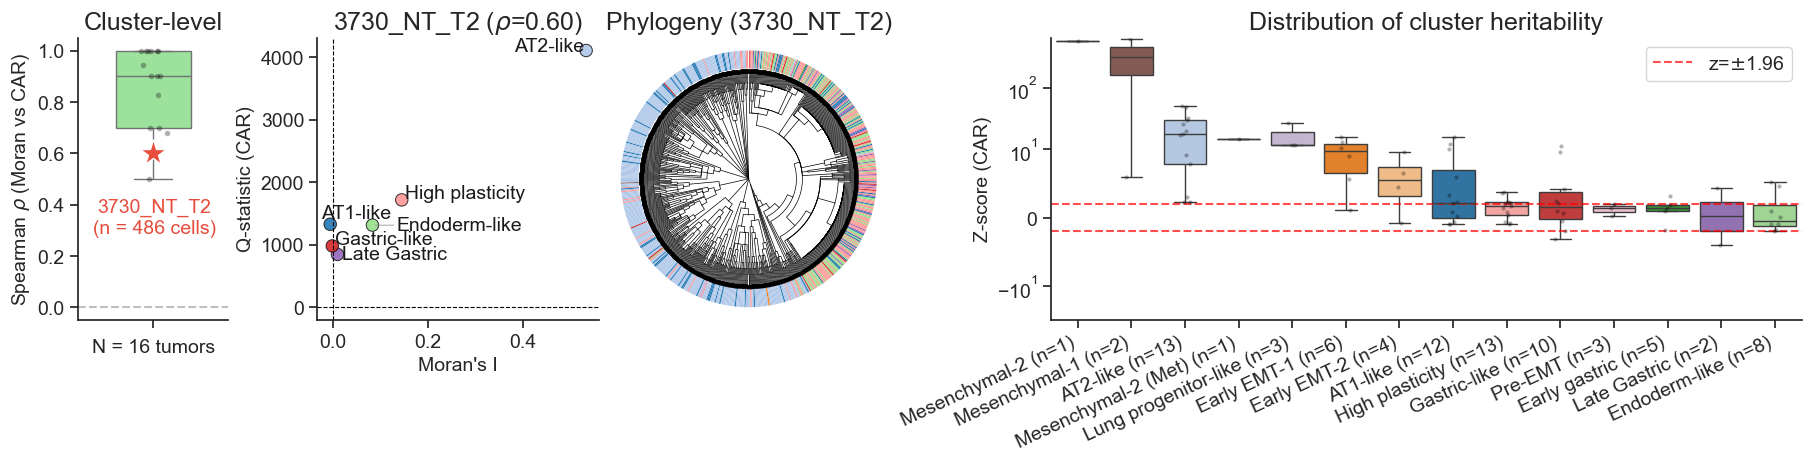

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
from adjustText import adjust_text
from matplotlib.lines import Line2D

# Prepare data for visualization
target_tumor_id = '3730_NT_T2'
# target_tumor_id = '3726_NT_T1'
# target_tumor_id = '3726_NT_T2'

tumor_sizes = df_clu_metrics.set_index('Tumor', inplace=False)['N_Cells']
df_clu_target = df_clu_all[df_clu_all['Tumor'] == target_tumor_id].copy()
tree = tree_dict[target_tumor_id]
adata_tree = adata[list(tree.leaves), :].copy()
tree.cell_meta = adata_tree.obs

# ==========================================
# 1. Visualization Setup
# ==========================================
sns.set_theme(style="ticks")

font_config = {
    'title': 18,
    'label': 14,
    'tick': 14,
    'text': 14,
    'legend': 14,
}

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.titlesize': font_config['title'],
    'axes.labelsize': font_config['label'],
    'xtick.labelsize': font_config['tick'],
    'ytick.labelsize': font_config['tick'],
    'legend.fontsize': font_config['legend'],
    'pdf.fonttype': 42
})

# Unify cluster palette
unique_clusters = sorted(df_clu_all['Cluster'].unique())
colors = sns.color_palette("tab20", n_colors=len(unique_clusters))
cluster_palette = dict(zip(unique_clusters, colors))

# Create mapping for Cassiopeia
custom_cmap = mcolors.ListedColormap(colors)
value_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}

# Figure settup
fig, axes = plt.subplots(
    1, 4, figsize=(18, 4.5), 
    gridspec_kw={'width_ratios': [0.8, 1.5, 1.5, 4]}, 
    layout='constrained'
)

# ==========================================
# Panel A: Spearman Correlation Distribution
# ==========================================
df_corr = df_clu_metrics.dropna(subset=['Correlation_Spearman'])

# 1. Background Boxplot
sns.boxplot(y='Correlation_Spearman', data=df_corr, ax=axes[0],
            width=0.5, linewidth=1, color='lightgreen', showfliers=False)

# 2. Strip plot for all tumors (excluding the target to avoid jittering it)
sns.stripplot(y='Correlation_Spearman', data=df_corr[df_corr['Tumor'] != target_tumor_id], ax=axes[0], 
              color='black', alpha=0.3, jitter=0.1, s=4)

# 3. Highlight Selected Tumor (Plot point at center x=0 and annotate text)
target_corr = df_corr['Correlation_Spearman'][df_corr['Tumor'] == target_tumor_id].item()
axes[0].plot(0, target_corr, marker='*', color='#e74c3c', markersize=20, markeredgecolor='white')
axes[0].text(0.01, target_corr - 0.25, f'{target_tumor_id}\n(n = {tumor_sizes[target_tumor_id]} cells)', 
             color='#e74c3c', va='center', ha='center', fontsize=font_config['text'])

axes[0].set_title("Cluster-level")
axes[0].set_ylabel(r"Spearman $\rho$ (Moran vs CAR)")
axes[0].set_xlabel(f"N = {len(df_corr)} tumors")
axes[0].set_ylim(-0.05, 1.05)
axes[0].set_xlim(-0.5, 0.5)
axes[0].axhline(0, linestyle='--', color='gray', alpha=0.5)

# ==========================================
# Panel B: Scatter Plot (Specific Tumor)
# ==========================================
sns.scatterplot(
    data=df_clu_target, x='I_moran', y='Q_car',
    hue='Cluster', palette=cluster_palette, # Use Unified Palette
    s=80, alpha=0.9, edgecolor='k', legend=False, ax=axes[1]
)

# Labeling
texts = []
for idx, row in df_clu_target.iterrows():
    texts.append(axes[1].text(
        row['I_moran'], row['Q_car'], row['Cluster'],
        fontsize=font_config['text'], color='k'
    ))

adjust_text(texts, x=df_clu_target['I_moran'], y=df_clu_target['Q_car'], ax=axes[1],
            force_text=0.5, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

rho_val = df_corr.loc[df_corr['Tumor']==target_tumor_id, 'Correlation_Spearman'].item()
axes[1].set_title(rf'{target_tumor_id} ($\rho$={rho_val:.2f})')
axes[1].set_xlabel("Moran's I")
axes[1].set_ylabel("Q-statistic (CAR)")
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].axvline(0, color='black', linewidth=0.8, linestyle='--')

# ==========================================
# Panel C: Tree
# ==========================================
cas.pl.plot_matplotlib(
    tree,
    ax=axes[2],
    meta_data='Cluster-Name',
    categorical_cmap=custom_cmap,
    value_mapping=value_mapping,
    add_root=False,
    branch_kwargs={'linewidth': 0.5},
    colorstrip_width=3, 
    orient=90.0
)
axes[2].set_title(f"Phylogeny ({target_tumor_id})")

# ==========================================
# Panel D: Distribution of Z_car per Cluster
# ==========================================
cluster_order = df_clu_all.groupby('Cluster')['Z_score_car'].median().sort_values(ascending=False).index

sns.boxplot(x='Cluster', y='Z_score_car', data=df_clu_all, ax=axes[3], 
            order=cluster_order, hue='Cluster', legend=False, palette=cluster_palette, showfliers=False)

sns.stripplot(x='Cluster', y='Z_score_car', data=df_clu_all, ax=axes[3], 
              order=cluster_order, color='black', alpha=0.3, size=3, jitter=True)

axes[3].set_yscale('symlog', linthresh=10)

counts = df_clu_all['Cluster'].value_counts()
new_labels = [f"{cls} (n={counts.get(cls, 0)})" for cls in cluster_order]

axes[3].set_xticks(range(len(cluster_order)))
axes[3].set_xticklabels(new_labels, rotation=25, ha='right')
axes[3].set_title("Distribution of cluster heritability")
axes[3].set_ylabel("Z-score (CAR)")
axes[3].set_xlabel("")

axes[3].axhline(1.96, linestyle='--', color='red', alpha=0.7, label=r'z=$\pm$1.96')
axes[3].axhline(-1.96, linestyle='--', color='red', alpha=0.7)
axes[3].legend(loc='upper right')

sns.despine()

plt.savefig('figures/lung_clu_heritability.pdf', bbox_inches='tight')
plt.show()

In [ ]:
df_corr

Tumor  N_Clusters  N_Cells  Correlation_Spearman
0   3724_NT_T1           5    14796              0.900000
2   3430_NT_T2           3      468              1.000000
3   3435_NT_T1           5      656              0.900000
4   3435_NT_T3           3      190              1.000000
6   3434_NT_T3           5     2290              0.900000
7   3434_NT_T2           7      963              1.000000
8   3513_NT_T1           3      968              1.000000
9   3513_NT_T3           6     1327              0.942857
10  3513_NT_T2           6     1899              0.828571
11  3513_NT_T5           5      290              0.700000
12  3513_NT_T4           5      531              0.700000
13  3433_NT_T2           6      299              1.000000
14  3730_NT_T1           5      939              1.000000
15  3726_NT_T1           7      648              0.678571
16  3726_NT_T2           3      504              0.500000
17  3730_NT_T2           6      486              0.600000

### Expression heritability

#### Run analysis across tumors

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy import sparse
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from quadsv.detector import PatternDetector

# Storage
all_rna_results = []
rna_tumor_metrics_list = []

print(f"Running RNA heritability analysis for {len(tumor_list)} tumors...")

for tumor in tumor_list:
    if tumor == '3724_NT_T1': # almost all genes in the largest tumor are significant
        continue
    try:
        # --- A. Data Preparation ---
        tree = tree_dict[tumor]
        adata_tree = adata[list(tree.leaves), :].copy()
        
        # Compute Ancestral Matrix
        adata_tree.obsp['W'] = compute_ancestral_matrix(tree, weights=[1.0, 0.5, 0.25])

        # --- B. Run PatternDetector (Moran's I) ---
        model_m = PatternDetector(adata_tree, min_cells_frac=0.05)
        model_m.build_kernel_from_obsp(key='W', is_distance=False, method='moran')
        res_rna_moran = model_m.compute_qstat(source='var', features=None)

        # --- C. Run PatternDetector (CAR) ---
        model_i = PatternDetector(adata_tree, min_cells_frac=0.05)
        model_i.build_kernel_from_obsp(key='W', is_distance=False, method='car', rho=0.9, standardize=False)
        res_rna_car = model_i.compute_qstat(source='var', features=None)

        n_cells = model_i.n

        # --- D. Merge Results ---
        df_rna = pd.merge(
            res_rna_moran, res_rna_car, left_index=True, right_index=True,
            suffixes=['_moran', '_car']
        )
        
        df_rna['Tumor'] = tumor
        
        # Normalize Moran's Q to I
        df_rna['I_moran'] = df_rna['Q_moran'] / adata_tree.shape[0] 

        # Significance (FDR < 0.05)
        fdr_cutoff = 0.05
        df_rna['Sig_moran'] = df_rna['P_adj_moran'] < fdr_cutoff
        df_rna['Sig_car'] = df_rna['P_adj_car'] < fdr_cutoff

        # --- E. Add Mean Expression and Sparsity ---
        if sparse.issparse(model_i.adata.X):
            # Convert to dense for mean calculation if needed, or use sparse operations
            mean_expr = np.array(model_i.adata.X.mean(axis=0)).flatten()
            nnz = model_i.adata.X.getnnz(axis=0)
            sparsity = 1.0 - (nnz / n_cells)
        else:
            mean_expr = np.mean(model_i.adata.X, axis=0)
            sparsity = np.mean(model_i.adata.X == 0, axis=0)
            
        # Align indices (adata.var_names vs df_rna index)
        # Note: PatternDetector preserves var_names in index
        df_rna['Mean_Expr'] = mean_expr[adata_tree.var_names.get_indexer(df_rna.index)]
        df_rna['Sparsity'] = sparsity[adata_tree.var_names.get_indexer(df_rna.index)]

        # --- F. Compute Correlations (Q vs I) for Subgroups ---
        # 1. All Genes
        rho_all, _ = spearmanr(df_rna['I_moran'], df_rna['Q_car'])
        
        # 2. Moran Significant Genes
        mask_sig_m = df_rna['Sig_moran']
        if mask_sig_m.sum() > 5:
            rho_sig, _ = spearmanr(df_rna.loc[mask_sig_m, 'I_moran'], df_rna.loc[mask_sig_m, 'Q_car'])
        else:
            rho_sig = np.nan
            
        # 3. Moran Insignificant Genes
        mask_ns_m = ~df_rna['Sig_moran']
        if mask_ns_m.sum() > 5:
            rho_ns, _ = spearmanr(df_rna.loc[mask_ns_m, 'I_moran'], df_rna.loc[mask_ns_m, 'Q_car'])
        else:
            rho_ns = np.nan

        # Store results
        rna_tumor_metrics_list.append({
            'Tumor': tumor,
            'Rho_All': rho_all,
            'Rho_Sig_Moran': rho_sig,
            'Rho_NonSig_Moran': rho_ns,
            'N_Cells': model_i.n,
            'N_Genes': len(df_rna)
        })
        all_rna_results.append(df_rna)

        print(f"  {tumor}: N_genes={len(df_rna)}, Rho_All={rho_all:.2f}")

    except Exception as e:
        print(f"Failed to process {tumor}: {e}")

df_rna_metrics = pd.DataFrame(rna_tumor_metrics_list)
df_rna_all = pd.concat(all_rna_results)

Running RNA heritability analysis for 18 tumors...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1693)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9468 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 106.62it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=1693)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 9468 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 160.28it/s]   


  3430_NT_T1: N_genes=9468, Rho_All=0.73
Building moran kernel from obsp['W'] (is_distance=False, n_samples=511)...
Removing 43 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9595 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 870.42it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=511)...
Removing 43 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 9595 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 911.94it/s]   


  3430_NT_T2: N_genes=9595, Rho_All=0.63
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1109)...
Removing 453 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8387 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 963.73it/s] 

Building car kernel from obsp['W'] (is_distance=False, n_samples=1109)...


Removing 453 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8387 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 617.10it/s]   


  3435_NT_T1: N_genes=8387, Rho_All=0.82
Building moran kernel from obsp['W'] (is_distance=False, n_samples=319)...
Removing 129 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 7148 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1743.40it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=319)...
Removing 129 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 7148 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1139.64it/s]  

  3435_NT_T3: N_genes=7148, Rho_All=0.92


Building moran kernel from obsp['W'] (is_distance=False, n_samples=2402)...
Removing 13 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8614 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 168.59it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=2402)...
Removing 13 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8614 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 60.85it/s]    


  3434_NT_T1: N_genes=8614, Rho_All=0.77
Building moran kernel from obsp['W'] (is_distance=False, n_samples=2292)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8768 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 293.75it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=2292)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8768 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 98.19it/s]    


  3434_NT_T3: N_genes=8768, Rho_All=0.73
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1165)...
Removing 202 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8752 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 921.66it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=1165)...
Removing 202 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8752 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 329.45it/s]   


  3434_NT_T2: N_genes=8752, Rho_All=0.74
Building moran kernel from obsp['W'] (is_distance=False, n_samples=969)...
Removing 1 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 5253 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 424.32it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=969)...
Removing 1 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 5253 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 488.18it/s]   


  3513_NT_T1: N_genes=5253, Rho_All=0.73
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1457)...
Removing 130 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 5073 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 476.25it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=1457)...
Removing 130 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 5073 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 304.76it/s]   


  3513_NT_T3: N_genes=5073, Rho_All=0.59
Building moran kernel from obsp['W'] (is_distance=False, n_samples=2118)...
Removing 219 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 4595 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 520.23it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=2118)...
Removing 219 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 4595 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 243.75it/s]   


  3513_NT_T2: N_genes=4595, Rho_All=0.63
Building moran kernel from obsp['W'] (is_distance=False, n_samples=347)...
Removing 57 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 3986 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1765.33it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=347)...
Removing 57 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 3986 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1621.48it/s]  

  3513_NT_T5: N_genes=3986, Rho_All=0.54
Building moran kernel from obsp['W'] (is_distance=False, n_samples=604)...
Removing 73 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...


Testing 4405 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1525.11it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=604)...
Removing 73 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 4405 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 844.44it/s]   


  3513_NT_T4: N_genes=4405, Rho_All=0.72
Building moran kernel from obsp['W'] (is_distance=False, n_samples=329)...
Removing 30 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 6720 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1225.96it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=329)...
Removing 30 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 6720 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1390.47it/s]  

  3433_NT_T2: N_genes=6720, Rho_All=0.65


Building moran kernel from obsp['W'] (is_distance=False, n_samples=1223)...
Removing 284 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9923 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 824.06it/s] 

Building car kernel from obsp['W'] (is_distance=False, n_samples=1223)...
Removing 284 isolated samples with zero degree from adjacency matrix...


Computing null distribution approximation (method=welch)...
Testing 9923 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 367.41it/s]   


  3730_NT_T1: N_genes=9923, Rho_All=0.66
Building moran kernel from obsp['W'] (is_distance=False, n_samples=772)...
Removing 124 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 10892 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 811.67it/s] 

Building car kernel from obsp['W'] (is_distance=False, n_samples=772)...
Removing 124 isolated samples with zero degree from adjacency matrix...


Computing null distribution approximation (method=welch)...
Testing 10892 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 461.33it/s]   


  3726_NT_T1: N_genes=10892, Rho_All=0.71
Building moran kernel from obsp['W'] (is_distance=False, n_samples=854)...
Removing 350 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8847 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1085.48it/s]

Building car kernel from obsp['W'] (is_distance=False, n_samples=854)...
Removing 350 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...


Testing 8847 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 668.24it/s]   


  3726_NT_T2: N_genes=8847, Rho_All=0.89
Building moran kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9605 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 841.89it/s] 

Building car kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...


Testing 9605 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 729.36it/s]   


  3730_NT_T2: N_genes=9605, Rho_All=0.60


#### Save and reload results

In [ ]:
# # Save and reload results
# df_rna_metrics.to_csv('results/lung_rna_summary.csv', index=False)
# df_rna_all.to_csv('results/lung_rna_scores_per_tumor.csv')

# reload results
df_rna_metrics = pd.read_csv('results/lung_rna_summary.csv')
df_rna_all = pd.read_csv('results/lung_rna_scores_per_tumor.csv', index_col=0)

#### Visualization

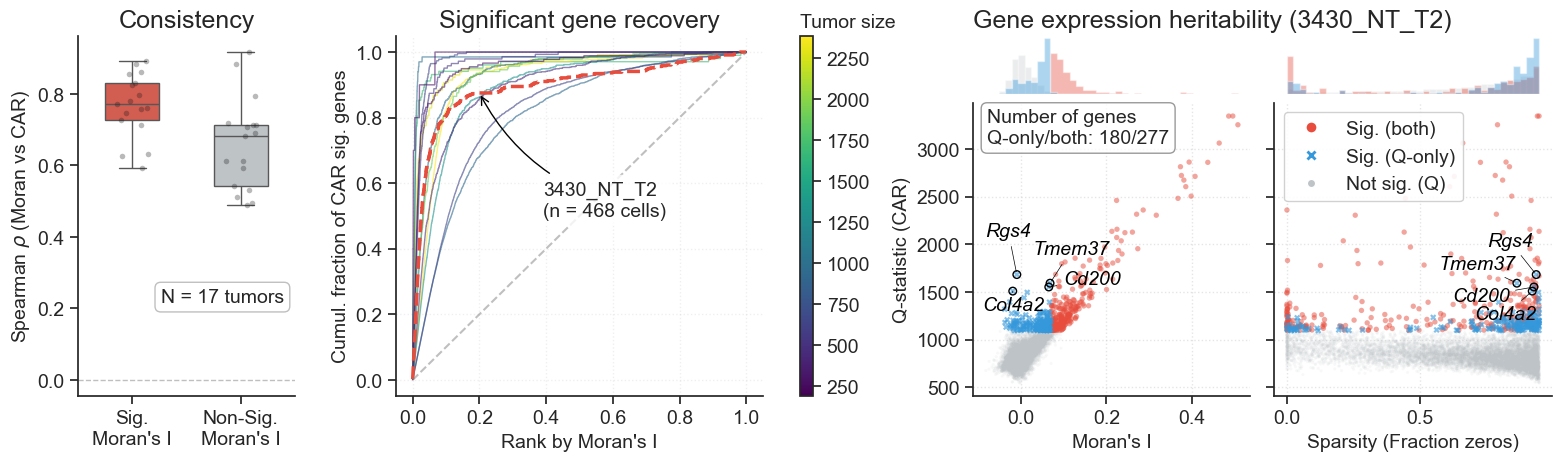

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import cm

# Prepare data
target_tumor_id = '3430_NT_T2'
# target_tumor_id = '3724_NT_T1'
df_rna_target = df_rna_all[df_rna_all['Tumor'] == target_tumor_id]
tumor_sizes = df_rna_metrics.set_index('Tumor', inplace=False)['N_Cells']

# Genes to annotate
plot_genes = ['Rgs4', 'Col4a2', 'Tmem37', 'Cd200']

# ==========================================
# Visualization
# ==========================================
# Setup Figure
fig = plt.figure(figsize=(15.5, 4.5), layout='constrained')
gs = gridspec.GridSpec(
    1, 5, figure=fig, width_ratios=[0.65, 1.1, 0.04, 1, 1], wspace=0.12
)

# --- Panel A: Boxplots ---
ax0 = fig.add_subplot(gs[0])

# Group genes by significance
df_melt = df_rna_metrics.melt(
    id_vars=['Tumor'], 
    value_vars=['Rho_Sig_Moran', 'Rho_NonSig_Moran'],
    var_name='Group', value_name='Spearman_Rho'
)
label_map = {
    'Rho_Sig_Moran': "Sig.\nMoran's I", 
    'Rho_NonSig_Moran': "Non-Sig.\nMoran's I"
}
df_melt['Group'] = df_melt['Group'].map(label_map)

sns.boxplot(x='Group', y='Spearman_Rho', hue='Group', data=df_melt, ax=ax0, 
            palette=['#e74c3c', '#bdc3c7'], width=0.5, showfliers=False, legend=False)
sns.stripplot(x='Group', y='Spearman_Rho', data=df_melt, ax=ax0, 
              color='k', alpha=0.3, jitter=0.15, s=4)

n_samples = df_rna_metrics['Tumor'].nunique()
ax0.text(0.95, 0.25, f'N = {n_samples} tumors', transform=ax0.transAxes, 
         ha='right', va='bottom', fontsize=font_config['text'],
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.5))

ax0.set_title("Consistency")
ax0.set_ylabel(r"Spearman $\rho$ (Moran vs CAR)")
ax0.set_xlabel("")
ax0.axhline(0, linestyle='--', color='gray', alpha=0.5, linewidth=1)
sns.despine(ax=ax0)

# --- Panel B: Multi-Tumor CDF Curves ---
ax1 = fig.add_subplot(gs[1])

# norm = mcolors.LogNorm(vmin=min(tumor_sizes.values), vmax=max(tumor_sizes.values))
norm = mcolors.Normalize(vmin=min(tumor_sizes.values), vmax=max(tumor_sizes.values))
cmap = cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Only include tumors with more than 10 significant hits
valid_tumors = [
    t for t in tumor_list if 
    df_rna_all['Sig_car'][df_rna_all['Tumor'] == t].sum() >= 10
]

for t in valid_tumors:
    if t == target_tumor_id: continue
    df_t = df_rna_all[df_rna_all['Tumor'] == t]
    df_sorted = df_t.sort_values('I_moran', ascending=False)
    
    cumulative_sig = np.cumsum(df_sorted['Sig_car'].astype(int).values)
    y_vals = cumulative_sig / cumulative_sig.max()
    x_vals = np.linspace(0, 1, len(df_sorted)) 
    
    ax1.plot(x_vals, y_vals, color=cmap(norm(tumor_sizes[t])), alpha=0.6, linewidth=1)

df_sorted = df_rna_target.sort_values('I_moran', ascending=False)
cumulative_sig = np.cumsum(df_sorted['Sig_car'].astype(int).values)
y_vals = cumulative_sig / cumulative_sig.max()
x_vals = np.linspace(0, 1, len(df_sorted))

# Highlight the selected sample
ax1.plot(x_vals, y_vals, color='#e74c3c', linewidth=2.5, linestyle='--', label=target_tumor_id)

target_size = tumor_sizes[target_tumor_id]
idx_annot = int(len(x_vals) * 0.2) 
ax1.annotate(f"{target_tumor_id}\n(n = {target_size} cells)", 
             xy=(x_vals[idx_annot], y_vals[idx_annot]), 
             xytext=(0.4, 0.5), textcoords='axes fraction',
             arrowprops=dict(arrowstyle="->", color='black', connectionstyle="arc3,rad=-0.2"),
             fontsize=font_config['text'], bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8))

ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)

ax1.set_title("Significant gene recovery")
ax1.set_xlabel("Rank by Moran's I")
ax1.set_ylabel("Cumul. fraction of CAR sig. genes")
ax1.grid(True, linestyle=':', alpha=0.3)
sns.despine(ax=ax1)

cax = fig.add_subplot(gs[2])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.ax.set_title('Tumor size', fontsize=font_config['legend'], loc='left')

# --- Common Scatter Data Prep ---
mask_both = df_rna_target['Sig_car'] & df_rna_target['Sig_moran']
mask_q_only = df_rna_target['Sig_car'] & ~df_rna_target['Sig_moran']
mask_ns = ~df_rna_target['Sig_car']

def plot_scatter_layers(ax, x_col, y_col):
    ax.scatter(df_rna_target.loc[mask_ns, x_col], df_rna_target.loc[mask_ns, y_col], 
               c='#bdc3c7', s=5, alpha=0.1, rasterized=True, edgecolor='none')
    ax.scatter(df_rna_target.loc[mask_both, x_col], df_rna_target.loc[mask_both, y_col], 
               c='#e74c3c', marker='o', s=15, alpha=0.5, rasterized=True, edgecolor='none')
    ax.scatter(df_rna_target.loc[mask_q_only, x_col], df_rna_target.loc[mask_q_only, y_col], 
               c='#3498db', marker='X', s=20, alpha=0.6, rasterized=False, edgecolor='none')

# --- Panel C & D Construction ---
gs_right = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[3:], 
                                            height_ratios=[0.2, 1], 
                                            width_ratios=[1, 1],
                                            hspace=0.0, wspace=0.02)

# --- Panel C: Metric Comparison ---
# Top Histogram
ax2_hist = fig.add_subplot(gs_right[0, 0])
bins_x = np.linspace(df_rna_target['I_moran'].min(), df_rna_target['I_moran'].max(), 40)
ax2_hist.hist(df_rna_target.loc[mask_ns, 'I_moran'], bins=bins_x, density=True, color='#bdc3c7', alpha=0.3)
if mask_both.sum() > 1:
    ax2_hist.hist(df_rna_target.loc[mask_both, 'I_moran'], bins=bins_x, density=True, color='#e74c3c', alpha=0.4, histtype='stepfilled')
if mask_q_only.sum() > 1:
    ax2_hist.hist(df_rna_target.loc[mask_q_only, 'I_moran'], bins=bins_x, density=True, color='#3498db', alpha=0.4, histtype='stepfilled')
ax2_hist.axis('off')
ax2_hist.set_title(f"Gene expression heritability ({target_tumor_id})", loc='left')

# Main Scatter
ax2_main = fig.add_subplot(gs_right[1, 0], sharex=ax2_hist)
plot_scatter_layers(ax2_main, 'I_moran', 'Q_car')
ax2_main.set_xlabel("Moran's I")
ax2_main.set_ylabel("Q-statistic (CAR)")
ax2_main.grid(True, linestyle=':', alpha=0.5)
sns.despine(ax=ax2_main)

# Add Note about Counts in Upper Left of Panel C
n_q_only = mask_q_only.sum()
n_both = mask_both.sum()
ax2_main.text(0.05, 0.98, f"Number of genes\nQ-only/both: {n_q_only}/{n_both}", 
              transform=ax2_main.transAxes, 
              ha='left', va='top', fontsize=font_config['text'],
              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Annotate Genes in Panel C with manual offsets
# Manual offsets to prevent overlap: (x_offset, y_offset)
offsets = {
    'Rgs4': (-0.02, 400),
    'Col4a2': (-0.0, -200),
    'Tmem37': (0.05, 300),
    'Cd200': (0.10, 25)
}

for gene in plot_genes:
    if gene in df_rna_target.index:
        x_pt = df_rna_target.loc[gene, 'I_moran']
        y_pt = df_rna_target.loc[gene, 'Q_car']
        
        off_x, off_y = offsets.get(gene, (0, 200))
        
        # Add annotation with arrow
        ax2_main.annotate(
            gene, 
            xy=(x_pt, y_pt), 
            xytext=(x_pt + off_x, y_pt + off_y), 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
            fontsize=font_config['text'],
            fontstyle='italic',
            ha='center',
            color='black'
        )
        # Highlight the specific point
        ax2_main.scatter(x_pt, y_pt, s=30, facecolors='none', edgecolors='black', linewidth=1)

# --- Panel D: Sparsity Effect ---
# Top Histogram
ax3_hist = fig.add_subplot(gs_right[0, 1])
bins_x_sp = np.linspace(df_rna_target['Sparsity'].min(), df_rna_target['Sparsity'].max(), 40)
ax3_hist.hist(df_rna_target.loc[mask_ns, 'Sparsity'], bins=bins_x_sp, density=True, color='#bdc3c7', alpha=0.3)
if mask_both.sum() > 1:
    ax3_hist.hist(df_rna_target.loc[mask_both, 'Sparsity'], bins=bins_x_sp, density=True, color='#e74c3c', alpha=0.4, histtype='stepfilled')
if mask_q_only.sum() > 1:
    ax3_hist.hist(df_rna_target.loc[mask_q_only, 'Sparsity'], bins=bins_x_sp, density=True, color='#3498db', alpha=0.4, histtype='stepfilled')
ax3_hist.axis('off')

# Main Scatter (Share Y with Panel C main)
ax3_main = fig.add_subplot(gs_right[1, 1], sharey=ax2_main, sharex=ax3_hist)
plot_scatter_layers(ax3_main, 'Sparsity', 'Q_car')
ax3_main.set_xlabel("Sparsity (Fraction zeros)")
plt.setp(ax3_main.get_yticklabels(), visible=False) # Hide Y ticks
ax3_main.grid(True, linestyle=':', alpha=0.5)
sns.despine(ax=ax3_main)

# Annotate Genes in Panel D with manual offsets
# Manual offsets to prevent overlap: (x_offset, y_offset)
offsets = {
    'Rgs4': (-0.1, 300),
    'Col4a2': (-0.1, -300),
    'Tmem37': (-0.15, 150),
    'Cd200': (-0.2, -150)
}

for gene in plot_genes:
    if gene in df_rna_target.index:
        x_pt = df_rna_target.loc[gene, 'Sparsity']
        y_pt = df_rna_target.loc[gene, 'Q_car']
        
        off_x, off_y = offsets.get(gene, (0, 200))
        
        # Add annotation with arrow
        ax3_main.annotate(
            gene, 
            xy=(x_pt, y_pt), 
            xytext=(x_pt + off_x, y_pt + off_y), 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
            fontsize=font_config['text'],
            fontstyle='italic',
            ha='center',
            color='black'
        )
        # Highlight the specific point
        ax3_main.scatter(x_pt, y_pt, s=30, facecolors='none', edgecolors='black', linewidth=1)

# Legend (Inside Panel D)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Sig. (both)', markerfacecolor='#e74c3c', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Sig. (Q-only)', markerfacecolor='#3498db', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Not sig. (Q)', markerfacecolor='#bdc3c7', markersize=6),
]
ax3_main.legend(handles=legend_elements, loc='upper left', framealpha=0.9, edgecolor='#cccccc')

plt.savefig('figures/lung_rna_heritability.pdf', bbox_inches='tight')
plt.show()

In [ ]:
_df = df_rna_target[(df_rna_target['Sig_car']) & (~df_rna_target['Sig_moran'])].sort_values('Q_car', ascending=False)
_df.head(n=10)

Q_moran  P_value_moran  Z_score_moran  P_adj_moran        Q_car  \
Feature                                                                      
Rgs4     -5.059460       0.655306      -0.446403     0.962299  1682.938259   
Tmem37   34.706848       0.002197       3.062233     0.057437  1592.557692   
Cd200    33.193754       0.003403       2.928731     0.078702  1552.731041   
Col4a2   -9.939438       0.380503      -0.876970     0.896568  1509.368683   
Malt1     7.364728       0.515821       0.649800     0.932600  1495.976138   
Ccdc120   3.645310       0.747732       0.321631     0.980288  1439.714228   
C2cd4b  -13.561805       0.231472      -1.196577     0.806452  1395.109319   
Bmp4     34.009937       0.002693       3.000744     0.066601  1393.003616   
Pecam1  -19.591932       0.083877      -1.728623     0.550540  1319.297261   
Pla2g1b  26.925972       0.017515       2.375716     0.236904  1296.626058   

          P_value_car  Z_score_car     P_adj_car       Tumor   I_moran  \
Feature                                                                  
Rgs4     1.904455e-13     9.381196  4.153010e-11  3430_NT_T2 -0.009901   
Tmem37   1.430079e-11     8.416448  2.541038e-09  3430_NT_T2  0.067919   
Cd200    8.940767e-11     7.991327  1.454011e-08  3430_NT_T2  0.064958   
Col4a2   6.242198e-10     7.528464  9.506967e-08  3430_NT_T2 -0.019451   
Malt1    1.124647e-09     7.385509  1.660152e-07  3430_NT_T2  0.014412   
Ccdc120  1.253685e-08     6.784953  1.603881e-06  3430_NT_T2  0.007134   
C2cd4b   7.869038e-08     6.308827  8.779467e-06  3430_NT_T2 -0.026540   
Bmp4     8.567195e-08     6.286350  9.448533e-06  3430_NT_T2  0.066556   
Pecam1   1.515516e-06     5.499587  1.211781e-04  3430_NT_T2 -0.038340   
Pla2g1b  3.516845e-06     5.257588  2.636260e-04  3430_NT_T2  0.052693   

         Sig_moran  Sig_car  Mean_Expr  Sparsity  
Feature                                           
Rgs4         False     True   0.038109  0.935897  
Tmem37       False     True   0.079806  0.863248  
Cd200        False     True   0.039321  0.927350  
Col4a2       False     True   0.041613  0.920940  
Malt1        False     True   0.024943  0.944444  
Ccdc120      False     True   0.023334  0.946581  
C2cd4b       False     True   0.027357  0.944444  
Bmp4         False     True   0.123555  0.794872  
Pecam1       False     True   0.033108  0.946581  
Pla2g1b      False     True   0.060084  0.886752

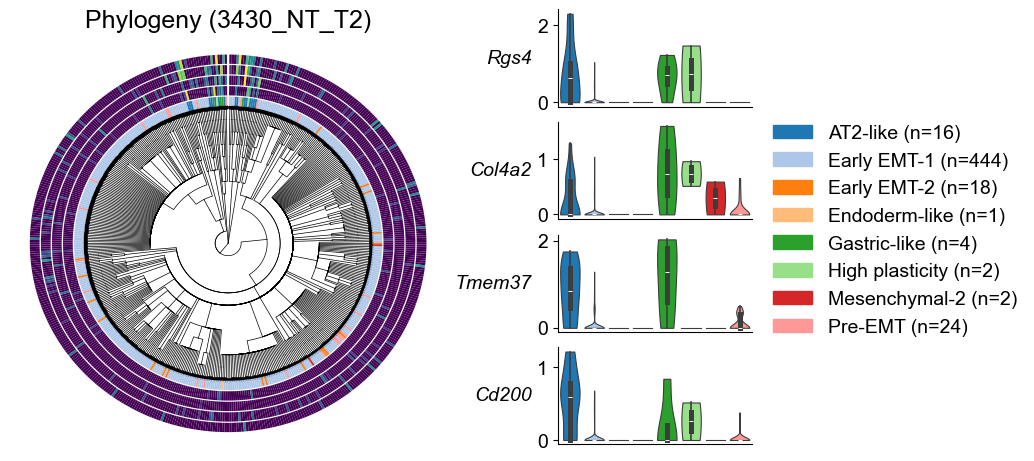

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scanpy as sc
import cassiopeia as cas
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import sparse

# --- 1. Setup Data ---
target_tumor_id = '3430_NT_T2'
# target_tumor_id = '3724_NT_T1'
df_rna_target = df_rna_all[df_rna_all['Tumor'] == target_tumor_id]
tree = tree_dict[target_tumor_id]
adata_tree = adata[list(tree.leaves), :].copy()

# plot_genes = _df.head(n=4).index.to_list()
# plot_genes = ['Rgs4', 'Col4a2', 'Malt1', 'Ccdc120', 'C2cd4b']
plot_genes = ['Rgs4', 'Col4a2', 'Tmem37', 'Cd200']

# Add metadata to tree for Cassiopeia plotting
tree.cell_meta = adata_tree.obs.copy()
for g in plot_genes:
    # Ensure dense array for plotting
    if sparse.issparse(adata_tree[:, g].X):
        tree.cell_meta[g] = adata_tree[:, g].X.toarray().flatten()
    else:
        tree.cell_meta[g] = adata_tree[:, g].X.flatten()

# --- 2. Coordinate Colors & Counts ---
# Get sorted unique clusters to ensure consistent ordering across both plots
unique_clusters = sorted(adata_tree.obs['Cluster-Name'].unique())

# Calculate cell counts for labeling
cluster_counts = adata_tree.obs['Cluster-Name'].value_counts()

# Create a palette
palette = sns.color_palette("tab20", n_colors=len(unique_clusters))
cluster_colors = dict(zip(unique_clusters, palette))

# Create mapping for Cassiopeia
custom_cmap = mcolors.ListedColormap(palette)
value_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}

# --- 3. Create Figure Layout ---
fig = plt.figure(figsize=(7.5, 4.5), layout='constrained') 
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 0.7])

# --- Left Panel: Cassiopeia Tree ---
ax_tree = fig.add_subplot(gs[0])

# The first column is categorical (Cluster), the rest are continuous (Genes)
cols_to_plot = ['Cluster-Name'] + plot_genes

cas.pl.plot_matplotlib(
    tree,
    ax=ax_tree,
    meta_data=cols_to_plot,
    categorical_cmap=custom_cmap,
    value_mapping=value_mapping,
    continuous_cmap='viridis', 
    add_root=False,
    branch_kwargs={'linewidth': 0.5},
    colorstrip_width=0.75, 
    colorstrip_spacing=0.1,
    orient=90.0
)
ax_tree.set_title(f"Phylogeny ({target_tumor_id})")

# --- Right Panel: Violin Plots (Vertical Column) ---
gs_violin = gridspec.GridSpecFromSubplotSpec(
    len(plot_genes), 1, 
    subplot_spec=gs[1], 
    hspace=0.05 
)

# Prepare dataframe for plotting
obs_df = adata_tree.obs.copy()
for g in plot_genes:
    if sparse.issparse(adata_tree[:, g].X):
        obs_df[g] = adata_tree[:, g].X.toarray().flatten()
    else:
        obs_df[g] = adata_tree[:, g].X.flatten()

axes_violins = []
for i, gene in enumerate(plot_genes):
    # Share x-axis
    sharex_ax = axes_violins[0] if i > 0 else None
    ax_g = fig.add_subplot(gs_violin[i], sharex=sharex_ax)
    axes_violins.append(ax_g)
    
    sns.violinplot(
        data=obs_df, 
        x='Cluster-Name', 
        y=gene, 
        hue='Cluster-Name',
        palette=cluster_colors, 
        order=unique_clusters,
        ax=ax_g,
        density_norm='width',
        linewidth=0.8,
        saturation=1,
        cut=0,
        legend=False
    )
    
    # Styling
    ax_g.set_ylabel(gene, rotation=0, ha='right', va='center', fontstyle='italic')
    ax_g.set_xlabel("")
    
    # Remove x-ticks and labels for ALL plots (including the bottom one)
    plt.setp(ax_g.get_xticklabels(), visible=False)
    ax_g.tick_params(axis='x', length=0)
    sns.despine(ax=ax_g)

# --- 4. Create Legend on the Right ---
legend_handles = []
for cluster in unique_clusters:
    count = cluster_counts.get(cluster, 0)
    label_text = f"{cluster} (n={count})"
    # Create a patch for the legend
    patch = mpatches.Patch(color=cluster_colors[cluster], label=label_text)
    legend_handles.append(patch)

# Add legend to the figure
fig.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(1.0, 0.5), 
    frameon=False,
)

plt.savefig('figures/lung_rna_example.pdf', bbox_inches='tight')
plt.show()

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_14562/1121796667.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=0)


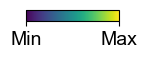

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as cbar
import numpy as np

# Define figure size for the standalone legend
fig, ax = plt.subplots(figsize=(1.2, 0.15))

# Setup the colormap used in the main plot
cmap = plt.get_cmap('viridis')
vmin = tree.cell_meta[plot_genes].min().min()
vmax = tree.cell_meta[plot_genes].max().max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create the colorbar
cb = cbar.ColorbarBase(
    ax, 
    cmap=cmap, 
    norm=norm, 
    orientation='horizontal'
)
cb.set_ticks([vmin, vmax])
cb.set_ticklabels(['Min', 'Max'])

# Adjust layout and save
plt.tight_layout(pad=0)
plt.savefig('figures/lung_rna_example_cbar.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Bivariate local correlation

#### Synthetic example for illustration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.linalg import eigh
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- 1. Simulation Setup (Same as before) ---
np.random.seed(42) 

# A. Tree and Clones
n_clones = 5
cells_per_clone = 20
n_cells = n_clones * cells_per_clone
clone_labels = np.repeat(np.arange(n_clones), cells_per_clone)

# Generate base genotypes
clone_centers = np.random.randn(n_clones, 10) * 2.5
genotype_data = np.zeros((n_cells, 10))
for i in range(n_cells):
    genotype_data[i] = clone_centers[clone_labels[i]] + np.random.normal(0, 0.2, 10)

# Hierarchical Clustering
Z = linkage(genotype_data, method='ward')
dendro_temp = dendrogram(Z, no_plot=True)
leaves_order = dendro_temp['leaves']
ordered_labels = clone_labels[leaves_order]

# --- 2. Feature Generation ---
# Define Spatial Weight Matrix W (1D Chain)
adj = np.zeros((n_cells, n_cells))
for i in range(n_cells - 1):
    adj[i, i+1] = 1
    adj[i+1, i] = 1
    
row_sums = adj.sum(axis=1)
W = adj / row_sums[:, np.newaxis]

n = n_cells
M = np.eye(n) - np.ones((n, n))/n
W_centered = M @ W @ M 

evals, evecs = eigh(W_centered)
vec_checker = evecs[:, 0] 

# Feature 1: Heritable
clone_vals = np.linspace(-1.5, 1.5, n_clones)
np.random.shuffle(clone_vals)
feat_heritable = np.array([clone_vals[l] for l in ordered_labels])
feat_heritable += np.random.normal(0, 0.1, n_cells)

# Feature 2: Plastic
feat_plastic = feat_heritable + np.random.normal(0, 1.0, n_cells)

# Feature 3: Co-expressed with 1
feat_co = feat_heritable + np.random.normal(0, 0.3, n_cells)

# Feature 4: Anti-coexpressed with 1 + High Freq Noise
feat_anti = -1.0 * feat_heritable + (2.5 * vec_checker)

# Standardize
raw_feats = np.vstack([feat_heritable, feat_plastic, feat_co, feat_anti]).T
X_std = (raw_feats - raw_feats.mean(axis=0)) / raw_feats.std(axis=0)

feats_group1 = X_std[:, 0:2]
feats_group2 = X_std[:, 2:4]

# --- 3. Compute Spatial Covariance ---
cov_matrix = (X_std.T @ W_centered @ X_std) / n_cells

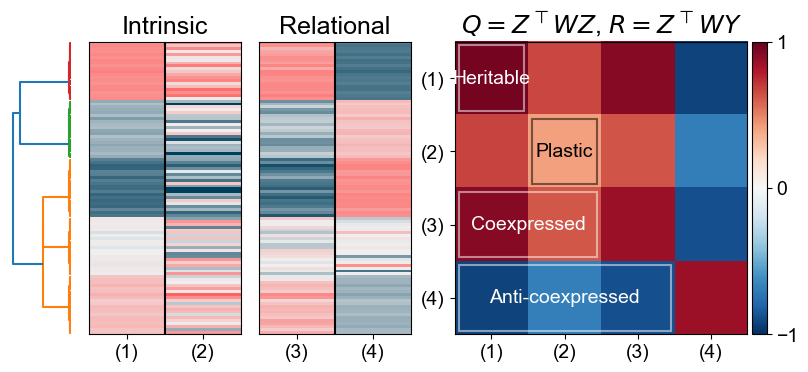

In [ ]:
# --- 4. Visualization ---

fig = plt.figure(figsize=(9, 4.5))

# Layout: 
gs = gridspec.GridSpec(1, 4, width_ratios=[0.2, 0.5, 0.5, 1.2], wspace=0.1)

# --- A. Phylogeny ---
ax_tree = fig.add_subplot(gs[0])
d = dendrogram(Z, orientation='left', ax=ax_tree, no_labels=True) 
ax_tree.axis('off')

# --- B. Feature Heatmaps ---
feats_group1_ordered = feats_group1[leaves_order[::-1]] 
feats_group2_ordered = feats_group2[leaves_order[::-1]]

cmap = LinearSegmentedColormap.from_list("custom", ["#003f5c", "#f0f0f0", "#ff6361"])
v_range = 2.0

# Heatmap 1
ax_hm1 = fig.add_subplot(gs[1])
ax_hm1.imshow(feats_group1_ordered, aspect='auto', cmap=cmap, vmin=-v_range, vmax=v_range, interpolation='nearest', rasterized=True)
ax_hm1.set_xticks([0, 1])
ax_hm1.set_xticklabels(['(1)', '(2)'])
ax_hm1.set_yticks([])
ax_hm1.set_title("Intrinsic")

# Heatmap 2
ax_hm2 = fig.add_subplot(gs[2])
ax_hm2.imshow(feats_group2_ordered, aspect='auto', cmap=cmap, vmin=-v_range, vmax=v_range, interpolation='nearest', rasterized=True)
ax_hm2.set_xticks([0, 1])
ax_hm2.set_xticklabels(['(3)', '(4)'])
ax_hm2.set_yticks([])
ax_hm2.set_title("Relational")

# Dividers
for ax in [ax_hm1, ax_hm2]:
    ax.axvline(0.5, color='k', linewidth=1.5)

# --- C. Covariance Matrix ---
ax_cov = fig.add_subplot(gs[3])

# Plot Matrix
im_cov = ax_cov.imshow(cov_matrix, cmap='RdBu_r', vmin=-1, vmax=1, rasterized=True)
im_cov.set_clip_on(False) 

# Axis labels
labels = ['(1)', '(2)', '(3)', '(4)']
ax_cov.set_xticks(np.arange(4))
ax_cov.set_yticks(np.arange(4))
ax_cov.set_xticklabels(labels)
ax_cov.set_yticklabels(labels)
ax_cov.set_title(r"$Q = Z^\top W Z$, $R = Z^\top W Y$")

# --- Annotations & Highlights ---
# 1. Heritable (1,1) -> Index (0,0)
rect_heritable = patches.Rectangle((-0.45, -0.45), 0.9, 0.9, linewidth=1.5, edgecolor='w', facecolor='none', alpha=0.5)
ax_cov.add_patch(rect_heritable)
ax_cov.text(0, 0, "Heritable", ha="center", va="center", color="white", fontsize=font_config['text'])

# 2. Plastic (2,2) -> Index (1,1)
rect_plastic = patches.Rectangle((0.55, 0.55), 0.9, 0.9, linewidth=1.5, edgecolor='k', facecolor='none', alpha=0.5)
ax_cov.add_patch(rect_plastic)
ax_cov.text(1, 1, "Plastic", ha="center", va="center", color="black", fontsize=font_config['text'])

# 3. Co-expressed (1-2, 3) -> Rows 0-1, Col 2
# Top-left of rect: x=1.55 (col 2 start), y=-0.45 (row 0 start)
# Width: 0.9, Height: 1.9 (covers 2 rows)
rect_co = patches.Rectangle((-0.45, 1.55), 1.9, 0.9, linewidth=1.5, edgecolor='w', facecolor='none', alpha=0.5)
ax_cov.add_patch(rect_co)
ax_cov.text(0.5, 2, "Coexpressed", ha="center", va="center", color="white", fontsize=font_config['text'])

# 4. Anti-expressed (1-3, 4) -> Rows 0-2, Col 3
# Top-left of rect: x=2.55 (col 3 start), y=-0.45 (row 0 start)
# Width: 0.9, Height: 2.9 (covers 3 rows)
rect_anti = patches.Rectangle((-0.45, 2.55), 2.9, 0.9, linewidth=1.5, edgecolor='w', facecolor='none', alpha=0.5)
ax_cov.add_patch(rect_anti)
ax_cov.text(1.0, 3, "Anti-coexpressed", ha="center", va="center", color="white", fontsize=font_config['text'])

# --- D. Colorbar ---
cax = make_axes_locatable(ax_cov).append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im_cov, cax=cax, orientation='vertical')
# cbar.set_label('Normalized score', fontsize=font_config['text'], rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=font_config['text'])
cbar.set_ticks([-1, 0, 1])

plt.subplots_adjust(left=0.05, right=0.92, top=0.85, bottom=0.2)

plt.savefig('figures/illustration_tree.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('figures/illustration_tree.svg', bbox_inches='tight')
plt.show()

#### Moran vs CAR, all sample

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from quadsv.detector import PatternDetector

# Configuration
sigma_range = range(1, 11)  # 1 to 10
results_summary = []        # To store counts/proportions per tumor/sigma
outlier_details = []        # To store specific outlier pairs

# --- Helper Function for Data Prep ---
def get_pair_data(df, metric, suffix):
    """Flattens matrix to unique pairs for regression."""
    d = df.copy()
    # Create sorted tuple index to handle undirected pairs uniquely
    d['Pair_ID'] = d.apply(lambda row: tuple(sorted([str(row['Feature_1']), str(row['Feature_2'])])), axis=1)
    d = d.drop_duplicates(subset=['Pair_ID'])
    return d.set_index('Pair_ID')[[metric]].rename(columns={metric: f"Val_{suffix}"})

# --- Main Loop ---
for tumor in tumor_list:
    if tumor == '3724_NT_T1':
        continue

    print(f"Processing {tumor}...")
    try:
        # 1. Data Prep
        tree = tree_dict[tumor]
        # Subset adata (ensure we copy to avoid overwriting original)
        adata_tree = adata[list(tree.leaves), :].copy()
        
        # Compute Ancestral Matrix
        adata_tree.obsp['W'] = compute_ancestral_matrix(tree, weights=[1.0, 0.5, 0.25])
        
        # 2. Moran's I
        model_m = PatternDetector(adata_tree, min_cells_frac=0.05)
        model_m.build_kernel_from_obsp(key='W', is_distance=False, method='moran')
        res_rna_moran = model_m.compute_qstat(source='var', features=None)
        sig_ft_moran = res_rna_moran[res_rna_moran['P_adj'] < 0.05].index.to_list()
        
        # 3. Inverse Laplacian
        model_i = PatternDetector(adata_tree, min_cells_frac=0.05)
        model_i.build_kernel_from_obsp(key='W', is_distance=False, method='car', rho=0.9, standardize=False)
        res_rna_car = model_i.compute_qstat(source='var', features=None)
        sig_ft_car = res_rna_car[res_rna_car['P_adj'] < 0.05].index.to_list()
        
        # Skip if insufficient features
        if len(sig_ft_moran) < 2 or len(sig_ft_car) < 2:
            print(f"  Skipping {tumor}: Insufficient significant features.")
            continue

        selected_genes = list(set(sig_ft_moran).intersection(sig_ft_car))

        df_moran = model_m.compute_rstat(source='var', features_x=selected_genes)
        df_car = model_i.compute_rstat(source='var', features_x=selected_genes)

        # 4. Matrix Alignment
        metric = 'Z_score'
        mat_moran = df_moran.pivot(index='Feature_1', columns='Feature_2', values=metric)
        mat_car = df_car.pivot(index='Feature_1', columns='Feature_2', values=metric)

        # Fill NA by symmetry
        mat_moran = mat_moran.combine_first(mat_moran.T).fillna(0)
        mat_car = mat_car.combine_first(mat_car.T).fillna(0)

        # Intersection
        mat_moran = mat_moran.loc[selected_genes, selected_genes]
        mat_car = mat_car.loc[selected_genes, selected_genes]
        
        # Flatten and Join
        # We reconstruct the DFs from the aligned matrices to ensure perfect sync
        df_m_aligned = mat_moran.stack().reset_index()
        df_m_aligned.columns = ['Feature_1', 'Feature_2', metric]
        
        df_i_aligned = mat_car.stack().reset_index()
        df_i_aligned.columns = ['Feature_1', 'Feature_2', metric]

        d1 = get_pair_data(df_m_aligned, metric, 'Moran')
        d2 = get_pair_data(df_i_aligned, metric, 'CAR')
        merged = d1.join(d2, how='inner')
        
        if len(merged) < 10:
            print(f"  Skipping {tumor}: Not enough shared pairs.")
            continue

        # 5. Regression & Residuals
        slope, intercept, r_value, p_value, std_err = stats.linregress(merged['Val_Moran'], merged['Val_CAR'])
        merged['Predicted'] = slope * merged['Val_Moran'] + intercept
        merged['Residual'] = merged['Val_CAR'] - merged['Predicted']
        resid_std = merged['Residual'].std()
        
        # Calculate standardized residual (Deviation)
        merged['Deviation_Z'] = merged['Residual'] / resid_std

        # 6. Iterative Thresholding
        total_pairs = len(merged)
        
        for sigma in sigma_range:
            # Define Masks
            # Moran Dominant: Residual is negative (Actual CAR < Predicted CAR based on Moran)
            mask_moran = merged['Deviation_Z'] < -sigma
            # CAR Dominant: Residual is positive (Actual CAR > Predicted CAR based on Moran)
            mask_car = merged['Deviation_Z'] > sigma
            
            n_moran = mask_moran.sum()
            n_car = mask_car.sum()
            
            # Store Summary
            results_summary.append({
                'Tumor': tumor,
                'Sigma': sigma,
                'Group': 'Moran dominant',
                'Count': n_moran,
                'Proportion': n_moran / total_pairs,
                'R_squared': r_value**2
            })
            results_summary.append({
                'Tumor': tumor,
                'Sigma': sigma,
                'Group': 'CAR dominant',
                'Count': n_car,
                'Proportion': n_car / total_pairs,
                'R_squared': r_value**2
            })
            
        # 7. Store Specific Outlier Pairs (e.g., those > 1 sigma)
        # We store them once per tumor, filtering later if needed
        outliers = merged[merged['Deviation_Z'].abs() > 1].copy()
        outliers['Tumor'] = tumor
        outliers['Dominant_Group'] = np.where(outliers['Deviation_Z'] > 0, 'CAR', 'Moran')
        outliers['Abs_Deviation'] = outliers['Deviation_Z'].abs()
        outlier_details.append(outliers)

    except Exception as e:
        print(f"  Error processing {tumor}: {e}")

# --- Compilation ---
df_summary = pd.DataFrame(results_summary)
df_outliers = pd.concat(outlier_details).reset_index()

print("Processing complete.")
print(f"Total tumors processed: {df_summary['Tumor'].nunique()}")

Processing 3430_NT_T1...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1693)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9468 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]  


Building car kernel from obsp['W'] (is_distance=False, n_samples=1693)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 9468 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 150.94it/s]   


Computing null distribution for R statistic...
Testing 87 x 87 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 2/2 [00:00<00:00, 17697.49it/s] 


Computing null distribution for R statistic...
Testing 87 x 87 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 2/2 [00:00<00:00, 20815.40it/s]   


Processing 3430_NT_T2...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=511)...
Removing 43 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9595 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1179.12it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=511)...
Removing 43 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 9595 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 860.59it/s]   


Computing null distribution for R statistic...
Testing 277 x 277 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 5/5 [00:00<00:00, 41282.52it/s] 


Computing null distribution for R statistic...
Testing 277 x 277 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 5/5 [00:00<00:00, 50051.36it/s]   


Processing 3435_NT_T1...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1109)...
Removing 453 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8387 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1176.89it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=1109)...
Removing 453 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8387 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 627.58it/s]   


Computing null distribution for R statistic...
Testing 216 x 216 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 4/4 [00:00<00:00, 36002.61it/s] 


Computing null distribution for R statistic...
Testing 216 x 216 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 4/4 [00:00<00:00, 41323.19it/s]   


Processing 3435_NT_T3...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=319)...
Removing 129 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 7148 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1659.51it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=319)...
Removing 129 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 7148 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1672.16it/s]  

  Skipping 3435_NT_T3: Insufficient significant features.
Processing 3434_NT_T1...


Building moran kernel from obsp['W'] (is_distance=False, n_samples=2402)...
Removing 13 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8614 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 206.18it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=2402)...
Removing 13 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8614 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 94.83it/s]    


Computing null distribution for R statistic...
Testing 715 x 715 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 12/12 [00:00<00:00, 9119.70it/s]


Computing null distribution for R statistic...
Testing 715 x 715 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 12/12 [00:00<00:00, 9134.60it/s]  


Processing 3434_NT_T3...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=2292)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8768 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 365.28it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=2292)...
Removing 2 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8768 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 92.96it/s]    


Computing null distribution for R statistic...
Testing 73 x 73 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 2/2 [00:00<00:00, 18517.90it/s] 


Computing null distribution for R statistic...
Testing 73 x 73 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 2/2 [00:00<00:00, 16256.99it/s]   


Processing 3434_NT_T2...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1165)...
Removing 202 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8752 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 858.78it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=1165)...
Removing 202 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 8752 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 424.75it/s]   


Computing null distribution for R statistic...
Testing 299 x 299 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 5/5 [00:00<00:00, 43151.28it/s] 


Computing null distribution for R statistic...
Testing 299 x 299 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 5/5 [00:00<00:00, 35187.11it/s]   


Processing 3513_NT_T1...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=969)...
Removing 1 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 5253 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 500.87it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=969)...
Removing 1 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 5253 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 465.33it/s]   


Computing null distribution for R statistic...
Testing 65 x 65 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 2/2 [00:00<00:00, 3860.38it/s]  


Computing null distribution for R statistic...
Testing 65 x 65 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 2/2 [00:00<00:00, 18682.87it/s]   

Processing 3513_NT_T3...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1457)...
Removing 130 isolated samples with zero degree from adjacency matrix...


Computing null distribution approximation (method=clt)...
Testing 5073 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 695.33it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=1457)...
Removing 130 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 5073 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 403.83it/s]   


Computing null distribution for R statistic...
Testing 315 x 315 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 5/5 [00:00<00:00, 42366.71it/s] 


Computing null distribution for R statistic...
Testing 315 x 315 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 5/5 [00:00<00:00, 53635.60it/s]   


Processing 3513_NT_T2...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=2118)...
Removing 219 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 4595 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 899.73it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=2118)...
Removing 219 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 4595 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 247.89it/s]   


Computing null distribution for R statistic...
Testing 59 x 59 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]  


Computing null distribution for R statistic...
Testing 59 x 59 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]   


Processing 3513_NT_T5...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=347)...
Removing 57 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 3986 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 2006.15it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=347)...
Removing 57 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 3986 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1489.97it/s]  


Computing null distribution for R statistic...
Testing 7 x 7 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s] 


Computing null distribution for R statistic...
Testing 7 x 7 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 1/1 [00:00<00:00, 6831.11it/s]    

Processing 3513_NT_T4...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=604)...


Removing 73 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 4405 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1672.06it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=604)...
Removing 73 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 4405 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1132.51it/s]  


Computing null distribution for R statistic...
Testing 106 x 106 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 2/2 [00:00<00:00, 15033.35it/s] 


Computing null distribution for R statistic...
Testing 106 x 106 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 2/2 [00:00<00:00, 23237.14it/s]   


Processing 3433_NT_T2...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=329)...
Removing 30 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 6720 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1914.99it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=329)...
Removing 30 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 6720 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1719.70it/s]  


Computing null distribution for R statistic...
Testing 145 x 145 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 3/3 [00:00<00:00, 20262.34it/s] 


Computing null distribution for R statistic...
Testing 145 x 145 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 3/3 [00:00<00:00, 33644.15it/s]   


Processing 3730_NT_T1...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=1223)...
Removing 284 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9923 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 738.28it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=1223)...
Removing 284 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 9923 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 351.81it/s]   


Computing null distribution for R statistic...
Testing 1271 x 1271 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 20/20 [00:01<00:00, 13.35it/s]  


Computing null distribution for R statistic...
Testing 1271 x 1271 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 20/20 [00:01<00:00, 13.72it/s]    


Processing 3726_NT_T1...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=772)...
Removing 124 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 10892 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 940.16it/s] 


Building car kernel from obsp['W'] (is_distance=False, n_samples=772)...
Removing 124 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 10892 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 598.96it/s]   


Computing null distribution for R statistic...
Testing 1472 x 1472 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 23/23 [00:01<00:00, 13.11it/s]  


Computing null distribution for R statistic...
Testing 1472 x 1472 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 23/23 [00:01<00:00, 14.68it/s]    


Processing 3726_NT_T2...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=854)...
Removing 350 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 8847 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1051.76it/s]

Building car kernel from obsp['W'] (is_distance=False, n_samples=854)...
Removing 350 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...


Testing 8847 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 656.57it/s]   


Computing null distribution for R statistic...
Testing 9 x 9 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]  


Computing null distribution for R statistic...
Testing 9 x 9 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]    


Processing 3730_NT_T2...
Building moran kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9605 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:00<00:00, 1251.37it/s]


Building car kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 9605 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 760.42it/s]   


Computing null distribution for R statistic...
Testing 495 x 495 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 8/8 [00:00<00:00, 6097.48it/s]  


Computing null distribution for R statistic...
Testing 495 x 495 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 8/8 [00:00<00:00, 6873.09it/s]    


Processing complete.
Total tumors processed: 16


In [ ]:
# # Save and reload results
# df_outliers.to_csv('results/lung_biv_outliers.csv', index=False)
# df_summary.to_csv('results/lung_biv_summary.csv', index=False)

# reload results
df_outliers = pd.read_csv('results/lung_biv_outliers.csv')
df_summary = pd.read_csv('results/lung_biv_summary.csv')

In [ ]:
def clean_parse_pair(s):
    if isinstance(s, tuple):
        return s

    # 1. Remove starting '(' and ending ')'
    s = s.strip('()')
    
    # 2. Split by comma
    parts = s.split(',')
    
    # 3. Clean each part: remove whitespace, single quotes, and double quotes
    # The strip function removes characters from both ends
    cleaned_parts = [p.strip(" '\"") for p in parts]
    
    return tuple(cleaned_parts)

# Apply the function
df_outliers['Gene_Pair'] = df_outliers['Pair_ID'].apply(clean_parse_pair)

In [ ]:
df_outliers

Pair_ID  Val_Moran    Val_CAR  Predicted   Residual  \
0               ('Rpl3', 'Rpl3')  13.234227  43.098872  22.635138  20.463735   
1             ('Eef1a1', 'Rpl3')  11.471299  28.898221  19.874574   9.023647   
2              ('Rpl15', 'Rpl3')   7.404476  19.398258  13.506347   5.891911   
3             ('Rpl13a', 'Rpl3')   5.446082  16.742889  10.439704   6.303185   
4               ('Rpl3', 'Rps6')   9.532270  24.040670  16.838254   7.202416   
...                          ...        ...        ...        ...        ...   
544328        ('Gstm1', 'Tceb2')  10.574403  13.584886  14.953390  -1.368505   
544329  ('Lgals3bp', 'Lgals3bp')   7.288983  21.694302  10.339944  11.354357   
544330     ('Gstm1', 'Lgals3bp')  -4.202226  -4.516262  -5.796223   1.279961   
544331  ('Atp6v1g1', 'Atp6v1g1')   5.356842  17.792538   7.626796  10.165742   
544332        ('Gstm1', 'Gstm1')   8.334327  17.938851  11.807834   6.131016   

        Deviation_Z       Tumor Dominant_Group  Abs_Deviation  \
0          3.655614  3430_NT_T1            CAR       3.655614   
1          1.611972  3430_NT_T1            CAR       1.611972   
2          1.052523  3430_NT_T1            CAR       1.052523   
3          1.125992  3430_NT_T1            CAR       1.125992   
4          1.286630  3430_NT_T1            CAR       1.286630   
...             ...         ...            ...            ...   
544328    -1.113840  3730_NT_T2          Moran       1.113840   
544329     9.241431  3730_NT_T2            CAR       9.241431   
544330     1.041774  3730_NT_T2            CAR       1.041774   
544331     8.274005  3730_NT_T2            CAR       8.274005   
544332     4.990099  3730_NT_T2            CAR       4.990099   

                   Gene_Pair  
0               (Rpl3, Rpl3)  
1             (Eef1a1, Rpl3)  
2              (Rpl15, Rpl3)  
3             (Rpl13a, Rpl3)  
4               (Rpl3, Rps6)  
...                      ...  
544328        (Gstm1, Tceb2)  
544329  (Lgals3bp, Lgals3bp)  
544330     (Gstm1, Lgals3bp)  
544331  (Atp6v1g1, Atp6v1g1)  
544332        (Gstm1, Gstm1)  

[544333 rows x 10 columns]

In [ ]:
df_summary

Tumor  Sigma           Group  Count  Proportion  R_squared
0    3430_NT_T1      1  Moran dominant    377    0.098485   0.703745
1    3430_NT_T1      1    CAR dominant    412    0.107628   0.703745
2    3430_NT_T1      2  Moran dominant     22    0.005747   0.703745
3    3430_NT_T1      2    CAR dominant     99    0.025862   0.703745
4    3430_NT_T1      3  Moran dominant      4    0.001045   0.703745
..          ...    ...             ...    ...         ...        ...
315  3730_NT_T2      8    CAR dominant    260    0.002118   0.984638
316  3730_NT_T2      9  Moran dominant      0    0.000000   0.984638
317  3730_NT_T2      9    CAR dominant    177    0.001442   0.984638
318  3730_NT_T2     10  Moran dominant      0    0.000000   0.984638
319  3730_NT_T2     10    CAR dominant     90    0.000733   0.984638

[320 rows x 6 columns]

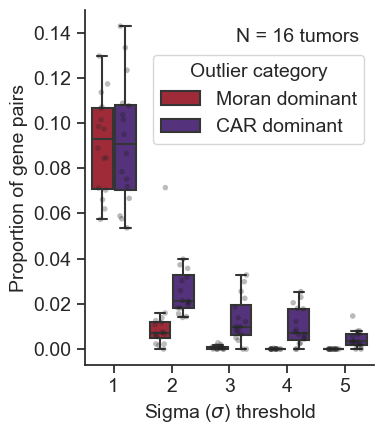

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Sigma <= 5
df_plot = df_summary[df_summary['Sigma'] <= 5].copy()
n_tumors = df_plot['Tumor'].nunique()

# Visualization
fig, ax = plt.subplots(figsize=(4, 4.5))

# Define Palette
palette = {'Moran dominant': '#b2182b', 'CAR dominant': '#542788'}

# Boxplot
sns.boxplot(data=df_plot, x='Sigma', y='Proportion', hue='Group', 
            palette=palette, ax=ax, fliersize=0, linewidth=1.5, gap=0.1)
sns.stripplot(data=df_plot, x='Sigma', y='Proportion', hue='Group', 
              dodge=True, color='k', palette='dark:k', alpha=0.3, size=4, 
              ax=ax, legend=False, jitter=0.2, linewidth=0)

# Add Sample Size Annotation
# Placed in top-right corner relative to axes
ax.text(0.95, 0.95, f'N = {n_tumors} tumors', 
        transform=ax.transAxes, 
        ha='right', va='top', 
        fontsize=font_config['text'], 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

# Labels
ax.set_ylabel("Proportion of gene pairs", fontsize=font_config['label'])
ax.set_xlabel(r"Sigma ($\sigma$) threshold", fontsize=font_config['label'])
ax.tick_params(axis='both', which='major', labelsize=font_config['tick'])

# Legend
handles, labels = ax.get_legend_handles_labels()
# Place legend slightly below the N annotation or to the side to avoid overlap
ax.legend(handles=handles, labels=labels, 
          loc='upper right', 
          bbox_to_anchor=(1, 0.90), # Shift down slightly to make room for N text
          title='Outlier category', 
          fontsize=font_config['text'],
          title_fontsize=font_config['text'],
          frameon=True)

# Remove top and right spines
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('figures/bivariate_outlier_boxplot.pdf', bbox_inches='tight')
plt.show()

#### Moran vs CAR, one sample

In [ ]:
from scipy import stats
from quadsv.detector import PatternDetector

tumor = '3730_NT_T2'

tree = tree_dict[tumor]
# Subset adata (ensure we copy to avoid overwriting original)
adata_tree = adata[list(tree.leaves), :].copy()

# Compute Ancestral Matrix
adata_tree.obsp['W'] = compute_ancestral_matrix(tree, weights=[1.0, 0.5, 0.25])

# 2. Moran's I
model_m = PatternDetector(adata_tree, min_cells_frac=0.05)
model_m.build_kernel_from_obsp(key='W', is_distance=False, method='moran')
res_rna_moran = model_m.compute_qstat(source='var', features=None)
sig_ft_moran = res_rna_moran[res_rna_moran['P_adj'] < 0.05].index.to_list()

# 3. Inverse Laplacian
model_i = PatternDetector(adata_tree, min_cells_frac=0.05)
model_i.build_kernel_from_obsp(key='W', is_distance=False, method='car', rho=0.9, standardize=False)
res_rna_car = model_i.compute_qstat(source='var', features=None)
sig_ft_car = res_rna_car[res_rna_car['P_adj'] < 0.05].index.to_list()

selected_genes = list(set(sig_ft_moran).intersection(sig_ft_car))

df_moran = model_m.compute_rstat(source='var', features_x=selected_genes)
df_car = model_i.compute_rstat(source='var', features_x=selected_genes)

Building moran kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=clt)...
Testing 9605 features using 8 cores...


Q (moran): 100%|██████████████████████████████| 32/32 [00:04<00:00,  6.49it/s]                                                                                                   


Building car kernel from obsp['W'] (is_distance=False, n_samples=657)...
Removing 171 isolated samples with zero degree from adjacency matrix...
Computing null distribution approximation (method=welch)...
Testing 9605 features using 8 cores...


Q (car): 100%|██████████████████████████████| 32/32 [00:00<00:00, 535.96it/s]                                                                                                    


Computing null distribution for R statistic...
Testing 495 x 495 pairs using 8 cores with chunk_size=64...


R (moran): 100%|██████████████████████████████| 8/8 [00:00<00:00, 1732.74it/s]                                                                                                   


Computing null distribution for R statistic...
Testing 495 x 495 pairs using 8 cores with chunk_size=64...


R (car): 100%|██████████████████████████████| 8/8 [00:00<00:00, 5424.25it/s]                                                                                                     


In [ ]:
def get_pair_data(df, metric, suffix):
    """Flattens matrix to unique pairs for regression."""
    d = df.copy()
    # Create sorted tuple index to handle undirected pairs uniquely
    d['Pair_ID'] = d.apply(lambda row: tuple(sorted([str(row['Feature_1']), str(row['Feature_2'])])), axis=1)
    d = d.drop_duplicates(subset=['Pair_ID'])
    return d.set_index('Pair_ID')[[metric]].rename(columns={metric: f"Val_{suffix}"})

# Matrix alignment
metric = 'Z_score'
mat_moran = df_moran.pivot(index='Feature_1', columns='Feature_2', values=metric)
mat_car = df_car.pivot(index='Feature_1', columns='Feature_2', values=metric)

# Fill NA by symmetry
mat_moran = mat_moran.combine_first(mat_moran.T).fillna(0)
mat_car = mat_car.combine_first(mat_car.T).fillna(0)

# Intersection
mat_moran = mat_moran.loc[selected_genes, selected_genes]
mat_car = mat_car.loc[selected_genes, selected_genes]

# Flatten and Join
# We reconstruct the DFs from the aligned matrices to ensure perfect sync
df_m_aligned = mat_moran.stack().reset_index()
df_m_aligned.columns = ['Feature_1', 'Feature_2', metric]

df_i_aligned = mat_car.stack().reset_index()
df_i_aligned.columns = ['Feature_1', 'Feature_2', metric]

d1 = get_pair_data(df_m_aligned, metric, 'Moran')
d2 = get_pair_data(df_i_aligned, metric, 'CAR')
merged = d1.join(d2, how='inner')

# 5. Regression & Residuals
slope, intercept, r_value, p_value, std_err = stats.linregress(merged['Val_Moran'], merged['Val_CAR'])
merged['Predicted'] = slope * merged['Val_Moran'] + intercept
merged['Residual'] = merged['Val_CAR'] - merged['Predicted']
resid_std = merged['Residual'].std()

# Calculate standardized residual (Deviation)
merged['Deviation_Z'] = merged['Residual'] / resid_std

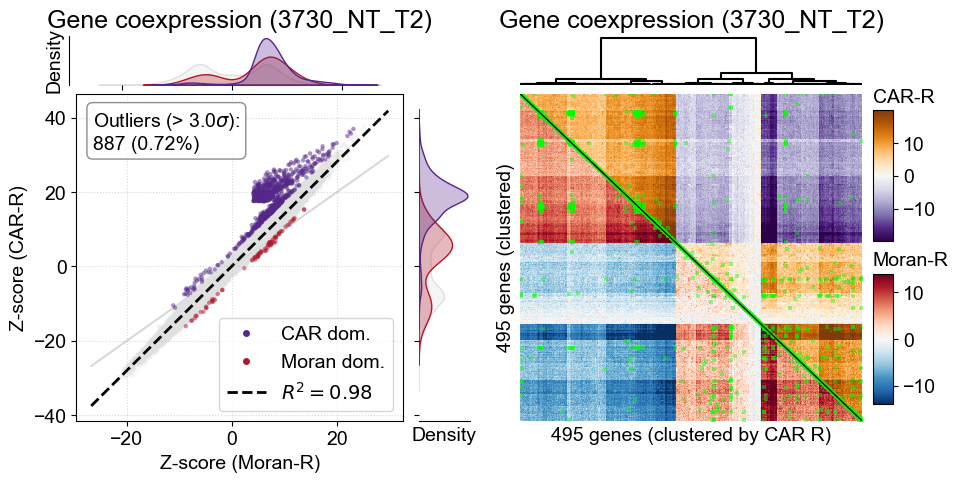

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy import stats
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib as mpl

sigma_threshold = 3.0
metric = 'Z_score'

# Grouping
conditions = [
    (merged['Residual'].abs() <= sigma_threshold * resid_std),
    (merged['Residual'] < -sigma_threshold * resid_std),
    (merged['Residual'] > sigma_threshold * resid_std)
]
choices = ['Consistent', 'Moran dominant', 'CAR dominant']
merged['Group'] = np.select(conditions, choices, default='Consistent')

# Calculate Stats
total_pairs = len(merged)
outlier_df = merged[merged['Group'] != 'Consistent']
n_outliers = len(outlier_df)
pct_outliers = (n_outliers / total_pairs) * 100

palette_scatter = {
    'Consistent': '#e0e0e0',
    'Moran dominant': '#b2182b', 
    'CAR dominant': '#542788'
}

fig = plt.figure(figsize=(11, 5)) 

gs = GridSpec(2, 5, figure=fig, 
              width_ratios=[10, 1.5, 1.0, 10, 1.5], 
              height_ratios=[1.5, 10],
              wspace=0.05, hspace=0.05)

# ---------------------------------------------------------
# 2. SCATTER & MARGINALS (Left Side - Cols 0 & 1)
# ---------------------------------------------------------

ax_scat = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_scat)
ax_side = fig.add_subplot(gs[1, 1], sharey=ax_scat)

groups = ['Consistent', 'Moran dominant', 'CAR dominant']

for group in groups:
    subset = merged[merged['Group'] == group]
    if subset.empty: continue
    
    c = palette_scatter[group]
    alpha = 0.15 if group == 'Consistent' else 0.5
    z = 1 if group == 'Consistent' else 3
    
    ax_scat.scatter(subset['Val_Moran'], subset['Val_CAR'], c=c, s=10, 
                    alpha=alpha, zorder=z, edgecolors='none', rasterized=(group == 'Consistent'))
    
    sns.kdeplot(data=subset, x='Val_Moran', ax=ax_top, color=c, fill=True, alpha=0.3, warn_singular=False)
    sns.kdeplot(data=subset, y='Val_CAR', ax=ax_side, color=c, fill=True, alpha=0.3, warn_singular=False)

# Regression Line
x_range = np.array(ax_scat.get_xlim())
ax_scat.plot(x_range, slope*x_range + intercept, 'k--', lw=2, zorder=4)
ax_scat.plot(x_range, x_range, color='gray', linestyle='-', alpha=0.3, lw=1.5, zorder=0)

# Stats Annotation
stats_text = rf"Outliers (> {sigma_threshold:.1f}$\sigma$):" + "\n" + f"{n_outliers} ({pct_outliers:.2f}%)"
ax_scat.text(0.05, 0.95, stats_text, transform=ax_scat.transAxes, 
             fontsize=font_config['text'], verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_scatter['CAR dominant'], label='CAR dom.'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_scatter['Moran dominant'], label='Moran dom.'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$R^2 = {:.2f}$'.format(r_value**2))
]
ax_scat.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=font_config['text'])

ax_scat.set_box_aspect(1)
ax_scat.set_xlabel("Z-score (Moran-R)", fontsize=font_config['label'])
ax_scat.set_ylabel("Z-score (CAR-R)", fontsize=font_config['label'])
ax_scat.grid(True, linestyle=':', alpha=0.5)

# Clean up marginals
plt.setp(ax_top.get_xticklabels(), visible=False)
plt.setp(ax_side.get_yticklabels(), visible=False)
ax_top.set_xlabel("")
ax_side.set_ylabel("")
ax_top.set_yticks([])
ax_side.set_xticks([])

sns.despine(ax=ax_top, left=False, bottom=True)
sns.despine(ax=ax_side, left=True, bottom=False)

ax_top.set_title(f"Gene coexpression ({tumor})", fontsize=font_config['title'])

# ---------------------------------------------------------
# 3. CLUSTERING (Top Right - Col 3)
# ---------------------------------------------------------

linkage = sch.linkage(mat_car, method='ward')

ax_dendro = fig.add_subplot(gs[0, 3])
dendro = sch.dendrogram(linkage, ax=ax_dendro, no_labels=True, 
                        color_threshold=0, above_threshold_color='k',
                        link_color_func=lambda x: 'k')
ax_dendro.axis('off')
ax_dendro.margins(x=0)
ax_dendro.set_title(f"Gene coexpression ({tumor})", fontsize=font_config['title'])

order = dendro['leaves']
mat_moran_sorted = mat_moran.iloc[order, order]
mat_car_sorted = mat_car.iloc[order, order]

# ---------------------------------------------------------
# 4. HEATMAP (Bottom Right - Col 3)
# ---------------------------------------------------------

ax_hm = fig.add_subplot(gs[1, 3])

# FLIPPED MASKS:
# mask_upper hides the upper triangle -> used for Moran (now on bottom)
# mask_lower hides the lower triangle -> used for Inv Lap (now on top)
mask_upper = np.triu(np.ones_like(mat_moran_sorted, dtype=bool)) # Hides upper right
mask_lower = np.tril(np.ones_like(mat_car_sorted, dtype=bool))   # Hides lower left

lim_m = np.percentile(np.abs(mat_moran.values), 98)
lim_i = np.percentile(np.abs(mat_car.values), 98)

# Plot Heatmaps
# Moran on Lower Left (using mask_upper to hide top)
sns.heatmap(mat_moran_sorted, ax=ax_hm, mask=mask_upper, cmap='RdBu_r', 
            center=0, vmin=-lim_m, vmax=lim_m, cbar=False,
            xticklabels=False, yticklabels=False, square=False, rasterized=True)

# Inv Lap on Upper Right (using mask_lower to hide bottom)
sns.heatmap(mat_car_sorted, ax=ax_hm, mask=mask_lower, cmap='PuOr_r', 
            center=0, vmin=-lim_i, vmax=lim_i, cbar=False,
            xticklabels=False, yticklabels=False, square=False, rasterized=True)

# Highlight Outliers on Heatmap
gene_to_idx = {gene: i for i, gene in enumerate(mat_moran_sorted.index)}
outlier_xs = []
outlier_ys = []

for idx_pair, row in outlier_df.iterrows():
    g1, g2 = idx_pair
    if g1 in gene_to_idx and g2 in gene_to_idx:
        i1, i2 = gene_to_idx[g1], gene_to_idx[g2]
        outlier_xs.extend([i1 + 0.5, i2 + 0.5])
        outlier_ys.extend([i2 + 0.5, i1 + 0.5])

ax_hm.scatter(outlier_xs, outlier_ys, s=10, color='#00FF00', alpha=0.4, marker='s', linewidths=0)

ax_hm.set_xlabel(f"{mat_car.shape[0]} genes (clustered by CAR R)", fontsize=font_config['label'])
ax_hm.set_ylabel(f"{mat_car.shape[0]} genes (clustered)", fontsize=font_config['label'])
ax_hm.plot([0, mat_moran.shape[0]], [0, mat_moran.shape[0]], 'k-', lw=1)

# ---------------------------------------------------------
# 5. COLORBARS (Far Right - Col 4)
# ---------------------------------------------------------

ax_cb_container = fig.add_subplot(gs[1, 4])
ax_cb_container.axis('off')

# Adjust positions for right side
ax_cbar1 = ax_cb_container.inset_axes([0.05, 0.05, 0.4, 0.4]) # Bottom (Moran)
ax_cbar2 = ax_cb_container.inset_axes([0.05, 0.55, 0.4, 0.4]) # Top (Inv Lap)

norm_m = mpl.colors.Normalize(vmin=-lim_m, vmax=lim_m)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_m, cmap='RdBu_r'), cax=ax_cbar1)
ax_cbar1.set_title("Moran-R", fontsize=font_config['text'], loc='left')

norm_i = mpl.colors.Normalize(vmin=-lim_i, vmax=lim_i)
cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_i, cmap='PuOr_r'), cax=ax_cbar2)
ax_cbar2.set_title("CAR-R", fontsize=font_config['text'], loc='left')

plt.savefig('figures/bivariate_example.pdf', bbox_inches='tight')
plt.show()

#### Visualize one pair

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cassiopeia as cas
from scipy import sparse, stats
from matplotlib.gridspec import GridSpec

tumor = '3730_NT_T2'

tree = tree_dict[tumor]
adata_tree = adata[list(tree.leaves), :].copy()
adata_tree.obsp['W'] = compute_ancestral_matrix(tree, weights=[1.0, 0.5, 0.25])

# Filter for the specific tumor and Inv Lap dominance
df_t = df_outliers[
    (df_outliers['Tumor'] == tumor) & (df_outliers['Dominant_Group'] == 'CAR')
].copy()

# Filter out self-self pairs (e.g., ('Rpl34', 'Rpl34'))
df_t = df_t[df_t['Gene_Pair'].apply(lambda x: x[0] != x[1])]

# Select the pair with the highest absolute Residual (deviation between metrics)
target_row = df_t.loc[df_t['Residual'].abs().idxmax()]
gene_a, gene_b = target_row['Gene_Pair']

print(f"Selected Pair: {gene_a} & {gene_b}")
print(target_row)

Selected Pair: Gdpd2 & Spink5
Pair_ID           ('Gdpd2', 'Spink5')
Val_Moran                    4.459725
Val_CAR                     12.944654
Predicted                    6.367048
Residual                     6.577606
Deviation_Z                  5.353583
Tumor                      3730_NT_T2
Dominant_Group                    CAR
Abs_Deviation                5.353583
Gene_Pair             (Gdpd2, Spink5)
Name: 540173, dtype: object


In [ ]:
df_moran[
    ((df_moran['Feature_1'] == gene_a)  & (df_moran['Feature_2'] == gene_b))
]

Feature_1 Feature_2         R   Z_score   P_value     P_adj
134302     Gdpd2    Spink5  64.73008  4.459725  0.000008  0.000012

In [ ]:
# Extract expression vectors
vec_a = adata_tree[:, gene_a].X.toarray().flatten()
vec_b = adata_tree[:, gene_b].X.toarray().flatten()

# Z-score normalization
vec_a = stats.zscore(vec_a)
vec_b = stats.zscore(vec_b)

# Construct normalized kernel
W = adata_tree.obsp['W']
W_sym = 0.5 * (W + W.T)
row_sums = np.array(W_sym.sum(axis=1)).flatten()
row_sums[row_sums == 0] = 1.0
inv_D_sqrt = np.diag(1.0 / np.sqrt(row_sums))
W_norm = inv_D_sqrt @ W_sym @ inv_D_sqrt


# Spectrum decomposition
eigenvals, eigenvecs = np.linalg.eigh(W_norm)

# Sort eigenvalues descending (Positive -> Negative)
idx_sorted = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[idx_sorted]
eigenvecs = eigenvecs[:, idx_sorted]

# Project Gene Expression onto Eigenmodes (Spectral Coefficients)
# coeff_k = dot(vec, eigenvector_k)
coeffs_a = eigenvecs.T @ vec_a
coeffs_b = eigenvecs.T @ vec_b

# Calculate contribution to Covariance per mode
mode_contribution = coeffs_a * coeffs_b * eigenvals

In [ ]:
# Find problematic modes
# Largest positive and negative contributions
idx_contrib_pos = np.argmax(mode_contribution[1:]) + 1
idx_contrib_neg = np.argmax(- mode_contribution[1:]) + 1

selected_indices = [idx_contrib_pos, idx_contrib_neg]
mode_names = [f'Positive (Mode {idx_contrib_pos})', f'Negative (Mode {idx_contrib_neg})']
mode_keys = [f'Eig_{i}' for i in selected_indices]
colors_high = ['darkred', 'darkblue']

# Add data to Tree Metadata for plotting
tree.cell_meta = adata_tree.obs.copy()
tree.cell_meta[gene_a] = vec_a
tree.cell_meta[gene_b] = vec_b

for k, name, key in zip(selected_indices, mode_names, mode_keys):
    # Normalize eigenvector for visualization contrast
    ev = eigenvecs[:, k]
    # Flip sign if necessary to align with positive correlation for visualization
    if np.abs(ev.max()) < np.abs(ev.min()):
        ev = -ev
    tree.cell_meta[key] = ev

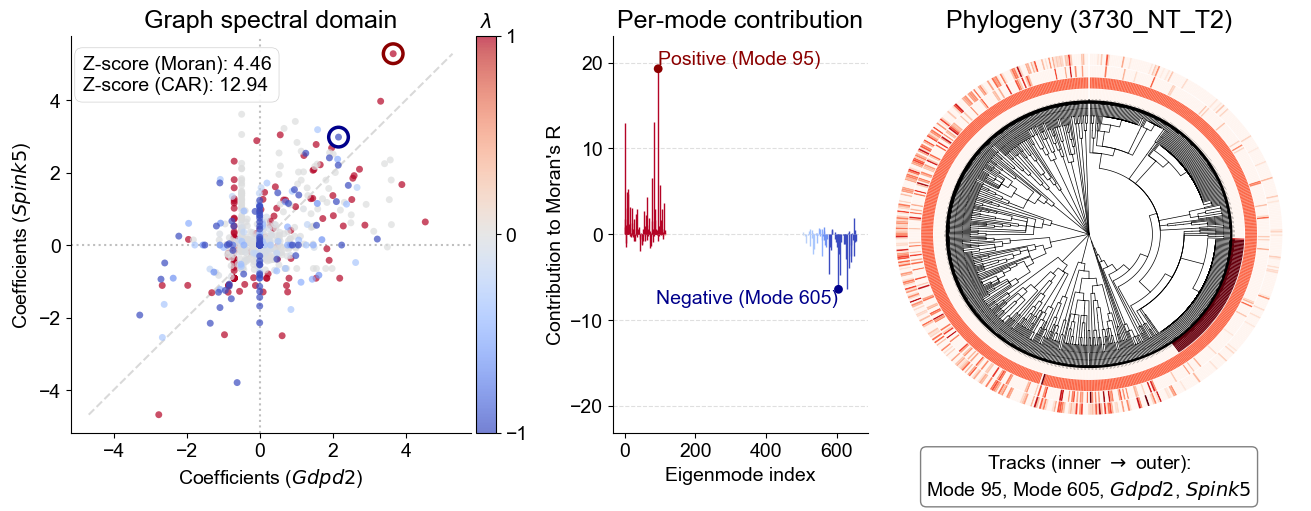

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns

# Use constrained_layout to automatically handle spacing
fig = plt.figure(figsize=(13, 5), constrained_layout=True)

# GridSpec: [Scatter, Spacer, Bar, Tree]
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 0.1, 0.6, 1])

# --- Panel A: Spectral Coefficients Scatter ---
ax_spec = fig.add_subplot(gs[0, 0])

# 1. Plot diagonal reference line
lims = [
    np.min([np.min(coeffs_a), np.min(coeffs_b)]),
    np.max([np.max(coeffs_a), np.max(coeffs_b)])
]
ax_spec.plot(lims, lims, 'k--', alpha=0.15, zorder=0, label='y=x')

# 2. Scatter plot
sc = ax_spec.scatter(coeffs_a, coeffs_b, c=eigenvals, cmap='coolwarm', 
                     s=25, alpha=0.7, edgecolors='none', linewidth=0.1, zorder=5)

ax_spec.set_xlabel(rf"Coefficients (${gene_a}$)")
ax_spec.set_ylabel(rf"Coefficients (${gene_b}$)")
ax_spec.set_title("Graph spectral domain")
ax_spec.axhline(0, color='gray', linestyle=':', alpha=0.5, zorder=1)
ax_spec.axvline(0, color='gray', linestyle=':', alpha=0.5, zorder=1)
sns.despine(ax=ax_spec)

# 3. Add color bar to the right of Panel A
divider = make_axes_locatable(ax_spec)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cax.set_title(r'$\lambda$', fontsize=font_config['text'])
cbar.set_ticks([np.min(eigenvals), 0, np.max(eigenvals)])
cbar.ax.tick_params(labelsize=font_config['tick'])

# 4. Highlight selected modes
for k, col in zip(selected_indices, colors_high):
    ax_spec.scatter(
        coeffs_a[k], coeffs_b[k], s=200, facecolors='none', 
        edgecolors=col, linewidth=2.5, zorder=10
    )

# 5. Info Box (Moved from Tree to here)
info_text = (f"Z-score (Moran): {target_row['Val_Moran']:.2f}\n"
             f"Z-score (CAR): {target_row['Val_CAR']:.2f}")

ax_spec.text(0.03, 0.95, info_text, transform=ax_spec.transAxes, 
             fontsize=font_config['text'], va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#cccccc", alpha=0.9, linewidth=0.5),
             zorder=20)

# --- Panel B: Spectrum Contribution ---
ax_bar = fig.add_subplot(gs[0, 2])
x_axis = np.arange(len(eigenvals))

# 1. Prepare colors based on eigenvalues (matching Panel A)
norm = plt.Normalize(np.min(eigenvals), np.max(eigenvals))
bar_colors = plt.cm.coolwarm(norm(eigenvals))

# 2. Bar chart
ax_bar.vlines(x_axis, 0, mode_contribution, colors=bar_colors, linewidth=1.0)

# 3. Annotate selected modes
max_contrib = np.max(np.abs(mode_contribution))
# Increased buffer to 1.2x to ensure text fits
ax_bar.set_ylim(-max_contrib * 1.2, max_contrib * 1.2)

for k, col, txt in zip(selected_indices, colors_high, mode_names):
    y_pos = mode_contribution[k]
    
    # Dynamic vertical alignment
    va = 'bottom' if y_pos >= 0 else 'top'
    ha = 'left' if y_pos >= 0 else 'right'

    ax_bar.text(k, y_pos, txt, ha=ha, va=va,
                color=col, fontsize=font_config['text'])
    
    # Highlight the specific bar tip
    ax_bar.scatter([k], [y_pos], color=col, zorder=10, s=40, edgecolor='none', linewidth=1)

ax_bar.set_xlabel("Eigenmode index")
ax_bar.set_ylabel("Contribution to Moran's R")
ax_bar.set_title("Per-mode contribution")
ax_bar.grid(True, which='both', axis='y', linestyle='--', alpha=0.4)
sns.despine(ax=ax_bar)

# --- Panel C: Tree Visualization ---
ax_tree = fig.add_subplot(gs[0, 3])

cols_to_plot = mode_keys + [gene_a, gene_b]
div_cmap = plt.get_cmap('Reds')

cas.pl.plot_matplotlib(
    tree,
    ax=ax_tree,
    meta_data=cols_to_plot,
    continuous_cmap=div_cmap,
    add_root=False,
    branch_kwargs={'linewidth': 0.5},
    colorstrip_width=1.5,
    colorstrip_spacing=0.1,
    orient=90.0
)
ax_tree.set_title(f"Phylogeny ({tumor})")

# --- Annotate Tracks Below Tree ---
# Create a list of labels corresponding to the plotted columns
track_labels = [f"Mode {k}" for k in selected_indices] + [rf"${gene_a}$", rf"${gene_b}$"]

# Join them into a single string describing the order
# "Inner -> Outer: Mode X, Mode Y, Gene A, Gene B"
label_str = r"Tracks (inner $\rightarrow$ outer):" + "\n" + ", ".join(track_labels)

# Place text box below the plot
# x=0.5 (center), y=-0.05 (just below the bottom edge)
ax_tree.text(0.5, -0.05, label_str, 
             transform=ax_tree.transAxes, 
             ha='center', va='top', 
             fontsize=font_config['text'],
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=1))

plt.savefig('figures/bivariate_spectral.pdf', bbox_inches='tight')
plt.show()

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_14562/1323037651.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=0)


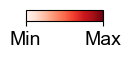

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as cbar
import numpy as np

# Define figure size for the standalone legend
fig, ax = plt.subplots(figsize=(1, 0.15))

# Setup the colormap used in the main plot
cmap = plt.get_cmap('Reds')
vmin = tree.cell_meta[cols_to_plot].min().min()
vmax = tree.cell_meta[cols_to_plot].max().max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create the colorbar
cb = cbar.ColorbarBase(
    ax, 
    cmap=cmap, 
    norm=norm, 
    orientation='horizontal'
)
cb.set_ticks([vmin, vmax])
cb.set_ticklabels(['Min', 'Max'])

# Adjust layout and save
plt.tight_layout(pad=0)
plt.savefig('figures/bivariate_spectral_cbar.pdf', format='pdf', bbox_inches='tight')
plt.show()